# CS 116 Project 6 : Synthesis and image editing with diffusion

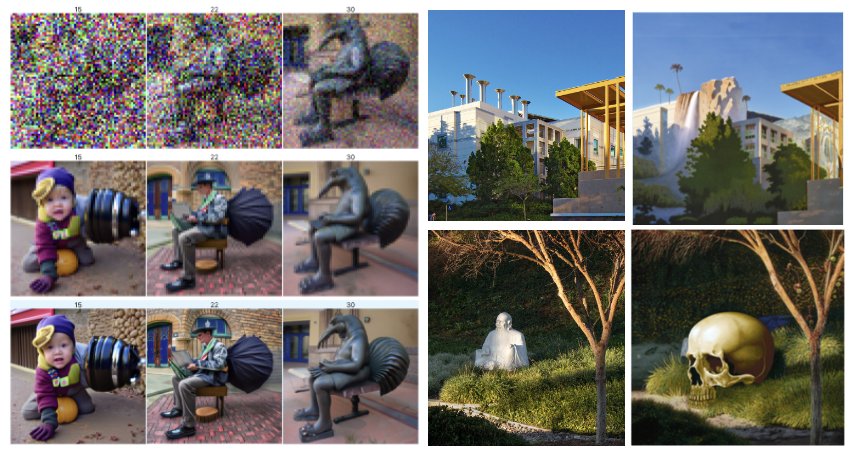

In this assignment you will experiment with diffusion models, implement diffusion sampling loops, and use them for related tasks such as inpainting.

### Install Dependencies

Run the below to install dependencies. If you are running locally you only need to run this once but if you are running on Colab you will likely need to run it everytime you start a new session.

In [1]:
! pip install -q \
  diffusers \
  transformers \
  safetensors \
  sentencepiece \
  accelerate \
  bitsandbytes \
  einops \
  mediapy \
  accelerate \
  huggingface_hub

# 0.Setup

### Using DeepFloyd

We are going to use the [DeepFloyd IF](https://huggingface.co/docs/diffusers/api/pipelines/deepfloyd_if) diffusion model. DeepFloyd is a two stage model trained by Stability AI. The first stage produces images of size $64 \times 64$ and the second stage takes the outputs of the first stage and generates images of size $256 \times 256$. Upsampling code is provided if you want to try it, but it is sufficient to generate 64x64 results for your submission.

Before downloading the DeepFloyd model, you must accept its usage conditions. To do this:

1. Make a [Hugging Face account](https://huggingface.co/join) and log in. You will need to confirm your email address.
2. Accept the license on the model card of [DeepFloyd/IF-I-XL-v1.0](https://huggingface.co/DeepFloyd/IF-I-XL-v1.0). Accepting the license on the stage I model card will auto accept for the other IF models.
3. Log in locally by entering your [Hugging Face Hub access token](https://huggingface.co/docs/hub/security-tokens#what-are-user-access-tokens) below. You should be able to find and create tokens [here](https://huggingface.co/settings/tokens).

In [ ]:
from huggingface_hub import login

token = ''
login(token=token)

In [3]:
pip install torch torchvision torchaudio --index-url https://download.pytorch.org/whl/cu118

Looking in indexes: https://download.pytorch.org/whl/cu118
Note: you may need to restart the kernel to use updated packages.


### Import Dependencies

The cell below imports useful packages you will need and select the device that the model will run on. 

You have a few options for device:

- If you have a machine with an NVIDIA GPU, you can try device='cuda'
- If you have a MacOS machine, you can try device='mps' which will exploit recent Apple silicon
- GoogleColab provides limited free access to NVIDIA GPU devices (e.g. T4). Note: if you go this route you should make sure and disconnect your session when not using it to avoid usage-based restrictions. Alternately, you can pay for a pro account to get more access

In [4]:
import torchvision

from PIL import Image
import mediapy as media
from pprint import pprint
from tqdm import tqdm

import torch
import torchvision.transforms.functional as TF
import torchvision.transforms as transforms
from diffusers import DiffusionPipeline
from transformers import T5EncoderModel

# For downloading web images
import requests
from io import BytesIO

device = 'cuda'  #if you have an NVIDIA GPU
#device = 'mps'   #supported by macOS12.6 or later with apple silicon M1/M2/M3 hardware, mileage may vary for older hardware
#device = 'cpu'   #definitely not recommended... takes 100s of seconds per iteration on my laptop
print(torchvision.__version__)
print(torch.cuda.is_available())  # Should return True
print(torch.cuda.get_device_name(0))  # Should return your GPU name


0.21.0+cu118
True
NVIDIA GeForce GTX 1660 Ti


### Loading the models

We will need to download and create the two DeepFloyd stages. These models are quite large, so this cell may take a minute or two to run.

In [5]:
# Load DeepFloyd IF stage I
stage_1 = DiffusionPipeline.from_pretrained(
    "DeepFloyd/IF-I-L-v1.0",
    text_encoder=None,
    variant="fp16",
    torch_dtype=torch.float16,
)
stage_1.to(device)

# comment this part for now
 #Load DeepFloyd IF stage II
stage_2 = DiffusionPipeline.from_pretrained(
    "DeepFloyd/IF-II-L-v1.0",
     text_encoder=None,
     variant="fp16",
     torch_dtype=torch.float16,
)
stage_2.to(device)


A mixture of fp16 and non-fp16 filenames will be loaded.
Loaded fp16 filenames:
[text_encoder/model.fp16-00001-of-00002.safetensors, safety_checker/model.fp16.safetensors, unet/diffusion_pytorch_model.fp16.safetensors, text_encoder/model.fp16-00002-of-00002.safetensors]
Loaded non-fp16 filenames:
[watermarker/diffusion_pytorch_model.safetensors
If this behavior is not expected, please check your folder structure.


Loading pipeline components...:   0%|          | 0/6 [00:00<?, ?it/s]

You are using the default legacy behaviour of the <class 'transformers.models.t5.tokenization_t5.T5Tokenizer'>. This is expected, and simply means that the `legacy` (previous) behavior will be used so nothing changes for you. If you want to use the new behaviour, set `legacy=False`. This should only be set if you understand what it means, and thoroughly read the reason why this was added as explained in https://github.com/huggingface/transformers/pull/24565

A mixture of fp16 and non-fp16 filenames will be loaded.
Loaded fp16 filenames:
[text_encoder/model.fp16-00001-of-00002.safetensors, safety_checker/model.fp16.safetensors, unet/diffusion_pytorch_model.fp16.safetensors, text_encoder/model.fp16-00002-of-00002.safetensors]
Loaded non-fp16 filenames:
[watermarker/diffusion_pytorch_model.safetensors
If this behavior is not expected, please check your folder structure.


Loading pipeline components...:   0%|          | 0/7 [00:00<?, ?it/s]

IFSuperResolutionPipeline {
  "_class_name": "IFSuperResolutionPipeline",
  "_diffusers_version": "0.32.2",
  "_name_or_path": "DeepFloyd/IF-II-L-v1.0",
  "feature_extractor": [
    "transformers",
    "CLIPImageProcessor"
  ],
  "image_noising_scheduler": [
    "diffusers",
    "DDPMScheduler"
  ],
  "requires_safety_checker": true,
  "safety_checker": [
    "deepfloyd_if",
    "IFSafetyChecker"
  ],
  "scheduler": [
    "diffusers",
    "DDPMScheduler"
  ],
  "text_encoder": [
    null,
    null
  ],
  "tokenizer": [
    "transformers",
    "T5Tokenizer"
  ],
  "unet": [
    "diffusers",
    "UNet2DConditionModel"
  ],
  "watermarker": [
    "deepfloyd_if",
    "IFWatermarker"
  ]
}

### A note about Text Embeddings

DeepFloyd was trained as a text-to-image model, which takes text prompts as input and outputs images that are aligned with the text. In most of our experiments we will use a default prompt "a high quality photo" which will give nice images but without otherwise constraining the output so we will think of this as a baseline for unconditional generation.  In the final problem we will experiment with other prompts.

### Downloading Precomputed Text Embeddings

Because the text encoder is very large, and barely fits on a free tier Colab GPU, we have precomputed a couple of text embeddings for you to try. This should hopefully save some headaches from GPU out of memory errors. At the end of the homework, we provide you code if you want to try your own text prompts. If you'd like, you can pay $10 for Colab Pro and avoid needing to load the two models on different sessions.

In [32]:
# prompt_embeds_dict.pth is available in the canvas folder or you can download it to collab directly by executing the following line
!wget https://ics.uci.edu/~fowlkes/class/cs116/data/prompt_embeds_dict.pth -O prompt_embeds_dict.pth

'wget' is not recognized as an internal or external command,
operable program or batch file.


In [6]:
prompt_embeds_dict = torch.load('prompt_embeds_dict.pth',map_location=torch.device(device))

# `prompt_embeds` is of shape [N, 77, 4096]
# 77 comes from the max sequence length that deepfloyd will take
# and 4096 comes from the embedding dimension of the text encoder

# Ensure that embeddings are valid (not NaN or empty)
for key in prompt_embeds_dict.keys():
    if torch.isnan(prompt_embeds_dict[key]).any():
        print(f"Warning: NaN detected in embeddings for '{key}'")

pprint(list(prompt_embeds_dict.keys()))
print(prompt_embeds_dict['an oil painting of a snowy mountain village'])

['an oil painting of a snowy mountain village',
 'a photo of the amalfi cost',
 'a photo of a man',
 'a photo of a hipster barista',
 'a photo of a dog',
 'an oil painting of people around a campfire',
 'an oil painting of an old man',
 'a lithograph of waterfalls',
 'a lithograph of a skull',
 'a man wearing a hat',
 'a high quality photo',
 '',
 'a rocket ship',
 'a pencil']
tensor([[[-0.1071, -0.0511, -0.0876,  ...,  0.0017, -0.0082,  0.0562],
         [-0.1246, -0.0109, -0.0011,  ..., -0.0404, -0.1946,  0.0525],
         [ 0.1464,  0.0292, -0.0322,  ..., -0.0244, -0.0499, -0.0247],
         ...,
         [ 0.0329,  0.1768, -0.2050,  ...,  0.1410, -0.0032, -0.0367],
         [ 0.0329,  0.1768, -0.2050,  ...,  0.1410, -0.0032, -0.0367],
         [ 0.0329,  0.1768, -0.2050,  ...,  0.1410, -0.0032, -0.0367]]],
       device='cuda:0', dtype=torch.float16)


### Seed your Work
To make your results reproducible, please specify a random seed. If you execute the cells in order from this point onward they should produce the same results every time

In [7]:
def seed_everything(seed):
  torch.cuda.manual_seed(seed)
  torch.manual_seed(seed)

YOUR_SEED = 50
seed_everything(YOUR_SEED)

# 1. Verify the IF Deep Floyd model works [5 pts]

The objects instantiated above, `stage_1` and `stage_2`, already contain code to allow us to sample images using these models. Read the code below carefully (including the comments) and then run the cell to generate some images. Experiment with different prompts and `num_inference_steps`.  NOTE: if the upsampling in stage_2 is too slow, you can opt to only run and visualize stage_1.

### Deliverables
- For the 3 text prompts in the provided code below, display the caption and the output of the model. Briefly comment on the quality of the outputs and their relationships to the text prompts.
- Choose one of the prompts and try varying the `num_inference_steps`, visualize the results for at least 2 other `num_inference_steps` values besides the deault.


tensor([[[-0.1071, -0.0511, -0.0876,  ...,  0.0017, -0.0082,  0.0562],
         [-0.1246, -0.0109, -0.0011,  ..., -0.0404, -0.1946,  0.0525],
         [ 0.1464,  0.0292, -0.0322,  ..., -0.0244, -0.0499, -0.0247],
         ...,
         [ 0.0329,  0.1768, -0.2050,  ...,  0.1410, -0.0032, -0.0367],
         [ 0.0329,  0.1768, -0.2050,  ...,  0.1410, -0.0032, -0.0367],
         [ 0.0329,  0.1768, -0.2050,  ...,  0.1410, -0.0032, -0.0367]],

        [[-0.0577, -0.0786,  0.0555,  ...,  0.0726, -0.1164, -0.0948],
         [-0.2379, -0.0973,  0.0234,  ...,  0.1606, -0.0738, -0.1198],
         [-0.0742, -0.0978, -0.0535,  ..., -0.0347, -0.1416,  0.0022],
         ...,
         [ 0.0815,  0.1569, -0.0107,  ...,  0.2197, -0.1858,  0.0060],
         [ 0.0815,  0.1569, -0.0107,  ...,  0.2197, -0.1858,  0.0060],
         [ 0.0815,  0.1569, -0.0107,  ...,  0.2197, -0.1858,  0.0060]],

        [[-0.0434, -0.0486,  0.0099,  ..., -0.0546, -0.1963,  0.0199],
         [ 0.0209,  0.0127,  0.0989,  ...,  0

  0%|          | 0/20 [00:00<?, ?it/s]

c:\Users\arsh\anaconda3\Lib\site-packages\mediapy\__init__.py:414: RuntimeWarning: invalid value encountered in cast
  result = (a * scale + 0.5).astype(dtype)


an oil painting of a snowy mountain village,a man wearing a hat,a rocket ship

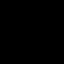
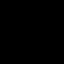
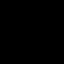

In [ ]:
# Get prompt embeddings from the precomputed cache.
# `prompt_embeds` is of shape [N, 77, 4096]
# 77 comes from the max sequence length that deepfloyd will take
# and 4096 comes from the embedding dimension of the text encoder
# `negative_prompt_embeds` is the same shape as `prompt_embeds` and is used
# for Classifier Free Guidance. You can find out more from:
#   - https://arxiv.org/abs/2207.12598
#   - https://sander.ai/2022/05/26/guidance.html
prompts = [
    'an oil painting of a snowy mountain village',
    'a man wearing a hat',
    "a rocket ship",
]
prompt_embeds = torch.cat([
    prompt_embeds_dict[prompt] for prompt in prompts
], dim=0)
negative_prompt_embeds = torch.cat(
    [prompt_embeds_dict['']] * len(prompts)
)

# Retrieve embeddings, ensuring they exist in the dictionary
#prompt_embeds = torch.cat([prompt_embeds_dict.get(prompt, torch.zeros(1, 77, 4096)) for prompt in prompts], dim=0)
#negative_prompt_embeds = torch.cat([prompt_embeds_dict.get('', torch.zeros(1, 77, 4096))] * len(prompts))

print(prompt_embeds)

# Sample from stage 1
# Outputs a [N, 3, 64, 64] torch tensor
# num_inference_steps is an integer between 1 and 1000, indicating how many
# denoising steps to take: lower is faster, at the cost of reduced quality
stage_1_output = stage_1(
    prompt_embeds=prompt_embeds,
    negative_prompt_embeds=negative_prompt_embeds,
    num_inference_steps=20,
    #num_inference_steps=50,  # Increased steps for better quality
    #guidance_scale=4.0,  # Reduced scale to avoid extreme values
    output_type="pt"
).images


# Sample from stage 2
# Outputs a [N, 3, 256, 256] torch tensor
# num_inference_steps is an integer between 1 and 1000, indicating how many
# denoising steps to take: lower is faster, at the cost of reduced quality
stage_2_output = stage_2(
    image=stage_1_output,
    num_inference_steps=20,
    prompt_embeds=prompt_embeds,
    negative_prompt_embeds=negative_prompt_embeds,
    output_type="pt",
).images

# Display images
# We need to permute the dimensions because `media.show_images` expects
# a tensor of shape [N, H, W, C], but the above stages gives us tensors of
# shape [N, C, H, W]. We also need to normalize from [-1, 1], which is the
# output of the above stages, to [0, 1]
media.show_images(
    stage_1_output.permute(0, 2, 3, 1).cpu() / 2. + 0.5,
    titles=prompts)
media.show_images(
    stage_2_output.permute(0, 2, 3, 1).cpu() / 2. + 0.5,
    titles=prompts)

# 2. Sampling Loops

In this part of the problem set, you will write your own "sampling loop" that uses the pretrained DeepFloyd denoiser. These should produce high quality images such as the ones generated above. You will then modify these sampling loops to solve different tasks such as inpainting.

### Diffusion Models Recap

Starting with a clean image, $x_0$, we can iteratively add noise to an image, obtaining progressively more and more noisy versions of the image, $x_t$, until we're left with basically pure noise at timestep $t=T$. When $t=0$, we have a clean image, and for larger $t$ more noise is in the image.

A diffusion model tries to reverse this process by denoising the image. By giving a diffusion model a noisy $x_t$ and the timestep $t$, the model predicts the noise in the image. With the predicted noise, we can either completely remove the noise from the image, to obtain an estimate of $x_0$, or we can remove just a portion of the noise, obtaining an estimate of $x_{t-1}$, with slightly less noise.

To generate images from the diffusion model (sampling), we start with pure noise at timestep $T$ sampled from a gaussian distribution, which we denote $x_T$. We can then predict and remove part of the noise, giving us $x_{T-1}$. Repeating this process until we arrive at $x_0$ gives us a clean image. For the DeepFloyd models, $t=0...T where T = 1000$.

### Setup

The exact amount of noise added at each step is dictated by noise coefficients, $\bar\alpha_t$, which were chosen by the people who trained DeepFloyd. Run the cell below to create `alphas_cumprod`, which retrieves these coefficients and also downloads a test image that we will work with.

'wget' is not recognized as an internal or external command,
operable program or batch file.


""

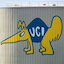

In [8]:
# Get scheduler parameters
alphas_cumprod = stage_1.scheduler.alphas_cumprod

# Get test image
!wget https://ics.uci.edu/~fowlkes/class/cs116/data/zot.jpg -O zot.jpg

# For stage 1: Resize to (64, 64), convert to tensor, rescale to [-1, 1], and
# add a batch dimension. The result is a (1, 3, 64, 64) tensor
test_im = Image.open('zot.jpg').resize((64, 64))
test_im = TF.to_tensor(test_im)
test_im = 2 * test_im - 1
test_im = test_im[None]

# Show test image. I recommend using show_images for the remainder o the assignment.
# The model expects images to have values in the range [-1,1] while show_image expects
# values in the range [0,1] so you will need to convert back and forth frequently.
media.show_image(test_im[0].permute(1,2,0) / 2. + 0.5)

# 2.1 Implementing the forward process [10pts]

**Disclaimer about equations**: Colab cannot correctly render the math equations below. Please cross-reference them with the part A webpage to make sure that you're looking at the fully correct equation.

A key part of diffusion is the forward process, which takes a clean image and adds noise to it. In this part, we will write a function to implement this. The forward process is defined by:

$$ q(x_t | x_0) = N(x_t ; \sqrt{\bar\alpha_t} x_0, (1 - \bar\alpha_t)\mathbf{I})\tag{1}$$

which is equivalent to computing $$ x_t = \sqrt{\bar\alpha_t} x_0 + \sqrt{1 - \bar\alpha_t} \epsilon \quad \text{where}~ \epsilon \sim N(0, 1) \tag{2}$$

That is, given a clean image $x_0$, we get a noisy image $ x_t $ at timestep $t$ by sampling from a Gaussian with mean $ \sqrt{\bar\alpha_t} x_0 $ and variance $ (1 - \bar\alpha_t) $. Note that the forward process is not _just_ adding noise -- we also scale the image.

You will need to use the `alphas_cumprod` variable, which contains the $\bar\alpha_t$ for all $ t \in [0, 999] $. Remember that $t=0$ corresponds to a clean image, and larger $t$ corresponds to more noise. Thus, $\bar\alpha_t$ is close to 1 for small $t$, and close to 0 for large $t$. Run the forward process on the test image with $ t \in [250, 500, 750] $. Show the results -- you should get progressively more noisy images.

### Delivarables

- Implement the `im_noisy = forwardnoise(im, t)` function
- Show the test image at noise level [250, 500, 750]

### Hints

- The `torch.randn_like` function is helpful for creating gaussian noise $\epsilon$ the same size as a given tensor.
- Use the `alphas_cumprod` variable defined, which contains an array of the hyperparameters, with `alphas_cumprod[t]` corresponding to $\bar\alpha_t$.

Timestep 250,Timestep 500,Timestep 750

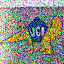
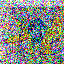
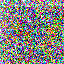

In [15]:
def forwardnoise(im, t):
  alphabar = alphas_cumprod[t]
  noise = torch.randn_like(im)
  im_noisy = torch.sqrt(alphabar) * im + torch.sqrt(1 - alphabar) * noise
  return im_noisy

#test code
todisplay = {}
for t in [250,500,750]:
  im_noisy = forwardnoise(test_im, t)
  todisplay[f"Timestep {t}"] = im_noisy[0].permute(1,2,0) / 2. + 0.5
    
#height,widht specify options to show_images to display the result at a larger dimension 
# in the notebook even thought the image itself is 64x64
media.show_images(todisplay,width=256,height=256)


# 2.2 Classical Denoising by blurring [5pts]

Let's try to denoise these images using classical methods. Again, take noisy images for timesteps [250, 500, 750], but use **Gaussian blur filtering** to try to remove the noise. Getting good results should be quite difficult, if not impossible.

### Deliverables

- For each of the 3 noisy test images from the previous part, show your best Gaussian-denoised version side by side.

### Hint

- `torchvision.transforms.functional.gaussian_blur` is useful. Here is the [documentation](https://pytorch.org/vision/0.16/generated/torchvision.transforms.functional.gaussian_blur.html).

- media.show_images() will take a dict of images and display them in a row where the captions are the keys and the image data is the value ([documentation](https://google.github.io/mediapy/mediapy.html#show_images))


Timestep 250,Blurred 1.0

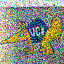
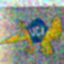

Timestep 500,Blurred 2.0

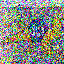
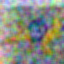

Timestep 750,Blurred 3.0

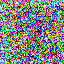
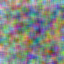

In [10]:
tvals = [250,500,750]
svals = [1.0,2.0,3.0]
for i in range(3):
  t = tvals[i]
  s = svals[i]

  im_noisy = forwardnoise(test_im, t)
  blur = TF.gaussian_blur(im_noisy, kernel_size=[5, 5], sigma=[s, s])

  disp={}
  disp[f"Timestep {t}"] = im_noisy[0].permute(1, 2, 0) / 2. + 0.5  # Noisy image
  disp[f"Blurred {s}"] = blur[0].permute(1, 2, 0) / 2. + 0.5     # Blurred image

  media.show_images(disp,width=256,height=256)

# 2.3 Implementing One Step Denoising [10pts]

Now, we'll use a pretrained diffusion model to denoise. The actual denoiser can be found at `stage_1.unet`. This is a UNet that has already been trained on a *very, very* large dataset of $(x_0, x_t)$ pairs of images. We can use it to recover Gaussian noise from the image. Then, we can remove this noise to recover (something close to) the original image. Note: this UNet is conditioned on the amount of Gaussian noise by taking timestep $t$ as additional input.



Because this diffusion model was trained with text conditioning, we also need a text prompt embedding. We provide the embedding for the prompt `"a high quality photo"` for you to use. Later on, you can use your own text prompts.

### Deliverables
For each of the 3 noisy images from 2.2 (wheree t = [250, 500, 750]) we will denoise the image by using the UNet to estimate the noise.
- Estimate the noise in the new noisy image, by passing it through `stage_1.unet`
- Remove the noise from the noisy image to obtain an estimate of the original image.
- Visualize the original image, the noisy image, and the estimate of the original image

### Hints
- When removing the noise, you can't simply subtract the noise estimate. Recall that in equation 2 (above) the noise and $x_0$ are scaled. You will need to look at equation 2 to figure out how we can predict $x_0$ based on the noise estimate, $x_t$, and $t$.
- You will probably have to wrangle tensors to the correct device and into the correct data types. The functions `.to(device)` and `.half()` will be useful. The denoiser is loaded as `half` precision (to save memory), so inputs to the denoiser will also need to be `half` precision.
- The signature for the unet is `stage_1.unet(image, t, encoder_hidden_states=prompt_embeds, return_dict=False)`. You need to pass in the noisy image, the timestep, and the prompt embeddings. The `return_dict` argument just makes the output nicer.
- The unet will output a tensor of shape (1, 6, 64, 64). This is because DeepFloyd was trained to predict the noise as well as variance of the noise. The first 3 channels is the noise estimate, which you will use. The second 3 channels is the variance estimate which you may ignore for now.
- To save GPU memory, you should wrap all of your code in a `with torch.no_grad():` context. This tells torch not to do automatic differentiation (since we aren't training the model), so this saves a considerable amount of memory.

Original,Noisy 250,Noise Estimate,DeNoised

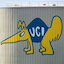
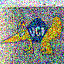
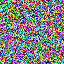
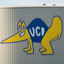

Original,Noisy 500,Noise Estimate,DeNoised

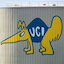
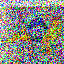
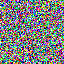
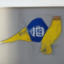

Original,Noisy 750,Noise Estimate,DeNoised

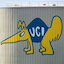
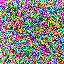
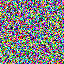
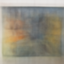

In [11]:
# Please use this prompt embedding
prompt_embeds = prompt_embeds_dict["a high quality photo"]

with torch.no_grad():
  tvals = [250,500,750]
  for i in [0,1,2]:
    t = tvals[i]
    alphabar = alphas_cumprod[t]

    # Run forward process
    im_noisy = forwardnoise(test_im, t)

    # Estimate noise in noisy image
    noise_est = stage_1.unet(
        im_noisy.half().to(device),
        t,
        encoder_hidden_states=prompt_embeds,
        return_dict=False
    )[0]

    # Take only first 3 channels, and move result to cpu
    noise_est = noise_est[:, :3].cpu()

    # Remove the noise
    clean_est = (im_noisy.cpu() - torch.sqrt(1 - alphabar) * noise_est) / torch.sqrt(alphabar)

    disp={}
    disp["Original"] = test_im[0].permute(1,2,0)/2.+0.5
    disp[f"Noisy {t}"] = im_noisy[0].permute(1, 2, 0) / 2. + 0.5  # Noisy image
    disp["Noise Estimate"] = noise_est[0].permute(1, 2, 0) / 2. + 0.5  # Noise estimate
    disp["DeNoised"] = clean_est[0].permute(1, 2, 0) / 2. + 0.5  # Denoised image
    media.show_images(disp,width=256,height=256)


# [Optional] Upsampling Images

If you want to upsample your $64\times 64$ images to $256 \times 256$, you can use the following code:

# 2. Iterative Denoising

In comparing 2.2 and 2.3, you should have observed that the denoising UNet does a much better job of projecting the image onto the natural image manifold than gaussian blur. However, predictions still get worse as you add more noise since the problem is much more diicult with high levels of noise! Diffusion models perform much better if we only ask them to do a small amount of denoising and iterate to handle larger noise levels.

In theory, we could start with noise $x_{1000}$ at timestep $T=1000$, denoise for only one time step to get an estimate of $x_{999}$, and repeat until we get $x_0$. However, this would require running the diffusion model 1000 times, which is quite slow (and costs $$$ and energy).

It turns out, we can actually speed things up by skipping steps. The rationale for why this is possible is due to a connection with differential equations. It's a bit out of scope for this course, but if you're interested you can check out [this excellent article](https://yang-song.net/blog/2021/score/) to develop a deeper understanding.

To skip steps we can create a list of timesteps that we'll call `strided_timesteps`, which will be much shorter than the full list of 1000 timesteps. `strided_timesteps[0]` will correspond to the noisiest image (and thus the largest $t$) and `strided_timesteps[-1]` will correspond to a clean image (and thus $t = 0$). One simple way of constructing this list is by introducing a regular stride step (e.g. stride of 30 works well).

On the `i`th denoising step we are at $ t = $ `strided_timesteps[i]`, and want to get to $ t' =$ `strided_timesteps[i+1]` (from more noisy to less noisy). To compute this, we will use the following formula:

$\Large x_{t'} = \frac{\sqrt{\bar\alpha_{t'}}(1-\alpha_t)}{1 - \bar\alpha_t} x_0 + \frac{\sqrt{\alpha_t}(1 - \bar\alpha_{t'})}{1 - \bar\alpha_t} x_t + \sigma(t)\epsilon$

where:
- $x_t$ is the image at timestep $t$
- $x_{t'}$ is the less noisy image at timestep $t'$ where $t' < t$ (less noisy)
- $\bar\alpha_t$ is listed in the `alphas_cumprod` array, as mentioned above.
- $\alpha_t = \bar\alpha_t / \bar\alpha_{t'}$ (if we know the cummulative product for every $t$ we can figure out $\alpha_t$ for the step from $t$ to $t'$
- $x_0$ is our current estimate of the clean image using equation 2 in the earlier section
- If you are referring to the DDPM paper, remember that $\beta_t = 1 - \alpha_t$


The $\sigma(t)\epsilon$ is random noise.  This could just be set based on $\beta_t$ but in the case of DeepFloyd this is also learned during training and provided as a prediction from the model. The process to compute this is not very important for us, so a function, `add_variance`, has been provided which will add this term for you.


It may be useul to think of this as a linear interpolation between the signal we want to recover $x_0$ and noisy version $x_t$ but with some noise added back in. For more details, see equations 6 and 7 of the [DDPM paper](https://arxiv.org/pdf/2006.11239). Be careful to distinguish the alpha bars from the alphas! 



# 2.1 Iterative Denoising Implementation [15pts]
First create the list `strided_timesteps`. You should start at timestep 990, and take step sizes of size 30 until you arrive at 0. After completing the problem set, feel free to go back try different "schedules" of timesteps.

Then implement the function `iterative_denoise(image, i_start)`, which takes a noisy image `image`, as well as a starting index `i_start`. The function should denoise an image starting at timestep `t = timestep[i_start]`, applying the above formula to obtain an image at the earlier time `t' = timestep[i_start + 1]`, and repeat iteratively until we arrive at a clean image.

Add noise to the test image `im` to using your forward function with `t=timestep[10]` and display this noisy image. Then run the `iterative_denoise` function on the noisy image, with `i_start = 10`, to obtain a clean image and display it. Please display every 5th image of the denoising loop. Compare this to the "one-step" denoising method from the previous section.

### Deliverables
Using `i_start = 10`:
- Create `strided_timesteps`: a list of monotonically decreasing timesteps, starting at 990, with a stride of 30, eventually reaching 0. Also initialize the timesteps using the function `stage_1.scheduler.set_timesteps(timesteps=strided_timesteps)`
- Complete the `iterative_denoise` function
- Show the noisy image every 5th loop of denoising (it should gradually become less noisy)
- Show the final predicted clean image after the iterative denoising has completed
- Also show the predicted clean image using only a single large denoising step, as was done in the previous part. This should look much worse.

### Hints

- Remember, the unet will output a tensor of shape (1, 6, 64, 64). This is because DeepFloyd was trained to predict the noise as well as variance of the noise. The first 3 channels is the noise estimate, which you will use here. The second 3 channels is the variance estimate which you will pass to the `add_variance` function
- Read the documentation for the `add_variance` function to figure out how to use it to add the $\sigma(t)\epsilon$ to the image.
- Depending on if your final images are torch tensors or numpy arrays, you may need to modify the `show_images` call a bit.

In [16]:
def add_variance(predicted_variance, t, image):
  '''
  Args:
    predicted_variance : (1, 3, 64, 64) tensor, last three channels of the UNet output
    t: scale tensor indicating timestep
    image : (1, 3, 64, 64) tensor, noisy image

  Returns:
    (1, 3, 64, 64) tensor, image with the correct amount of variance added
  '''
  # chekc for device
  t = t.to(stage_1.scheduler.timesteps.device)

  # Add learned variance
  variance = stage_1.scheduler._get_variance(t, predicted_variance=predicted_variance)
  variance_noise = torch.randn_like(image)
  variance = torch.exp(0.5 * variance) * variance_noise

  # Clip the variance to prevent extreme values
  variance = torch.clamp(variance, -1.0, 1.0)

  return image + variance

In [17]:
# Make timesteps. Must be list of ints satisfying:
# - monotonically decreasing
# - ends at 0
# - begins close to or at 999

# create `strided_timesteps`, a list of timesteps, from 990 to 0 in steps of 30
strided_timesteps = list(range(990, -1, -30)) 

# if necessary, force the last entry to be 0
if strided_timesteps[-1] != 0:
    strided_timesteps.append(0)

# ==== end of code ====

stage_1.scheduler.set_timesteps(timesteps=strided_timesteps)    # Need this for the variance computation to behave
print(strided_timesteps)

[990, 960, 930, 900, 870, 840, 810, 780, 750, 720, 690, 660, 630, 600, 570, 540, 510, 480, 450, 420, 390, 360, 330, 300, 270, 240, 210, 180, 150, 120, 90, 60, 30, 0]


Now to implement your iterative denoising process

In [18]:
def iterative_denoise(image, i_start, prompt_embeds, timesteps, display=True):
  with torch.no_grad():
    #tqdm will display a progress bar while running our for-loop
    for i in tqdm(range(i_start, len(timesteps) - 1),"iterative denoising"):

      image = image.half()
      # Get timesteps.
      # Since timesteps goes from T down to 0, prev_t will be less than t

      t = torch.tensor([timesteps[i]], device=image.device, dtype=torch.long)
      prev_t = torch.tensor([timesteps[i+1]], device=image.device, dtype=torch.long)
      #print("time:",t," ",prev_t)

      print(f"Timestep t: {t.item()}, Prev Timestep: {prev_t.item()}")

      # Ensure alphas_cumprod is on the same device
      #alphas_cumprod = stage_1.scheduler.alphas_cumprod.to(image.device)

      # TODO:
      # get alpha_bar and alpha_bar_prev for timestep t from alphas_cumprod
      # compute alpha

      alpha_bar = stage_1.scheduler.alphas_cumprod[t.item()]
      alpha_bar_prev = stage_1.scheduler.alphas_cumprod[prev_t.item()]
      alpha = alpha_bar / alpha_bar_prev

      print(f"Alpha Bar: {alpha_bar}, Alpha Bar Prev: {alpha_bar_prev}, Alpha: {alpha}")

      print("Image dtype:", image.dtype)  # Should be torch.float16
      print("Timesteps dtype:", t.dtype)  # Should be torch.float16
      print("Prompt embeds dtype:", prompt_embeds.dtype)

      # ==== end of code ====

      # Get noise estimate
      model_output = stage_1.unet(
          image.half(),
          t,
          encoder_hidden_states=prompt_embeds,
          return_dict=False
      )[0]

      print("Model Output Shape:", model_output.shape)
      print("Model Output Min/Max:", model_output.min().item(), model_output.max().item())


      # Split estimate into noise and variance estimate
      noise_est, predicted_variance = torch.split(model_output, image.shape[1], dim=1)

      # Scale the noise estimate to prevent extreme values
      noise_est = torch.clamp(noise_est, -3.0, 3.0)


      print("Noise Est Min/Max:", noise_est.min().item(), noise_est.max().item())
      print("Predicted Variance Min/Max:", predicted_variance.min().item(), predicted_variance.max().item())

      # ===== your code here! =====

      x_0 = (image - (1 - alpha_bar).sqrt() * noise_est) / alpha_bar.sqrt() #predict x_0 from the noise_est and x_t
      pred_prev_image = (image - (1 - alpha_bar).sqrt() * noise_est) / alpha_bar.sqrt()

      print("Noise Est Shape:", noise_est.shape)
      print("Predicted Variance Shape:", predicted_variance.shape)
       # Add variance
      pred_prev_image = add_variance(predicted_variance, prev_t, pred_prev_image)

      # Clip the predicted previous image to prevent extreme values
      pred_prev_image = torch.clamp(pred_prev_image, -1.0, 1.0)

      print("Pred Prev Image Min/Max:", pred_prev_image.min().item(), pred_prev_image.max().item())

      # display intermeidate results. Remember that you will need to use .cpu()
      # to move tensors back to the cpu for display and permute/scale them
      if display and (i - i_start) % 5 == 0:
                disp = {}
                disp[f"Timestep {t}"] = pred_prev_image[0].cpu().permute(1, 2, 0) / 2. + 0.5
                media.show_images(disp, width=256, height=256)


      # ==== end of code ====

      image = pred_prev_image

  clean = image.cpu().detach()

  return clean

iterative denoising:   0%|          | 0/23 [00:00<?, ?it/s]

Timestep t: 690, Prev Timestep: 660
Alpha Bar: 0.21452300250530243, Alpha Bar Prev: 0.2540990114212036, Alpha: 0.8442496657371521
Image dtype: torch.float16
Timesteps dtype: torch.int64
Prompt embeds dtype: torch.float16
Model Output Shape: torch.Size([1, 6, 64, 64])
Model Output Min/Max: -4.47265625 3.939453125
Noise Est Min/Max: -3.0 3.0
Predicted Variance Min/Max: -1.146484375 -0.716796875
Noise Est Shape: torch.Size([1, 3, 64, 64])
Predicted Variance Shape: torch.Size([1, 3, 64, 64])
Pred Prev Image Min/Max: -1.0 1.0


"Timestep tensor([690], device='cuda:0')"

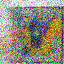

iterative denoising:   4%|▍         | 1/23 [00:01<00:42,  1.94s/it]

Timestep t: 660, Prev Timestep: 630
Alpha Bar: 0.2540990114212036, Alpha Bar Prev: 0.2958238124847412, Alpha: 0.8589538931846619
Image dtype: torch.float16
Timesteps dtype: torch.int64
Prompt embeds dtype: torch.float16
Model Output Shape: torch.Size([1, 6, 64, 64])


iterative denoising:   9%|▊         | 2/23 [00:03<00:35,  1.67s/it]

Model Output Min/Max: -1.1171875 1.3662109375
Noise Est Min/Max: -1.11328125 1.3662109375
Predicted Variance Min/Max: -1.1171875 -0.54296875
Noise Est Shape: torch.Size([1, 3, 64, 64])
Predicted Variance Shape: torch.Size([1, 3, 64, 64])
Pred Prev Image Min/Max: -1.0 1.0
Timestep t: 630, Prev Timestep: 600
Alpha Bar: 0.2958238124847412, Alpha Bar Prev: 0.3393329381942749, Alpha: 0.8717803955078125
Image dtype: torch.float16
Timesteps dtype: torch.int64
Prompt embeds dtype: torch.float16
Model Output Shape: torch.Size([1, 6, 64, 64])


iterative denoising:  13%|█▎        | 3/23 [00:04<00:31,  1.58s/it]

Model Output Min/Max: -1.220703125 1.23828125
Noise Est Min/Max: -1.220703125 1.23828125
Predicted Variance Min/Max: -1.166015625 -0.57861328125
Noise Est Shape: torch.Size([1, 3, 64, 64])
Predicted Variance Shape: torch.Size([1, 3, 64, 64])
Pred Prev Image Min/Max: -1.0 1.0
Timestep t: 600, Prev Timestep: 570
Alpha Bar: 0.3393329381942749, Alpha Bar Prev: 0.3842463195323944, Alpha: 0.8831130266189575
Image dtype: torch.float16
Timesteps dtype: torch.int64
Prompt embeds dtype: torch.float16
Model Output Shape: torch.Size([1, 6, 64, 64])


iterative denoising:  17%|█▋        | 4/23 [00:06<00:29,  1.54s/it]

Model Output Min/Max: -1.2734375 1.2431640625
Noise Est Min/Max: -1.2392578125 1.2431640625
Predicted Variance Min/Max: -1.2734375 -0.62646484375
Noise Est Shape: torch.Size([1, 3, 64, 64])
Predicted Variance Shape: torch.Size([1, 3, 64, 64])
Pred Prev Image Min/Max: -1.0 1.0
Timestep t: 570, Prev Timestep: 540
Alpha Bar: 0.3842463195323944, Alpha Bar Prev: 0.4301716089248657, Alpha: 0.8932396173477173
Image dtype: torch.float16
Timesteps dtype: torch.int64
Prompt embeds dtype: torch.float16
Model Output Shape: torch.Size([1, 6, 64, 64])


iterative denoising:  22%|██▏       | 5/23 [00:07<00:26,  1.49s/it]

Model Output Min/Max: -1.3505859375 1.2607421875
Noise Est Min/Max: -1.162109375 1.2607421875
Predicted Variance Min/Max: -1.3505859375 -0.65185546875
Noise Est Shape: torch.Size([1, 3, 64, 64])
Predicted Variance Shape: torch.Size([1, 3, 64, 64])
Pred Prev Image Min/Max: -1.0 1.0
Timestep t: 540, Prev Timestep: 510
Alpha Bar: 0.4301716089248657, Alpha Bar Prev: 0.4767075181007385, Alpha: 0.9023805856704712
Image dtype: torch.float16
Timesteps dtype: torch.int64
Prompt embeds dtype: torch.float16
Model Output Shape: torch.Size([1, 6, 64, 64])
Model Output Min/Max: -1.38671875 1.4306640625
Noise Est Min/Max: -1.38671875 1.4306640625
Predicted Variance Min/Max: -1.3681640625 -0.73193359375
Noise Est Shape: torch.Size([1, 3, 64, 64])
Predicted Variance Shape: torch.Size([1, 3, 64, 64])
Pred Prev Image Min/Max: -1.0 1.0


"Timestep tensor([540], device='cuda:0')"

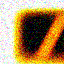

iterative denoising:  26%|██▌       | 6/23 [00:09<00:25,  1.48s/it]

Timestep t: 510, Prev Timestep: 480
Alpha Bar: 0.4767075181007385, Alpha Bar Prev: 0.523447573184967, Alpha: 0.9107072949409485
Image dtype: torch.float16
Timesteps dtype: torch.int64
Prompt embeds dtype: torch.float16
Model Output Shape: torch.Size([1, 6, 64, 64])


iterative denoising:  30%|███       | 7/23 [00:10<00:24,  1.50s/it]

Model Output Min/Max: -1.3671875 1.3349609375
Noise Est Min/Max: -1.2412109375 1.3349609375
Predicted Variance Min/Max: -1.3671875 -0.6240234375
Noise Est Shape: torch.Size([1, 3, 64, 64])
Predicted Variance Shape: torch.Size([1, 3, 64, 64])
Pred Prev Image Min/Max: -1.0 1.0
Timestep t: 480, Prev Timestep: 450
Alpha Bar: 0.523447573184967, Alpha Bar Prev: 0.5699834823608398, Alpha: 0.9183557033538818
Image dtype: torch.float16
Timesteps dtype: torch.int64
Prompt embeds dtype: torch.float16
Model Output Shape: torch.Size([1, 6, 64, 64])


iterative denoising:  35%|███▍      | 8/23 [00:12<00:22,  1.49s/it]

Model Output Min/Max: -1.392578125 1.2080078125
Noise Est Min/Max: -1.365234375 1.2080078125
Predicted Variance Min/Max: -1.392578125 -0.57080078125
Noise Est Shape: torch.Size([1, 3, 64, 64])
Predicted Variance Shape: torch.Size([1, 3, 64, 64])
Pred Prev Image Min/Max: -1.0 1.0
Timestep t: 450, Prev Timestep: 420
Alpha Bar: 0.5699834823608398, Alpha Bar Prev: 0.6159088611602783, Alpha: 0.9254347681999207
Image dtype: torch.float16
Timesteps dtype: torch.int64
Prompt embeds dtype: torch.float16
Model Output Shape: torch.Size([1, 6, 64, 64])


iterative denoising:  39%|███▉      | 9/23 [00:13<00:20,  1.48s/it]

Model Output Min/Max: -1.40625 1.3369140625
Noise Est Min/Max: -1.2060546875 1.3369140625
Predicted Variance Min/Max: -1.40625 -0.53271484375
Noise Est Shape: torch.Size([1, 3, 64, 64])
Predicted Variance Shape: torch.Size([1, 3, 64, 64])
Pred Prev Image Min/Max: -1.0 1.0
Timestep t: 420, Prev Timestep: 390
Alpha Bar: 0.6159088611602783, Alpha Bar Prev: 0.6608222723007202, Alpha: 0.9320340752601624
Image dtype: torch.float16
Timesteps dtype: torch.int64
Prompt embeds dtype: torch.float16
Model Output Shape: torch.Size([1, 6, 64, 64])


iterative denoising:  43%|████▎     | 10/23 [00:15<00:19,  1.52s/it]

Model Output Min/Max: -1.3515625 1.1982421875
Noise Est Min/Max: -1.2431640625 1.1982421875
Predicted Variance Min/Max: -1.3515625 -0.4580078125
Noise Est Shape: torch.Size([1, 3, 64, 64])
Predicted Variance Shape: torch.Size([1, 3, 64, 64])
Pred Prev Image Min/Max: -1.0 1.0
Timestep t: 390, Prev Timestep: 360
Alpha Bar: 0.6608222723007202, Alpha Bar Prev: 0.704331636428833, Alpha: 0.938226044178009
Image dtype: torch.float16
Timesteps dtype: torch.int64
Prompt embeds dtype: torch.float16
Model Output Shape: torch.Size([1, 6, 64, 64])
Model Output Min/Max: -1.3486328125 1.306640625
Noise Est Min/Max: -1.3447265625 1.306640625
Predicted Variance Min/Max: -1.3486328125 -0.46875
Noise Est Shape: torch.Size([1, 3, 64, 64])
Predicted Variance Shape: torch.Size([1, 3, 64, 64])
Pred Prev Image Min/Max: -1.0 1.0


"Timestep tensor([390], device='cuda:0')"

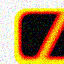

iterative denoising:  48%|████▊     | 11/23 [00:16<00:18,  1.53s/it]

Timestep t: 360, Prev Timestep: 330
Alpha Bar: 0.704331636428833, Alpha Bar Prev: 0.7460564374923706, Alpha: 0.9440728425979614
Image dtype: torch.float16
Timesteps dtype: torch.int64
Prompt embeds dtype: torch.float16
Model Output Shape: torch.Size([1, 6, 64, 64])


iterative denoising:  52%|█████▏    | 12/23 [00:18<00:16,  1.51s/it]

Model Output Min/Max: -1.34375 1.4296875
Noise Est Min/Max: -1.2158203125 1.4296875
Predicted Variance Min/Max: -1.34375 -0.45458984375
Noise Est Shape: torch.Size([1, 3, 64, 64])
Predicted Variance Shape: torch.Size([1, 3, 64, 64])
Pred Prev Image Min/Max: -1.0 1.0
Timestep t: 330, Prev Timestep: 300
Alpha Bar: 0.7460564374923706, Alpha Bar Prev: 0.7856324315071106, Alpha: 0.9496253132820129
Image dtype: torch.float16
Timesteps dtype: torch.int64
Prompt embeds dtype: torch.float16
Model Output Shape: torch.Size([1, 6, 64, 64])


iterative denoising:  57%|█████▋    | 13/23 [00:19<00:15,  1.50s/it]

Model Output Min/Max: -1.341796875 1.3515625
Noise Est Min/Max: -1.310546875 1.3515625
Predicted Variance Min/Max: -1.341796875 -0.40087890625
Noise Est Shape: torch.Size([1, 3, 64, 64])
Predicted Variance Shape: torch.Size([1, 3, 64, 64])
Pred Prev Image Min/Max: -1.0 1.0
Timestep t: 300, Prev Timestep: 270
Alpha Bar: 0.7856324315071106, Alpha Bar Prev: 0.8227139711380005, Alpha: 0.9549278020858765
Image dtype: torch.float16
Timesteps dtype: torch.int64
Prompt embeds dtype: torch.float16
Model Output Shape: torch.Size([1, 6, 64, 64])


iterative denoising:  61%|██████    | 14/23 [00:21<00:13,  1.49s/it]

Model Output Min/Max: -1.365234375 1.208984375
Noise Est Min/Max: -1.2236328125 1.208984375
Predicted Variance Min/Max: -1.365234375 -0.399169921875
Noise Est Shape: torch.Size([1, 3, 64, 64])
Predicted Variance Shape: torch.Size([1, 3, 64, 64])
Pred Prev Image Min/Max: -1.0 1.0
Timestep t: 270, Prev Timestep: 240
Alpha Bar: 0.8227139711380005, Alpha Bar Prev: 0.8569768071174622, Alpha: 0.9600189328193665
Image dtype: torch.float16
Timesteps dtype: torch.int64
Prompt embeds dtype: torch.float16
Model Output Shape: torch.Size([1, 6, 64, 64])


iterative denoising:  65%|██████▌   | 15/23 [00:22<00:11,  1.48s/it]

Model Output Min/Max: -1.3359375 1.291015625
Noise Est Min/Max: -1.3330078125 1.291015625
Predicted Variance Min/Max: -1.3359375 -0.36328125
Noise Est Shape: torch.Size([1, 3, 64, 64])
Predicted Variance Shape: torch.Size([1, 3, 64, 64])
Pred Prev Image Min/Max: -1.0 1.0
Timestep t: 240, Prev Timestep: 210
Alpha Bar: 0.8569768071174622, Alpha Bar Prev: 0.8881219625473022, Alpha: 0.9649314284324646
Image dtype: torch.float16
Timesteps dtype: torch.int64
Prompt embeds dtype: torch.float16
Model Output Shape: torch.Size([1, 6, 64, 64])
Model Output Min/Max: -1.525390625 1.33203125
Noise Est Min/Max: -1.525390625 1.33203125
Predicted Variance Min/Max: -1.345703125 -0.39794921875
Noise Est Shape: torch.Size([1, 3, 64, 64])
Predicted Variance Shape: torch.Size([1, 3, 64, 64])
Pred Prev Image Min/Max: -1.0 1.0


"Timestep tensor([240], device='cuda:0')"

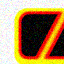

iterative denoising:  70%|██████▉   | 16/23 [00:24<00:10,  1.50s/it]

Timestep t: 210, Prev Timestep: 180
Alpha Bar: 0.8881219625473022, Alpha Bar Prev: 0.9158772230148315, Alpha: 0.9696954488754272
Image dtype: torch.float16
Timesteps dtype: torch.int64
Prompt embeds dtype: torch.float16
Model Output Shape: torch.Size([1, 6, 64, 64])


iterative denoising:  74%|███████▍  | 17/23 [00:25<00:08,  1.49s/it]

Model Output Min/Max: -1.53125 1.99609375
Noise Est Min/Max: -1.53125 1.99609375
Predicted Variance Min/Max: -1.3515625 -0.380859375
Noise Est Shape: torch.Size([1, 3, 64, 64])
Predicted Variance Shape: torch.Size([1, 3, 64, 64])
Pred Prev Image Min/Max: -1.0 1.0
Timestep t: 180, Prev Timestep: 150
Alpha Bar: 0.9158772230148315, Alpha Bar Prev: 0.9399999976158142, Alpha: 0.9743374586105347
Image dtype: torch.float16
Timesteps dtype: torch.int64
Prompt embeds dtype: torch.float16
Model Output Shape: torch.Size([1, 6, 64, 64])


iterative denoising:  78%|███████▊  | 18/23 [00:27<00:07,  1.47s/it]

Model Output Min/Max: -1.544921875 1.7109375
Noise Est Min/Max: -1.544921875 1.7109375
Predicted Variance Min/Max: -1.3671875 -0.355224609375
Noise Est Shape: torch.Size([1, 3, 64, 64])
Predicted Variance Shape: torch.Size([1, 3, 64, 64])
Pred Prev Image Min/Max: -1.0 1.0
Timestep t: 150, Prev Timestep: 120
Alpha Bar: 0.9399999976158142, Alpha Bar Prev: 0.9602797627449036, Alpha: 0.9788814187049866
Image dtype: torch.float16
Timesteps dtype: torch.int64
Prompt embeds dtype: torch.float16
Model Output Shape: torch.Size([1, 6, 64, 64])


iterative denoising:  83%|████████▎ | 19/23 [00:28<00:05,  1.46s/it]

Model Output Min/Max: -1.5859375 1.431640625
Noise Est Min/Max: -1.5859375 1.431640625
Predicted Variance Min/Max: -1.34765625 -0.255859375
Noise Est Shape: torch.Size([1, 3, 64, 64])
Predicted Variance Shape: torch.Size([1, 3, 64, 64])
Pred Prev Image Min/Max: -1.0 1.0
Timestep t: 120, Prev Timestep: 90
Alpha Bar: 0.9602797627449036, Alpha Bar Prev: 0.9765393137931824, Alpha: 0.9833498001098633
Image dtype: torch.float16
Timesteps dtype: torch.int64
Prompt embeds dtype: torch.float16
Model Output Shape: torch.Size([1, 6, 64, 64])


iterative denoising:  87%|████████▋ | 20/23 [00:30<00:04,  1.46s/it]

Model Output Min/Max: -1.736328125 2.12890625
Noise Est Min/Max: -1.736328125 2.12890625
Predicted Variance Min/Max: -1.4013671875 -0.1005859375
Noise Est Shape: torch.Size([1, 3, 64, 64])
Predicted Variance Shape: torch.Size([1, 3, 64, 64])
Pred Prev Image Min/Max: -1.0 1.0
Timestep t: 90, Prev Timestep: 60
Alpha Bar: 0.9765393137931824, Alpha Bar Prev: 0.9886365532875061, Alpha: 0.9877637028694153
Image dtype: torch.float16
Timesteps dtype: torch.int64
Prompt embeds dtype: torch.float16
Model Output Shape: torch.Size([1, 6, 64, 64])
Model Output Min/Max: -1.7265625 1.822265625
Noise Est Min/Max: -1.7265625 1.822265625
Predicted Variance Min/Max: -1.4287109375 0.01953125
Noise Est Shape: torch.Size([1, 3, 64, 64])
Predicted Variance Shape: torch.Size([1, 3, 64, 64])
Pred Prev Image Min/Max: -1.0 1.0


"Timestep tensor([90], device='cuda:0')"

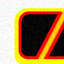

iterative denoising:  91%|█████████▏| 21/23 [00:31<00:02,  1.46s/it]

Timestep t: 60, Prev Timestep: 30
Alpha Bar: 0.9886365532875061, Alpha Bar Prev: 0.9964657425880432, Alpha: 0.9921430349349976
Image dtype: torch.float16
Timesteps dtype: torch.int64
Prompt embeds dtype: torch.float16
Model Output Shape: torch.Size([1, 6, 64, 64])


iterative denoising:  96%|█████████▌| 22/23 [00:32<00:01,  1.46s/it]

Model Output Min/Max: -1.6552734375 1.7890625
Noise Est Min/Max: -1.6552734375 1.7890625
Predicted Variance Min/Max: -1.41015625 0.1533203125
Noise Est Shape: torch.Size([1, 3, 64, 64])
Predicted Variance Shape: torch.Size([1, 3, 64, 64])
Pred Prev Image Min/Max: -1.0 1.0
Timestep t: 30, Prev Timestep: 0
Alpha Bar: 0.9964657425880432, Alpha Bar Prev: 0.9999586939811707, Alpha: 0.996506929397583
Image dtype: torch.float16
Timesteps dtype: torch.int64
Prompt embeds dtype: torch.float16
Model Output Shape: torch.Size([1, 6, 64, 64])


iterative denoising: 100%|██████████| 23/23 [00:34<00:00,  1.50s/it]

Model Output Min/Max: -1.384765625 1.123046875
Noise Est Min/Max: -0.78076171875 1.123046875
Predicted Variance Min/Max: -1.384765625 0.3310546875
Noise Est Shape: torch.Size([1, 3, 64, 64])
Predicted Variance Shape: torch.Size([1, 3, 64, 64])
Pred Prev Image Min/Max: -1.0 1.0


Original,Noisy 690,One Step,Iterative

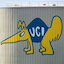
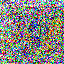
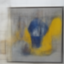
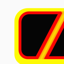

In [19]:
## run your experiments

# please use this prompt embedding for all experiments
prompt_embeds = prompt_embeds_dict["a high quality photo"]

# make it to 16
prompt_embeds = prompt_embeds.half()

# Load image
image_path = "zot.jpg"  # Ensure this file is uploaded to Colab
image = Image.open(image_path).convert("RGB")

# Transform the image to match the expected tensor format
transform = transforms.Compose([
    transforms.Resize((64, 64)),  # Resize to match the model input size
    transforms.ToTensor(),  # Convert to tensor (C, H, W) and normalize to [0,1]
    transforms.Normalize(0.5, 0.5)  # Normalize to [-1,1] (expected range for diffusion models)
])

test_im = transform(image).unsqueeze(0).to(device)
test_im = test_im.half()


# Add noise
i_start = 10
#t = strided_timesteps[i_start]

# Add noise to test image
t = torch.tensor([strided_timesteps[i_start]], device=test_im.device)

# Prepare the test image

im_noisy =  stage_1.scheduler.add_noise(test_im, noise=torch.randn_like(test_im), timesteps=t)

im_noisy = im_noisy.half()  # Ensure float16

# Iterative denoise
clean = iterative_denoise(im_noisy.to(device),i_start=i_start,prompt_embeds=prompt_embeds,timesteps=strided_timesteps)

# One step denoise... as implemented previously
# ===== your code here! =====
# One-step denoising
model_output = stage_1.unet(im_noisy, t, encoder_hidden_states=prompt_embeds, return_dict=False)[0]

noise_est, _ = torch.split(model_output, im_noisy.shape[1], dim=1)
clean_one_step = (im_noisy - torch.sqrt(1 - stage_1.scheduler.alphas_cumprod[t].view(-1, 1, 1, 1)) * noise_est) / torch.sqrt(stage_1.scheduler.alphas_cumprod[t].view(-1, 1, 1, 1))
clean_one_step = clean_one_step.detach()

# ==== end of code ====


disp = {
    "Original": test_im[0].cpu().permute(1, 2, 0).numpy() / 2. + 0.5,
    f"Noisy {t.item()}": im_noisy[0].cpu().permute(1, 2, 0).numpy() / 2. + 0.5,
    "One Step": clean_one_step[0].cpu().permute(1, 2, 0).numpy() / 2. + 0.5,
    "Iterative": clean[0].cpu().permute(1, 2, 0).numpy() / 2. + 0.5,
}
media.show_images(disp, width=256, height=256)


# 2.2 Image generation by denoising pure noise [5pts]

In part 2, we used the diffusion model to denoise an image. Another thing we can do with the `iterative_denoise` function is to generate images from scratch. We can do this by setting `i_start = 0` and passing in random noise. This effectively denoises pure noise. Give this a try and show 5 results of `"a high quality photo"`.

### Deliverables

- Show 5 sampled images

### Hints

- Use `torch.randn` to make the noise.
- Make sure you move the tensor to the correct device and correct data type by calling `.half()` and `.to(device)`.
- The quality of the images will not be spectacular, but should be reasonable images. We will improve on this in the next step.

iterative denoising:   0%|          | 0/33 [00:00<?, ?it/s]

Timestep t: 990, Prev Timestep: 960
Alpha Bar: 0.00019671733025461435, Alpha Bar Prev: 0.0036896108649671078, Alpha: 0.05331655219197273
Image dtype: torch.float16
Timesteps dtype: torch.int64
Prompt embeds dtype: torch.float16
Model Output Shape: torch.Size([1, 6, 64, 64])
Model Output Min/Max: -3.96875 3.720703125
Noise Est Min/Max: -3.0 3.0
Predicted Variance Min/Max: -1.271484375 -0.64794921875
Noise Est Shape: torch.Size([1, 3, 64, 64])
Predicted Variance Shape: torch.Size([1, 3, 64, 64])
Pred Prev Image Min/Max: -1.0 1.0


"Timestep tensor([990], device='cuda:0')"

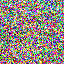

iterative denoising:   3%|▎         | 1/33 [00:02<01:25,  2.67s/it]

Timestep t: 960, Prev Timestep: 930
Alpha Bar: 0.0036896108649671078, Alpha Bar Prev: 0.01151887234300375, Alpha: 0.3203100860118866
Image dtype: torch.float16
Timesteps dtype: torch.int64
Prompt embeds dtype: torch.float16
Model Output Shape: torch.Size([1, 6, 64, 64])


iterative denoising:   6%|▌         | 2/33 [00:05<01:17,  2.50s/it]

Model Output Min/Max: -1.2392578125 1.01953125
Noise Est Min/Max: -1.0556640625 1.01953125
Predicted Variance Min/Max: -1.2392578125 -0.7744140625
Noise Est Shape: torch.Size([1, 3, 64, 64])
Predicted Variance Shape: torch.Size([1, 3, 64, 64])
Pred Prev Image Min/Max: -1.0 1.0
Timestep t: 930, Prev Timestep: 900
Alpha Bar: 0.01151887234300375, Alpha Bar Prev: 0.023616107180714607, Alpha: 0.4877549111843109
Image dtype: torch.float16
Timesteps dtype: torch.int64
Prompt embeds dtype: torch.float16
Model Output Shape: torch.Size([1, 6, 64, 64])


iterative denoising:   9%|▉         | 3/33 [00:06<01:03,  2.12s/it]

Model Output Min/Max: -1.24609375 1.001953125
Noise Est Min/Max: -1.0498046875 1.001953125
Predicted Variance Min/Max: -1.24609375 -0.697265625
Noise Est Shape: torch.Size([1, 3, 64, 64])
Predicted Variance Shape: torch.Size([1, 3, 64, 64])
Pred Prev Image Min/Max: -1.0 1.0
Timestep t: 900, Prev Timestep: 870
Alpha Bar: 0.023616107180714607, Alpha Bar Prev: 0.03987564146518707, Alpha: 0.5922439694404602
Image dtype: torch.float16
Timesteps dtype: torch.int64
Prompt embeds dtype: torch.float16
Model Output Shape: torch.Size([1, 6, 64, 64])


iterative denoising:  12%|█▏        | 4/33 [00:08<00:55,  1.92s/it]

Model Output Min/Max: -1.3984375 0.8154296875
Noise Est Min/Max: -1.2490234375 0.8154296875
Predicted Variance Min/Max: -1.3984375 -0.69189453125
Noise Est Shape: torch.Size([1, 3, 64, 64])
Predicted Variance Shape: torch.Size([1, 3, 64, 64])
Pred Prev Image Min/Max: -1.0 1.0
Timestep t: 870, Prev Timestep: 840
Alpha Bar: 0.03987564146518707, Alpha Bar Prev: 0.06015542894601822, Alpha: 0.6628768444061279
Image dtype: torch.float16
Timesteps dtype: torch.int64
Prompt embeds dtype: torch.float16
Model Output Shape: torch.Size([1, 6, 64, 64])


iterative denoising:  15%|█▌        | 5/33 [00:10<00:53,  1.92s/it]

Model Output Min/Max: -1.490234375 0.5595703125
Noise Est Min/Max: -1.490234375 0.5595703125
Predicted Variance Min/Max: -1.40234375 -0.74462890625
Noise Est Shape: torch.Size([1, 3, 64, 64])
Predicted Variance Shape: torch.Size([1, 3, 64, 64])
Pred Prev Image Min/Max: 0.8808968663215637 1.0
Timestep t: 840, Prev Timestep: 810
Alpha Bar: 0.06015542894601822, Alpha Bar Prev: 0.08427829295396805, Alpha: 0.7137713432312012
Image dtype: torch.float16
Timesteps dtype: torch.int64
Prompt embeds dtype: torch.float16
Model Output Shape: torch.Size([1, 6, 64, 64])
Model Output Min/Max: -1.41015625 0.5009765625
Noise Est Min/Max: 0.3603515625 0.5009765625
Predicted Variance Min/Max: -1.41015625 -0.75341796875
Noise Est Shape: torch.Size([1, 3, 64, 64])
Predicted Variance Shape: torch.Size([1, 3, 64, 64])
Pred Prev Image Min/Max: 1.0 1.0


"Timestep tensor([840], device='cuda:0')"

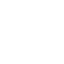

iterative denoising:  18%|█▊        | 6/33 [00:12<00:52,  1.94s/it]

Timestep t: 810, Prev Timestep: 780
Alpha Bar: 0.08427829295396805, Alpha Bar Prev: 0.11203352361917496, Alpha: 0.7522596120834351
Image dtype: torch.float16
Timesteps dtype: torch.int64
Prompt embeds dtype: torch.float16
Model Output Shape: torch.Size([1, 6, 64, 64])


iterative denoising:  21%|██        | 7/33 [00:13<00:46,  1.81s/it]

Model Output Min/Max: -1.40234375 0.4853515625
Noise Est Min/Max: 0.36865234375 0.4853515625
Predicted Variance Min/Max: -1.40234375 -0.74951171875
Noise Est Shape: torch.Size([1, 3, 64, 64])
Predicted Variance Shape: torch.Size([1, 3, 64, 64])
Pred Prev Image Min/Max: 0.8466796875 1.0
Timestep t: 780, Prev Timestep: 750
Alpha Bar: 0.11203352361917496, Alpha Bar Prev: 0.14317865669727325, Alpha: 0.782473623752594
Image dtype: torch.float16
Timesteps dtype: torch.int64
Prompt embeds dtype: torch.float16
Model Output Shape: torch.Size([1, 6, 64, 64])


iterative denoising:  24%|██▍       | 8/33 [00:15<00:43,  1.72s/it]

Model Output Min/Max: -1.3984375 0.47216796875
Noise Est Min/Max: 0.3076171875 0.47216796875
Predicted Variance Min/Max: -1.3984375 -0.74267578125
Noise Est Shape: torch.Size([1, 3, 64, 64])
Predicted Variance Shape: torch.Size([1, 3, 64, 64])
Pred Prev Image Min/Max: 0.6728515625 1.0
Timestep t: 750, Prev Timestep: 720
Alpha Bar: 0.14317865669727325, Alpha Bar Prev: 0.17744159698486328, Alpha: 0.8069058060646057
Image dtype: torch.float16
Timesteps dtype: torch.int64
Prompt embeds dtype: torch.float16
Model Output Shape: torch.Size([1, 6, 64, 64])


iterative denoising:  27%|██▋       | 9/33 [00:16<00:40,  1.67s/it]

Model Output Min/Max: -1.3896484375 0.46337890625
Noise Est Min/Max: 0.109130859375 0.46337890625
Predicted Variance Min/Max: -1.3896484375 -0.73388671875
Noise Est Shape: torch.Size([1, 3, 64, 64])
Predicted Variance Shape: torch.Size([1, 3, 64, 64])
Pred Prev Image Min/Max: 0.5185546875 1.0
Timestep t: 720, Prev Timestep: 690
Alpha Bar: 0.17744159698486328, Alpha Bar Prev: 0.21452300250530243, Alpha: 0.8271448612213135
Image dtype: torch.float16
Timesteps dtype: torch.int64
Prompt embeds dtype: torch.float16
Model Output Shape: torch.Size([1, 6, 64, 64])


iterative denoising:  30%|███       | 10/33 [00:18<00:37,  1.63s/it]

Model Output Min/Max: -1.384765625 0.4560546875
Noise Est Min/Max: -0.0772705078125 0.4560546875
Predicted Variance Min/Max: -1.384765625 -0.72705078125
Noise Est Shape: torch.Size([1, 3, 64, 64])
Predicted Variance Shape: torch.Size([1, 3, 64, 64])
Pred Prev Image Min/Max: 0.3984375 1.0
Timestep t: 690, Prev Timestep: 660
Alpha Bar: 0.21452300250530243, Alpha Bar Prev: 0.2540990114212036, Alpha: 0.8442496657371521
Image dtype: torch.float16
Timesteps dtype: torch.int64
Prompt embeds dtype: torch.float16
Model Output Shape: torch.Size([1, 6, 64, 64])
Model Output Min/Max: -1.375 0.4462890625
Noise Est Min/Max: -0.226318359375 0.4462890625
Predicted Variance Min/Max: -1.375 -0.724609375
Noise Est Shape: torch.Size([1, 3, 64, 64])
Predicted Variance Shape: torch.Size([1, 3, 64, 64])
Pred Prev Image Min/Max: 0.330078125 1.0


"Timestep tensor([690], device='cuda:0')"

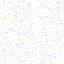

iterative denoising:  33%|███▎      | 11/33 [00:19<00:35,  1.62s/it]

Timestep t: 660, Prev Timestep: 630
Alpha Bar: 0.2540990114212036, Alpha Bar Prev: 0.2958238124847412, Alpha: 0.8589538931846619
Image dtype: torch.float16
Timesteps dtype: torch.int64
Prompt embeds dtype: torch.float16
Model Output Shape: torch.Size([1, 6, 64, 64])


iterative denoising:  36%|███▋      | 12/33 [00:21<00:33,  1.62s/it]

Model Output Min/Max: -1.357421875 0.435546875
Noise Est Min/Max: -0.336669921875 0.435546875
Predicted Variance Min/Max: -1.357421875 -0.72900390625
Noise Est Shape: torch.Size([1, 3, 64, 64])
Predicted Variance Shape: torch.Size([1, 3, 64, 64])
Pred Prev Image Min/Max: 0.2548828125 1.0
Timestep t: 630, Prev Timestep: 600
Alpha Bar: 0.2958238124847412, Alpha Bar Prev: 0.3393329381942749, Alpha: 0.8717803955078125
Image dtype: torch.float16
Timesteps dtype: torch.int64
Prompt embeds dtype: torch.float16
Model Output Shape: torch.Size([1, 6, 64, 64])


iterative denoising:  39%|███▉      | 13/33 [00:23<00:32,  1.62s/it]

Model Output Min/Max: -1.32421875 0.42724609375
Noise Est Min/Max: -0.462890625 0.42724609375
Predicted Variance Min/Max: -1.32421875 -0.73583984375
Noise Est Shape: torch.Size([1, 3, 64, 64])
Predicted Variance Shape: torch.Size([1, 3, 64, 64])
Pred Prev Image Min/Max: 0.2060546875 1.0
Timestep t: 600, Prev Timestep: 570
Alpha Bar: 0.3393329381942749, Alpha Bar Prev: 0.3842463195323944, Alpha: 0.8831130266189575
Image dtype: torch.float16
Timesteps dtype: torch.int64
Prompt embeds dtype: torch.float16
Model Output Shape: torch.Size([1, 6, 64, 64])


iterative denoising:  42%|████▏     | 14/33 [00:25<00:31,  1.67s/it]

Model Output Min/Max: -1.328125 0.42138671875
Noise Est Min/Max: -0.56103515625 0.42138671875
Predicted Variance Min/Max: -1.328125 -0.7470703125
Noise Est Shape: torch.Size([1, 3, 64, 64])
Predicted Variance Shape: torch.Size([1, 3, 64, 64])
Pred Prev Image Min/Max: 0.1611437201499939 1.0
Timestep t: 570, Prev Timestep: 540
Alpha Bar: 0.3842463195323944, Alpha Bar Prev: 0.4301716089248657, Alpha: 0.8932396173477173
Image dtype: torch.float16
Timesteps dtype: torch.int64
Prompt embeds dtype: torch.float16
Model Output Shape: torch.Size([1, 6, 64, 64])


iterative denoising:  45%|████▌     | 15/33 [00:26<00:29,  1.65s/it]

Model Output Min/Max: -1.28515625 0.41015625
Noise Est Min/Max: -0.6689453125 0.41015625
Predicted Variance Min/Max: -1.28515625 -0.75927734375
Noise Est Shape: torch.Size([1, 3, 64, 64])
Predicted Variance Shape: torch.Size([1, 3, 64, 64])
Pred Prev Image Min/Max: 0.1201171875 1.0
Timestep t: 540, Prev Timestep: 510
Alpha Bar: 0.4301716089248657, Alpha Bar Prev: 0.4767075181007385, Alpha: 0.9023805856704712
Image dtype: torch.float16
Timesteps dtype: torch.int64
Prompt embeds dtype: torch.float16
Model Output Shape: torch.Size([1, 6, 64, 64])
Model Output Min/Max: -1.259765625 0.40771484375
Noise Est Min/Max: -0.7587890625 0.40771484375
Predicted Variance Min/Max: -1.259765625 -0.791015625
Noise Est Shape: torch.Size([1, 3, 64, 64])
Predicted Variance Shape: torch.Size([1, 3, 64, 64])
Pred Prev Image Min/Max: 0.0771484375 1.0


"Timestep tensor([540], device='cuda:0')"

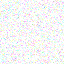

iterative denoising:  48%|████▊     | 16/33 [00:28<00:27,  1.62s/it]

Timestep t: 510, Prev Timestep: 480
Alpha Bar: 0.4767075181007385, Alpha Bar Prev: 0.523447573184967, Alpha: 0.9107072949409485
Image dtype: torch.float16
Timesteps dtype: torch.int64
Prompt embeds dtype: torch.float16
Model Output Shape: torch.Size([1, 6, 64, 64])


iterative denoising:  52%|█████▏    | 17/33 [00:29<00:25,  1.61s/it]

Model Output Min/Max: -1.236328125 0.40087890625
Noise Est Min/Max: -0.8720703125 0.40087890625
Predicted Variance Min/Max: -1.236328125 -0.83984375
Noise Est Shape: torch.Size([1, 3, 64, 64])
Predicted Variance Shape: torch.Size([1, 3, 64, 64])
Pred Prev Image Min/Max: 0.0517578125 1.0
Timestep t: 480, Prev Timestep: 450
Alpha Bar: 0.523447573184967, Alpha Bar Prev: 0.5699834823608398, Alpha: 0.9183557033538818
Image dtype: torch.float16
Timesteps dtype: torch.int64
Prompt embeds dtype: torch.float16
Model Output Shape: torch.Size([1, 6, 64, 64])


iterative denoising:  55%|█████▍    | 18/33 [00:31<00:24,  1.61s/it]

Model Output Min/Max: -1.255859375 0.3974609375
Noise Est Min/Max: -0.9794921875 0.3974609375
Predicted Variance Min/Max: -1.255859375 -0.86767578125
Noise Est Shape: torch.Size([1, 3, 64, 64])
Predicted Variance Shape: torch.Size([1, 3, 64, 64])
Pred Prev Image Min/Max: 0.0283203125 1.0
Timestep t: 450, Prev Timestep: 420
Alpha Bar: 0.5699834823608398, Alpha Bar Prev: 0.6159088611602783, Alpha: 0.9254347681999207
Image dtype: torch.float16
Timesteps dtype: torch.int64
Prompt embeds dtype: torch.float16
Model Output Shape: torch.Size([1, 6, 64, 64])


iterative denoising:  58%|█████▊    | 19/33 [00:32<00:22,  1.61s/it]

Model Output Min/Max: -1.251953125 0.3798828125
Noise Est Min/Max: -1.115234375 0.3798828125
Predicted Variance Min/Max: -1.251953125 -0.90478515625
Noise Est Shape: torch.Size([1, 3, 64, 64])
Predicted Variance Shape: torch.Size([1, 3, 64, 64])
Pred Prev Image Min/Max: 0.03365981578826904 1.0
Timestep t: 420, Prev Timestep: 390
Alpha Bar: 0.6159088611602783, Alpha Bar Prev: 0.6608222723007202, Alpha: 0.9320340752601624
Image dtype: torch.float16
Timesteps dtype: torch.int64
Prompt embeds dtype: torch.float16
Model Output Shape: torch.Size([1, 6, 64, 64])


iterative denoising:  61%|██████    | 20/33 [00:34<00:20,  1.61s/it]

Model Output Min/Max: -1.2197265625 0.36669921875
Noise Est Min/Max: -1.185546875 0.36669921875
Predicted Variance Min/Max: -1.2197265625 -0.9169921875
Noise Est Shape: torch.Size([1, 3, 64, 64])
Predicted Variance Shape: torch.Size([1, 3, 64, 64])
Pred Prev Image Min/Max: 0.11711066961288452 1.0
Timestep t: 390, Prev Timestep: 360
Alpha Bar: 0.6608222723007202, Alpha Bar Prev: 0.704331636428833, Alpha: 0.938226044178009
Image dtype: torch.float16
Timesteps dtype: torch.int64
Prompt embeds dtype: torch.float16
Model Output Shape: torch.Size([1, 6, 64, 64])
Model Output Min/Max: -1.2041015625 0.34814453125
Noise Est Min/Max: -1.1845703125 0.34814453125
Predicted Variance Min/Max: -1.2041015625 -0.93310546875
Noise Est Shape: torch.Size([1, 3, 64, 64])
Predicted Variance Shape: torch.Size([1, 3, 64, 64])
Pred Prev Image Min/Max: 0.07601648569107056 1.0


"Timestep tensor([390], device='cuda:0')"

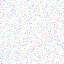

iterative denoising:  64%|██████▎   | 21/33 [00:36<00:19,  1.60s/it]

Timestep t: 360, Prev Timestep: 330
Alpha Bar: 0.704331636428833, Alpha Bar Prev: 0.7460564374923706, Alpha: 0.9440728425979614
Image dtype: torch.float16
Timesteps dtype: torch.int64
Prompt embeds dtype: torch.float16
Model Output Shape: torch.Size([1, 6, 64, 64])


iterative denoising:  67%|██████▋   | 22/33 [00:37<00:17,  1.59s/it]

Model Output Min/Max: -1.37109375 0.34033203125
Noise Est Min/Max: -1.37109375 0.34033203125
Predicted Variance Min/Max: -1.181640625 -0.9326171875
Noise Est Shape: torch.Size([1, 3, 64, 64])
Predicted Variance Shape: torch.Size([1, 3, 64, 64])
Pred Prev Image Min/Max: 0.174271821975708 1.0
Timestep t: 330, Prev Timestep: 300
Alpha Bar: 0.7460564374923706, Alpha Bar Prev: 0.7856324315071106, Alpha: 0.9496253132820129
Image dtype: torch.float16
Timesteps dtype: torch.int64
Prompt embeds dtype: torch.float16
Model Output Shape: torch.Size([1, 6, 64, 64])


iterative denoising:  70%|██████▉   | 23/33 [00:39<00:15,  1.58s/it]

Model Output Min/Max: -1.3447265625 0.31640625
Noise Est Min/Max: -1.3447265625 0.31640625
Predicted Variance Min/Max: -1.13671875 -0.92626953125
Noise Est Shape: torch.Size([1, 3, 64, 64])
Predicted Variance Shape: torch.Size([1, 3, 64, 64])
Pred Prev Image Min/Max: 0.13744854927062988 1.0
Timestep t: 300, Prev Timestep: 270
Alpha Bar: 0.7856324315071106, Alpha Bar Prev: 0.8227139711380005, Alpha: 0.9549278020858765
Image dtype: torch.float16
Timesteps dtype: torch.int64
Prompt embeds dtype: torch.float16
Model Output Shape: torch.Size([1, 6, 64, 64])


iterative denoising:  73%|███████▎  | 24/33 [00:40<00:14,  1.56s/it]

Model Output Min/Max: -1.59765625 0.28466796875
Noise Est Min/Max: -1.59765625 0.28466796875
Predicted Variance Min/Max: -1.142578125 -0.9423828125
Noise Est Shape: torch.Size([1, 3, 64, 64])
Predicted Variance Shape: torch.Size([1, 3, 64, 64])
Pred Prev Image Min/Max: 0.31717026233673096 1.0
Timestep t: 270, Prev Timestep: 240
Alpha Bar: 0.8227139711380005, Alpha Bar Prev: 0.8569768071174622, Alpha: 0.9600189328193665
Image dtype: torch.float16
Timesteps dtype: torch.int64
Prompt embeds dtype: torch.float16
Model Output Shape: torch.Size([1, 6, 64, 64])


iterative denoising:  76%|███████▌  | 25/33 [00:42<00:12,  1.57s/it]

Model Output Min/Max: -1.39453125 0.2666015625
Noise Est Min/Max: -1.39453125 0.2666015625
Predicted Variance Min/Max: -1.1416015625 -0.9462890625
Noise Est Shape: torch.Size([1, 3, 64, 64])
Predicted Variance Shape: torch.Size([1, 3, 64, 64])
Pred Prev Image Min/Max: 0.32990777492523193 1.0
Timestep t: 240, Prev Timestep: 210
Alpha Bar: 0.8569768071174622, Alpha Bar Prev: 0.8881219625473022, Alpha: 0.9649314284324646
Image dtype: torch.float16
Timesteps dtype: torch.int64
Prompt embeds dtype: torch.float16
Model Output Shape: torch.Size([1, 6, 64, 64])
Model Output Min/Max: -1.5390625 0.25390625
Noise Est Min/Max: -1.5390625 0.25390625
Predicted Variance Min/Max: -1.1123046875 -0.94091796875
Noise Est Shape: torch.Size([1, 3, 64, 64])
Predicted Variance Shape: torch.Size([1, 3, 64, 64])
Pred Prev Image Min/Max: 0.43902885913848877 1.0


"Timestep tensor([240], device='cuda:0')"

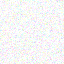

iterative denoising:  79%|███████▉  | 26/33 [00:44<00:11,  1.60s/it]

Timestep t: 210, Prev Timestep: 180
Alpha Bar: 0.8881219625473022, Alpha Bar Prev: 0.9158772230148315, Alpha: 0.9696954488754272
Image dtype: torch.float16
Timesteps dtype: torch.int64
Prompt embeds dtype: torch.float16
Model Output Shape: torch.Size([1, 6, 64, 64])


iterative denoising:  82%|████████▏ | 27/33 [00:45<00:09,  1.58s/it]

Model Output Min/Max: -1.451171875 0.25927734375
Noise Est Min/Max: -1.451171875 0.25927734375
Predicted Variance Min/Max: -1.091796875 -0.9208984375
Noise Est Shape: torch.Size([1, 3, 64, 64])
Predicted Variance Shape: torch.Size([1, 3, 64, 64])
Pred Prev Image Min/Max: 0.5063812732696533 1.0
Timestep t: 180, Prev Timestep: 150
Alpha Bar: 0.9158772230148315, Alpha Bar Prev: 0.9399999976158142, Alpha: 0.9743374586105347
Image dtype: torch.float16
Timesteps dtype: torch.int64
Prompt embeds dtype: torch.float16
Model Output Shape: torch.Size([1, 6, 64, 64])


iterative denoising:  85%|████████▍ | 28/33 [00:47<00:08,  1.60s/it]

Model Output Min/Max: -1.4755859375 0.28173828125
Noise Est Min/Max: -1.4755859375 0.28173828125
Predicted Variance Min/Max: -1.1015625 -0.92578125
Noise Est Shape: torch.Size([1, 3, 64, 64])
Predicted Variance Shape: torch.Size([1, 3, 64, 64])
Pred Prev Image Min/Max: 0.5440423488616943 1.0
Timestep t: 150, Prev Timestep: 120
Alpha Bar: 0.9399999976158142, Alpha Bar Prev: 0.9602797627449036, Alpha: 0.9788814187049866
Image dtype: torch.float16
Timesteps dtype: torch.int64
Prompt embeds dtype: torch.float16
Model Output Shape: torch.Size([1, 6, 64, 64])


iterative denoising:  88%|████████▊ | 29/33 [00:48<00:06,  1.60s/it]

Model Output Min/Max: -1.6201171875 0.30810546875
Noise Est Min/Max: -1.6201171875 0.30810546875
Predicted Variance Min/Max: -1.09375 -0.90625
Noise Est Shape: torch.Size([1, 3, 64, 64])
Predicted Variance Shape: torch.Size([1, 3, 64, 64])
Pred Prev Image Min/Max: 0.5469942092895508 1.0
Timestep t: 120, Prev Timestep: 90
Alpha Bar: 0.9602797627449036, Alpha Bar Prev: 0.9765393137931824, Alpha: 0.9833498001098633
Image dtype: torch.float16
Timesteps dtype: torch.int64
Prompt embeds dtype: torch.float16
Model Output Shape: torch.Size([1, 6, 64, 64])


iterative denoising:  91%|█████████ | 30/33 [00:50<00:04,  1.58s/it]

Model Output Min/Max: -2.0 0.30419921875
Noise Est Min/Max: -2.0 0.30419921875
Predicted Variance Min/Max: -1.080078125 -0.96484375
Noise Est Shape: torch.Size([1, 3, 64, 64])
Predicted Variance Shape: torch.Size([1, 3, 64, 64])
Pred Prev Image Min/Max: 0.64650559425354 1.0
Timestep t: 90, Prev Timestep: 60
Alpha Bar: 0.9765393137931824, Alpha Bar Prev: 0.9886365532875061, Alpha: 0.9877637028694153
Image dtype: torch.float16
Timesteps dtype: torch.int64
Prompt embeds dtype: torch.float16
Model Output Shape: torch.Size([1, 6, 64, 64])
Model Output Min/Max: -1.966796875 0.375
Noise Est Min/Max: -1.966796875 0.375
Predicted Variance Min/Max: -1.0849609375 -0.9638671875
Noise Est Shape: torch.Size([1, 3, 64, 64])
Predicted Variance Shape: torch.Size([1, 3, 64, 64])
Pred Prev Image Min/Max: 0.7441638112068176 1.0


"Timestep tensor([90], device='cuda:0')"

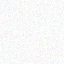

iterative denoising:  94%|█████████▍| 31/33 [00:51<00:03,  1.57s/it]

Timestep t: 60, Prev Timestep: 30
Alpha Bar: 0.9886365532875061, Alpha Bar Prev: 0.9964657425880432, Alpha: 0.9921430349349976
Image dtype: torch.float16
Timesteps dtype: torch.int64
Prompt embeds dtype: torch.float16
Model Output Shape: torch.Size([1, 6, 64, 64])


iterative denoising:  97%|█████████▋| 32/33 [00:53<00:01,  1.59s/it]

Model Output Min/Max: -1.9873046875 0.4755859375
Noise Est Min/Max: -1.9873046875 0.4755859375
Predicted Variance Min/Max: -1.060546875 -0.9716796875
Noise Est Shape: torch.Size([1, 3, 64, 64])
Predicted Variance Shape: torch.Size([1, 3, 64, 64])
Pred Prev Image Min/Max: 0.929267406463623 0.9827353358268738
Timestep t: 30, Prev Timestep: 0
Alpha Bar: 0.9964657425880432, Alpha Bar Prev: 0.9999586939811707, Alpha: 0.996506929397583
Image dtype: torch.float16
Timesteps dtype: torch.int64
Prompt embeds dtype: torch.float16
Model Output Shape: torch.Size([1, 6, 64, 64])


iterative denoising: 100%|██████████| 33/33 [00:55<00:00,  1.67s/it]

Model Output Min/Max: -1.0849609375 0.45166015625
Noise Est Min/Max: -0.490234375 0.45166015625
Predicted Variance Min/Max: -1.0849609375 -0.9833984375
Noise Est Shape: torch.Size([1, 3, 64, 64])
Predicted Variance Shape: torch.Size([1, 3, 64, 64])
Pred Prev Image Min/Max: 0.95703125 0.96142578125


Noisy 990,Iterative

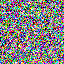
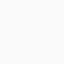

iterative denoising:   0%|          | 0/33 [00:00<?, ?it/s]

Timestep t: 990, Prev Timestep: 960
Alpha Bar: 0.00019671733025461435, Alpha Bar Prev: 0.0036896108649671078, Alpha: 0.05331655219197273
Image dtype: torch.float16
Timesteps dtype: torch.int64
Prompt embeds dtype: torch.float16
Model Output Shape: torch.Size([1, 6, 64, 64])
Model Output Min/Max: -3.302734375 3.4375
Noise Est Min/Max: -3.0 3.0
Predicted Variance Min/Max: -1.3642578125 -0.693359375
Noise Est Shape: torch.Size([1, 3, 64, 64])
Predicted Variance Shape: torch.Size([1, 3, 64, 64])
Pred Prev Image Min/Max: -1.0 1.0


"Timestep tensor([990], device='cuda:0')"

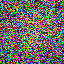

iterative denoising:   3%|▎         | 1/33 [00:01<00:53,  1.68s/it]

Timestep t: 960, Prev Timestep: 930
Alpha Bar: 0.0036896108649671078, Alpha Bar Prev: 0.01151887234300375, Alpha: 0.3203100860118866
Image dtype: torch.float16
Timesteps dtype: torch.int64
Prompt embeds dtype: torch.float16
Model Output Shape: torch.Size([1, 6, 64, 64])


iterative denoising:   6%|▌         | 2/33 [00:03<00:49,  1.61s/it]

Model Output Min/Max: -1.3876953125 1.1064453125
Noise Est Min/Max: -0.94677734375 1.1064453125
Predicted Variance Min/Max: -1.3876953125 -0.7919921875
Noise Est Shape: torch.Size([1, 3, 64, 64])
Predicted Variance Shape: torch.Size([1, 3, 64, 64])
Pred Prev Image Min/Max: -1.0 0.42658621072769165
Timestep t: 930, Prev Timestep: 900
Alpha Bar: 0.01151887234300375, Alpha Bar Prev: 0.023616107180714607, Alpha: 0.4877549111843109
Image dtype: torch.float16
Timesteps dtype: torch.int64
Prompt embeds dtype: torch.float16
Model Output Shape: torch.Size([1, 6, 64, 64])


iterative denoising:   9%|▉         | 3/33 [00:04<00:48,  1.61s/it]

Model Output Min/Max: -1.583984375 1.0810546875
Noise Est Min/Max: -0.43994140625 1.0810546875
Predicted Variance Min/Max: -1.583984375 -0.892578125
Noise Est Shape: torch.Size([1, 3, 64, 64])
Predicted Variance Shape: torch.Size([1, 3, 64, 64])
Pred Prev Image Min/Max: -1.0 -1.0
Timestep t: 900, Prev Timestep: 870
Alpha Bar: 0.023616107180714607, Alpha Bar Prev: 0.03987564146518707, Alpha: 0.5922439694404602
Image dtype: torch.float16
Timesteps dtype: torch.int64
Prompt embeds dtype: torch.float16
Model Output Shape: torch.Size([1, 6, 64, 64])


iterative denoising:  12%|█▏        | 4/33 [00:06<00:46,  1.62s/it]

Model Output Min/Max: -1.57421875 -0.25
Noise Est Min/Max: -0.38232421875 -0.25
Predicted Variance Min/Max: -1.57421875 -0.9091796875
Noise Est Shape: torch.Size([1, 3, 64, 64])
Predicted Variance Shape: torch.Size([1, 3, 64, 64])
Pred Prev Image Min/Max: -1.0 -1.0
Timestep t: 870, Prev Timestep: 840
Alpha Bar: 0.03987564146518707, Alpha Bar Prev: 0.06015542894601822, Alpha: 0.6628768444061279
Image dtype: torch.float16
Timesteps dtype: torch.int64
Prompt embeds dtype: torch.float16
Model Output Shape: torch.Size([1, 6, 64, 64])


iterative denoising:  15%|█▌        | 5/33 [00:08<00:44,  1.60s/it]

Model Output Min/Max: -1.5703125 -0.2384033203125
Noise Est Min/Max: -0.37060546875 -0.2384033203125
Predicted Variance Min/Max: -1.5703125 -0.931640625
Noise Est Shape: torch.Size([1, 3, 64, 64])
Predicted Variance Shape: torch.Size([1, 3, 64, 64])
Pred Prev Image Min/Max: -1.0 -1.0
Timestep t: 840, Prev Timestep: 810
Alpha Bar: 0.06015542894601822, Alpha Bar Prev: 0.08427829295396805, Alpha: 0.7137713432312012
Image dtype: torch.float16
Timesteps dtype: torch.int64
Prompt embeds dtype: torch.float16
Model Output Shape: torch.Size([1, 6, 64, 64])
Model Output Min/Max: -1.56640625 -0.231689453125
Noise Est Min/Max: -0.359375 -0.231689453125
Predicted Variance Min/Max: -1.56640625 -0.9501953125
Noise Est Shape: torch.Size([1, 3, 64, 64])
Predicted Variance Shape: torch.Size([1, 3, 64, 64])
Pred Prev Image Min/Max: -1.0 -1.0


"Timestep tensor([840], device='cuda:0')"

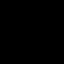

iterative denoising:  18%|█▊        | 6/33 [00:09<00:43,  1.61s/it]

Timestep t: 810, Prev Timestep: 780
Alpha Bar: 0.08427829295396805, Alpha Bar Prev: 0.11203352361917496, Alpha: 0.7522596120834351
Image dtype: torch.float16
Timesteps dtype: torch.int64
Prompt embeds dtype: torch.float16
Model Output Shape: torch.Size([1, 6, 64, 64])


iterative denoising:  21%|██        | 7/33 [00:11<00:43,  1.66s/it]

Model Output Min/Max: -1.5556640625 -0.22900390625
Noise Est Min/Max: -0.35302734375 -0.22900390625
Predicted Variance Min/Max: -1.5556640625 -0.962890625
Noise Est Shape: torch.Size([1, 3, 64, 64])
Predicted Variance Shape: torch.Size([1, 3, 64, 64])
Pred Prev Image Min/Max: -1.0 -1.0
Timestep t: 780, Prev Timestep: 750
Alpha Bar: 0.11203352361917496, Alpha Bar Prev: 0.14317865669727325, Alpha: 0.782473623752594
Image dtype: torch.float16
Timesteps dtype: torch.int64
Prompt embeds dtype: torch.float16
Model Output Shape: torch.Size([1, 6, 64, 64])


iterative denoising:  24%|██▍       | 8/33 [00:13<00:42,  1.70s/it]

Model Output Min/Max: -1.55078125 -0.2274169921875
Noise Est Min/Max: -0.3466796875 -0.2274169921875
Predicted Variance Min/Max: -1.55078125 -0.9755859375
Noise Est Shape: torch.Size([1, 3, 64, 64])
Predicted Variance Shape: torch.Size([1, 3, 64, 64])
Pred Prev Image Min/Max: -1.0 -1.0
Timestep t: 750, Prev Timestep: 720
Alpha Bar: 0.14317865669727325, Alpha Bar Prev: 0.17744159698486328, Alpha: 0.8069058060646057
Image dtype: torch.float16
Timesteps dtype: torch.int64
Prompt embeds dtype: torch.float16
Model Output Shape: torch.Size([1, 6, 64, 64])


iterative denoising:  27%|██▋       | 9/33 [00:14<00:40,  1.70s/it]

Model Output Min/Max: -1.544921875 -0.2274169921875
Noise Est Min/Max: -0.33984375 -0.2274169921875
Predicted Variance Min/Max: -1.544921875 -0.9873046875
Noise Est Shape: torch.Size([1, 3, 64, 64])
Predicted Variance Shape: torch.Size([1, 3, 64, 64])
Pred Prev Image Min/Max: -1.0 -0.81640625
Timestep t: 720, Prev Timestep: 690
Alpha Bar: 0.17744159698486328, Alpha Bar Prev: 0.21452300250530243, Alpha: 0.8271448612213135
Image dtype: torch.float16
Timesteps dtype: torch.int64
Prompt embeds dtype: torch.float16
Model Output Shape: torch.Size([1, 6, 64, 64])


iterative denoising:  30%|███       | 10/33 [00:16<00:38,  1.68s/it]

Model Output Min/Max: -1.5400390625 -0.13232421875
Noise Est Min/Max: -0.33447265625 -0.13232421875
Predicted Variance Min/Max: -1.5400390625 -0.9970703125
Noise Est Shape: torch.Size([1, 3, 64, 64])
Predicted Variance Shape: torch.Size([1, 3, 64, 64])
Pred Prev Image Min/Max: -1.0 -0.658203125
Timestep t: 690, Prev Timestep: 660
Alpha Bar: 0.21452300250530243, Alpha Bar Prev: 0.2540990114212036, Alpha: 0.8442496657371521
Image dtype: torch.float16
Timesteps dtype: torch.int64
Prompt embeds dtype: torch.float16
Model Output Shape: torch.Size([1, 6, 64, 64])
Model Output Min/Max: -1.537109375 0.0535888671875
Noise Est Min/Max: -0.32861328125 0.0535888671875
Predicted Variance Min/Max: -1.537109375 -1.005859375
Noise Est Shape: torch.Size([1, 3, 64, 64])
Predicted Variance Shape: torch.Size([1, 3, 64, 64])
Pred Prev Image Min/Max: -1.0 -0.5458984375


"Timestep tensor([690], device='cuda:0')"

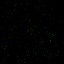

iterative denoising:  33%|███▎      | 11/33 [00:18<00:37,  1.68s/it]

Timestep t: 660, Prev Timestep: 630
Alpha Bar: 0.2540990114212036, Alpha Bar Prev: 0.2958238124847412, Alpha: 0.8589538931846619
Image dtype: torch.float16
Timesteps dtype: torch.int64
Prompt embeds dtype: torch.float16
Model Output Shape: torch.Size([1, 6, 64, 64])


iterative denoising:  36%|███▋      | 12/33 [00:19<00:34,  1.64s/it]

Model Output Min/Max: -1.5400390625 0.2125244140625
Noise Est Min/Max: -0.323486328125 0.2125244140625
Predicted Variance Min/Max: -1.5400390625 -1.015625
Noise Est Shape: torch.Size([1, 3, 64, 64])
Predicted Variance Shape: torch.Size([1, 3, 64, 64])
Pred Prev Image Min/Max: -1.0 -0.4365234375
Timestep t: 630, Prev Timestep: 600
Alpha Bar: 0.2958238124847412, Alpha Bar Prev: 0.3393329381942749, Alpha: 0.8717803955078125
Image dtype: torch.float16
Timesteps dtype: torch.int64
Prompt embeds dtype: torch.float16
Model Output Shape: torch.Size([1, 6, 64, 64])


iterative denoising:  39%|███▉      | 13/33 [00:21<00:32,  1.62s/it]

Model Output Min/Max: -1.54296875 0.349609375
Noise Est Min/Max: -0.3193359375 0.349609375
Predicted Variance Min/Max: -1.54296875 -1.0234375
Noise Est Shape: torch.Size([1, 3, 64, 64])
Predicted Variance Shape: torch.Size([1, 3, 64, 64])
Pred Prev Image Min/Max: -1.0 -0.3623046875
Timestep t: 600, Prev Timestep: 570
Alpha Bar: 0.3393329381942749, Alpha Bar Prev: 0.3842463195323944, Alpha: 0.8831130266189575
Image dtype: torch.float16
Timesteps dtype: torch.int64
Prompt embeds dtype: torch.float16
Model Output Shape: torch.Size([1, 6, 64, 64])


iterative denoising:  42%|████▏     | 14/33 [00:22<00:30,  1.60s/it]

Model Output Min/Max: -1.544921875 0.47265625
Noise Est Min/Max: -0.31396484375 0.47265625
Predicted Variance Min/Max: -1.544921875 -1.0390625
Noise Est Shape: torch.Size([1, 3, 64, 64])
Predicted Variance Shape: torch.Size([1, 3, 64, 64])
Pred Prev Image Min/Max: -1.0 -0.294921875
Timestep t: 570, Prev Timestep: 540
Alpha Bar: 0.3842463195323944, Alpha Bar Prev: 0.4301716089248657, Alpha: 0.8932396173477173
Image dtype: torch.float16
Timesteps dtype: torch.int64
Prompt embeds dtype: torch.float16
Model Output Shape: torch.Size([1, 6, 64, 64])


iterative denoising:  45%|████▌     | 15/33 [00:24<00:28,  1.61s/it]

Model Output Min/Max: -1.5341796875 0.5908203125
Noise Est Min/Max: -0.309814453125 0.5908203125
Predicted Variance Min/Max: -1.5341796875 -1.029296875
Noise Est Shape: torch.Size([1, 3, 64, 64])
Predicted Variance Shape: torch.Size([1, 3, 64, 64])
Pred Prev Image Min/Max: -1.0 -0.26435261964797974
Timestep t: 540, Prev Timestep: 510
Alpha Bar: 0.4301716089248657, Alpha Bar Prev: 0.4767075181007385, Alpha: 0.9023805856704712
Image dtype: torch.float16
Timesteps dtype: torch.int64
Prompt embeds dtype: torch.float16
Model Output Shape: torch.Size([1, 6, 64, 64])
Model Output Min/Max: -1.53515625 0.6826171875
Noise Est Min/Max: -0.3056640625 0.6826171875
Predicted Variance Min/Max: -1.53515625 -1.037109375
Noise Est Shape: torch.Size([1, 3, 64, 64])
Predicted Variance Shape: torch.Size([1, 3, 64, 64])
Pred Prev Image Min/Max: -1.0 -0.177734375


"Timestep tensor([540], device='cuda:0')"

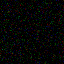

iterative denoising:  48%|████▊     | 16/33 [00:26<00:27,  1.62s/it]

Timestep t: 510, Prev Timestep: 480
Alpha Bar: 0.4767075181007385, Alpha Bar Prev: 0.523447573184967, Alpha: 0.9107072949409485
Image dtype: torch.float16
Timesteps dtype: torch.int64
Prompt embeds dtype: torch.float16
Model Output Shape: torch.Size([1, 6, 64, 64])


iterative denoising:  52%|█████▏    | 17/33 [00:27<00:26,  1.64s/it]

Model Output Min/Max: -1.509765625 0.8251953125
Noise Est Min/Max: -0.3037109375 0.8251953125
Predicted Variance Min/Max: -1.509765625 -1.041015625
Noise Est Shape: torch.Size([1, 3, 64, 64])
Predicted Variance Shape: torch.Size([1, 3, 64, 64])
Pred Prev Image Min/Max: -1.0 -0.1865234375
Timestep t: 480, Prev Timestep: 450
Alpha Bar: 0.523447573184967, Alpha Bar Prev: 0.5699834823608398, Alpha: 0.9183557033538818
Image dtype: torch.float16
Timesteps dtype: torch.int64
Prompt embeds dtype: torch.float16
Model Output Shape: torch.Size([1, 6, 64, 64])


iterative denoising:  55%|█████▍    | 18/33 [00:29<00:24,  1.65s/it]

Model Output Min/Max: -1.4912109375 0.91552734375
Noise Est Min/Max: -0.2978515625 0.91552734375
Predicted Variance Min/Max: -1.4912109375 -1.029296875
Noise Est Shape: torch.Size([1, 3, 64, 64])
Predicted Variance Shape: torch.Size([1, 3, 64, 64])
Pred Prev Image Min/Max: -1.0 -0.1005859375
Timestep t: 450, Prev Timestep: 420
Alpha Bar: 0.5699834823608398, Alpha Bar Prev: 0.6159088611602783, Alpha: 0.9254347681999207
Image dtype: torch.float16
Timesteps dtype: torch.int64
Prompt embeds dtype: torch.float16
Model Output Shape: torch.Size([1, 6, 64, 64])


iterative denoising:  58%|█████▊    | 19/33 [00:31<00:23,  1.67s/it]

Model Output Min/Max: -1.462890625 1.0751953125
Noise Est Min/Max: -0.2919921875 1.0751953125
Predicted Variance Min/Max: -1.462890625 -1.03515625
Noise Est Shape: torch.Size([1, 3, 64, 64])
Predicted Variance Shape: torch.Size([1, 3, 64, 64])
Pred Prev Image Min/Max: -1.0 -0.09484118223190308
Timestep t: 420, Prev Timestep: 390
Alpha Bar: 0.6159088611602783, Alpha Bar Prev: 0.6608222723007202, Alpha: 0.9320340752601624
Image dtype: torch.float16
Timesteps dtype: torch.int64
Prompt embeds dtype: torch.float16
Model Output Shape: torch.Size([1, 6, 64, 64])


iterative denoising:  61%|██████    | 20/33 [00:33<00:23,  1.79s/it]

Model Output Min/Max: -1.416015625 1.1875
Noise Est Min/Max: -0.28515625 1.1875
Predicted Variance Min/Max: -1.416015625 -1.01953125
Noise Est Shape: torch.Size([1, 3, 64, 64])
Predicted Variance Shape: torch.Size([1, 3, 64, 64])
Pred Prev Image Min/Max: -1.0 -0.21062636375427246
Timestep t: 390, Prev Timestep: 360
Alpha Bar: 0.6608222723007202, Alpha Bar Prev: 0.704331636428833, Alpha: 0.938226044178009
Image dtype: torch.float16
Timesteps dtype: torch.int64
Prompt embeds dtype: torch.float16
Model Output Shape: torch.Size([1, 6, 64, 64])
Model Output Min/Max: -1.400390625 1.099609375
Noise Est Min/Max: -0.26904296875 1.099609375
Predicted Variance Min/Max: -1.400390625 -1.033203125
Noise Est Shape: torch.Size([1, 3, 64, 64])
Predicted Variance Shape: torch.Size([1, 3, 64, 64])
Pred Prev Image Min/Max: -1.0 -0.16621947288513184


"Timestep tensor([390], device='cuda:0')"

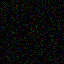

iterative denoising:  64%|██████▎   | 21/33 [00:35<00:21,  1.79s/it]

Timestep t: 360, Prev Timestep: 330
Alpha Bar: 0.704331636428833, Alpha Bar Prev: 0.7460564374923706, Alpha: 0.9440728425979614
Image dtype: torch.float16
Timesteps dtype: torch.int64
Prompt embeds dtype: torch.float16
Model Output Shape: torch.Size([1, 6, 64, 64])


iterative denoising:  67%|██████▋   | 22/33 [00:36<00:19,  1.76s/it]

Model Output Min/Max: -1.376953125 1.279296875
Noise Est Min/Max: -0.25927734375 1.279296875
Predicted Variance Min/Max: -1.376953125 -1.0380859375
Noise Est Shape: torch.Size([1, 3, 64, 64])
Predicted Variance Shape: torch.Size([1, 3, 64, 64])
Pred Prev Image Min/Max: -1.0 -0.16844910383224487
Timestep t: 330, Prev Timestep: 300
Alpha Bar: 0.7460564374923706, Alpha Bar Prev: 0.7856324315071106, Alpha: 0.9496253132820129
Image dtype: torch.float16
Timesteps dtype: torch.int64
Prompt embeds dtype: torch.float16
Model Output Shape: torch.Size([1, 6, 64, 64])


iterative denoising:  70%|██████▉   | 23/33 [00:38<00:17,  1.72s/it]

Model Output Min/Max: -1.359375 1.4404296875
Noise Est Min/Max: -0.24609375 1.4404296875
Predicted Variance Min/Max: -1.359375 -1.037109375
Noise Est Shape: torch.Size([1, 3, 64, 64])
Predicted Variance Shape: torch.Size([1, 3, 64, 64])
Pred Prev Image Min/Max: -1.0 -0.215783953666687
Timestep t: 300, Prev Timestep: 270
Alpha Bar: 0.7856324315071106, Alpha Bar Prev: 0.8227139711380005, Alpha: 0.9549278020858765
Image dtype: torch.float16
Timesteps dtype: torch.int64
Prompt embeds dtype: torch.float16
Model Output Shape: torch.Size([1, 6, 64, 64])


iterative denoising:  73%|███████▎  | 24/33 [00:40<00:15,  1.78s/it]

Model Output Min/Max: -1.353515625 1.4638671875
Noise Est Min/Max: -0.22265625 1.4638671875
Predicted Variance Min/Max: -1.353515625 -1.01171875
Noise Est Shape: torch.Size([1, 3, 64, 64])
Predicted Variance Shape: torch.Size([1, 3, 64, 64])
Pred Prev Image Min/Max: -1.0 -0.3771912455558777
Timestep t: 270, Prev Timestep: 240
Alpha Bar: 0.8227139711380005, Alpha Bar Prev: 0.8569768071174622, Alpha: 0.9600189328193665
Image dtype: torch.float16
Timesteps dtype: torch.int64
Prompt embeds dtype: torch.float16
Model Output Shape: torch.Size([1, 6, 64, 64])


iterative denoising:  76%|███████▌  | 25/33 [00:42<00:14,  1.77s/it]

Model Output Min/Max: -1.310546875 1.263671875
Noise Est Min/Max: -0.2164306640625 1.263671875
Predicted Variance Min/Max: -1.310546875 -0.984375
Noise Est Shape: torch.Size([1, 3, 64, 64])
Predicted Variance Shape: torch.Size([1, 3, 64, 64])
Pred Prev Image Min/Max: -1.0 -0.20999765396118164
Timestep t: 240, Prev Timestep: 210
Alpha Bar: 0.8569768071174622, Alpha Bar Prev: 0.8881219625473022, Alpha: 0.9649314284324646
Image dtype: torch.float16
Timesteps dtype: torch.int64
Prompt embeds dtype: torch.float16
Model Output Shape: torch.Size([1, 6, 64, 64])
Model Output Min/Max: -1.25 1.9111328125
Noise Est Min/Max: -0.2073974609375 1.9111328125
Predicted Variance Min/Max: -1.25 -0.9736328125
Noise Est Shape: torch.Size([1, 3, 64, 64])
Predicted Variance Shape: torch.Size([1, 3, 64, 64])
Pred Prev Image Min/Max: -1.0 -0.3500537872314453


"Timestep tensor([240], device='cuda:0')"

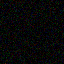

iterative denoising:  79%|███████▉  | 26/33 [00:43<00:11,  1.71s/it]

Timestep t: 210, Prev Timestep: 180
Alpha Bar: 0.8881219625473022, Alpha Bar Prev: 0.9158772230148315, Alpha: 0.9696954488754272
Image dtype: torch.float16
Timesteps dtype: torch.int64
Prompt embeds dtype: torch.float16
Model Output Shape: torch.Size([1, 6, 64, 64])


iterative denoising:  82%|████████▏ | 27/33 [00:45<00:10,  1.72s/it]

Model Output Min/Max: -1.22265625 1.787109375
Noise Est Min/Max: -0.227783203125 1.787109375
Predicted Variance Min/Max: -1.22265625 -0.9501953125
Noise Est Shape: torch.Size([1, 3, 64, 64])
Predicted Variance Shape: torch.Size([1, 3, 64, 64])
Pred Prev Image Min/Max: -1.0 -0.44402003288269043
Timestep t: 180, Prev Timestep: 150
Alpha Bar: 0.9158772230148315, Alpha Bar Prev: 0.9399999976158142, Alpha: 0.9743374586105347
Image dtype: torch.float16
Timesteps dtype: torch.int64
Prompt embeds dtype: torch.float16
Model Output Shape: torch.Size([1, 6, 64, 64])


iterative denoising:  85%|████████▍ | 28/33 [00:47<00:08,  1.72s/it]

Model Output Min/Max: -1.189453125 1.7216796875
Noise Est Min/Max: -0.263427734375 1.7216796875
Predicted Variance Min/Max: -1.189453125 -0.9287109375
Noise Est Shape: torch.Size([1, 3, 64, 64])
Predicted Variance Shape: torch.Size([1, 3, 64, 64])
Pred Prev Image Min/Max: -1.0 -0.5199098587036133
Timestep t: 150, Prev Timestep: 120
Alpha Bar: 0.9399999976158142, Alpha Bar Prev: 0.9602797627449036, Alpha: 0.9788814187049866
Image dtype: torch.float16
Timesteps dtype: torch.int64
Prompt embeds dtype: torch.float16
Model Output Shape: torch.Size([1, 6, 64, 64])


iterative denoising:  88%|████████▊ | 29/33 [00:48<00:06,  1.68s/it]

Model Output Min/Max: -1.162109375 1.736328125
Noise Est Min/Max: -0.27490234375 1.736328125
Predicted Variance Min/Max: -1.162109375 -0.91796875
Noise Est Shape: torch.Size([1, 3, 64, 64])
Predicted Variance Shape: torch.Size([1, 3, 64, 64])
Pred Prev Image Min/Max: -1.0 -0.6337180137634277
Timestep t: 120, Prev Timestep: 90
Alpha Bar: 0.9602797627449036, Alpha Bar Prev: 0.9765393137931824, Alpha: 0.9833498001098633
Image dtype: torch.float16
Timesteps dtype: torch.int64
Prompt embeds dtype: torch.float16
Model Output Shape: torch.Size([1, 6, 64, 64])


iterative denoising:  91%|█████████ | 30/33 [00:50<00:05,  1.71s/it]

Model Output Min/Max: -1.1494140625 1.5791015625
Noise Est Min/Max: -0.318603515625 1.5791015625
Predicted Variance Min/Max: -1.1494140625 -0.931640625
Noise Est Shape: torch.Size([1, 3, 64, 64])
Predicted Variance Shape: torch.Size([1, 3, 64, 64])
Pred Prev Image Min/Max: -1.0 -0.6874552369117737
Timestep t: 90, Prev Timestep: 60
Alpha Bar: 0.9765393137931824, Alpha Bar Prev: 0.9886365532875061, Alpha: 0.9877637028694153
Image dtype: torch.float16
Timesteps dtype: torch.int64
Prompt embeds dtype: torch.float16
Model Output Shape: torch.Size([1, 6, 64, 64])
Model Output Min/Max: -1.1142578125 1.7333984375
Noise Est Min/Max: -0.34814453125 1.7333984375
Predicted Variance Min/Max: -1.1142578125 -0.9326171875
Noise Est Shape: torch.Size([1, 3, 64, 64])
Predicted Variance Shape: torch.Size([1, 3, 64, 64])
Pred Prev Image Min/Max: -1.0 -0.7711478471755981


"Timestep tensor([90], device='cuda:0')"

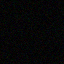

iterative denoising:  94%|█████████▍| 31/33 [00:52<00:03,  1.67s/it]

Timestep t: 60, Prev Timestep: 30
Alpha Bar: 0.9886365532875061, Alpha Bar Prev: 0.9964657425880432, Alpha: 0.9921430349349976
Image dtype: torch.float16
Timesteps dtype: torch.int64
Prompt embeds dtype: torch.float16
Model Output Shape: torch.Size([1, 6, 64, 64])


iterative denoising:  97%|█████████▋| 32/33 [00:53<00:01,  1.67s/it]

Model Output Min/Max: -1.103515625 1.7724609375
Noise Est Min/Max: -0.44775390625 1.7724609375
Predicted Variance Min/Max: -1.103515625 -0.904296875
Noise Est Shape: torch.Size([1, 3, 64, 64])
Predicted Variance Shape: torch.Size([1, 3, 64, 64])
Pred Prev Image Min/Max: -0.9908021688461304 -0.9386914968490601
Timestep t: 30, Prev Timestep: 0
Alpha Bar: 0.9964657425880432, Alpha Bar Prev: 0.9999586939811707, Alpha: 0.996506929397583
Image dtype: torch.float16
Timesteps dtype: torch.int64
Prompt embeds dtype: torch.float16
Model Output Shape: torch.Size([1, 6, 64, 64])


iterative denoising: 100%|██████████| 33/33 [00:55<00:00,  1.68s/it]

Model Output Min/Max: -1.1171875 0.390625
Noise Est Min/Max: -0.52197265625 0.390625
Predicted Variance Min/Max: -1.1171875 -0.92724609375
Noise Est Shape: torch.Size([1, 3, 64, 64])
Predicted Variance Shape: torch.Size([1, 3, 64, 64])
Pred Prev Image Min/Max: -0.966796875 -0.96142578125


Noisy 990,Iterative

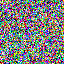
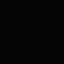

iterative denoising:   0%|          | 0/33 [00:00<?, ?it/s]

Timestep t: 990, Prev Timestep: 960
Alpha Bar: 0.00019671733025461435, Alpha Bar Prev: 0.0036896108649671078, Alpha: 0.05331655219197273
Image dtype: torch.float16
Timesteps dtype: torch.int64
Prompt embeds dtype: torch.float16
Model Output Shape: torch.Size([1, 6, 64, 64])
Model Output Min/Max: -4.1171875 4.0703125
Noise Est Min/Max: -3.0 3.0
Predicted Variance Min/Max: -1.2197265625 -0.6943359375
Noise Est Shape: torch.Size([1, 3, 64, 64])
Predicted Variance Shape: torch.Size([1, 3, 64, 64])
Pred Prev Image Min/Max: -1.0 1.0


"Timestep tensor([990], device='cuda:0')"

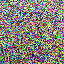

iterative denoising:   3%|▎         | 1/33 [00:01<00:48,  1.51s/it]

Timestep t: 960, Prev Timestep: 930
Alpha Bar: 0.0036896108649671078, Alpha Bar Prev: 0.01151887234300375, Alpha: 0.3203100860118866
Image dtype: torch.float16
Timesteps dtype: torch.int64
Prompt embeds dtype: torch.float16
Model Output Shape: torch.Size([1, 6, 64, 64])


iterative denoising:   6%|▌         | 2/33 [00:03<00:46,  1.51s/it]

Model Output Min/Max: -1.255859375 1.06640625
Noise Est Min/Max: -1.05859375 1.06640625
Predicted Variance Min/Max: -1.255859375 -0.76220703125
Noise Est Shape: torch.Size([1, 3, 64, 64])
Predicted Variance Shape: torch.Size([1, 3, 64, 64])
Pred Prev Image Min/Max: -1.0 1.0
Timestep t: 930, Prev Timestep: 900
Alpha Bar: 0.01151887234300375, Alpha Bar Prev: 0.023616107180714607, Alpha: 0.4877549111843109
Image dtype: torch.float16
Timesteps dtype: torch.int64
Prompt embeds dtype: torch.float16
Model Output Shape: torch.Size([1, 6, 64, 64])


iterative denoising:   9%|▉         | 3/33 [00:04<00:45,  1.52s/it]

Model Output Min/Max: -1.404296875 1.150390625
Noise Est Min/Max: -1.0263671875 1.150390625
Predicted Variance Min/Max: -1.404296875 -0.5712890625
Noise Est Shape: torch.Size([1, 3, 64, 64])
Predicted Variance Shape: torch.Size([1, 3, 64, 64])
Pred Prev Image Min/Max: -1.0 1.0
Timestep t: 900, Prev Timestep: 870
Alpha Bar: 0.023616107180714607, Alpha Bar Prev: 0.03987564146518707, Alpha: 0.5922439694404602
Image dtype: torch.float16
Timesteps dtype: torch.int64
Prompt embeds dtype: torch.float16
Model Output Shape: torch.Size([1, 6, 64, 64])


iterative denoising:  12%|█▏        | 4/33 [00:06<00:44,  1.53s/it]

Model Output Min/Max: -1.599609375 1.4140625
Noise Est Min/Max: -1.01171875 1.4140625
Predicted Variance Min/Max: -1.599609375 -0.67236328125
Noise Est Shape: torch.Size([1, 3, 64, 64])
Predicted Variance Shape: torch.Size([1, 3, 64, 64])
Pred Prev Image Min/Max: -1.0 1.0
Timestep t: 870, Prev Timestep: 840
Alpha Bar: 0.03987564146518707, Alpha Bar Prev: 0.06015542894601822, Alpha: 0.6628768444061279
Image dtype: torch.float16
Timesteps dtype: torch.int64
Prompt embeds dtype: torch.float16
Model Output Shape: torch.Size([1, 6, 64, 64])


iterative denoising:  15%|█▌        | 5/33 [00:07<00:42,  1.53s/it]

Model Output Min/Max: -1.61328125 1.3828125
Noise Est Min/Max: -0.80078125 1.3828125
Predicted Variance Min/Max: -1.61328125 -0.720703125
Noise Est Shape: torch.Size([1, 3, 64, 64])
Predicted Variance Shape: torch.Size([1, 3, 64, 64])
Pred Prev Image Min/Max: -1.0 1.0
Timestep t: 840, Prev Timestep: 810
Alpha Bar: 0.06015542894601822, Alpha Bar Prev: 0.08427829295396805, Alpha: 0.7137713432312012
Image dtype: torch.float16
Timesteps dtype: torch.int64
Prompt embeds dtype: torch.float16
Model Output Shape: torch.Size([1, 6, 64, 64])
Model Output Min/Max: -1.6337890625 1.322265625
Noise Est Min/Max: -0.80224609375 1.322265625
Predicted Variance Min/Max: -1.6337890625 -0.7685546875
Noise Est Shape: torch.Size([1, 3, 64, 64])
Predicted Variance Shape: torch.Size([1, 3, 64, 64])
Pred Prev Image Min/Max: -1.0 1.0


"Timestep tensor([840], device='cuda:0')"

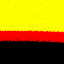

iterative denoising:  18%|█▊        | 6/33 [00:09<00:41,  1.53s/it]

Timestep t: 810, Prev Timestep: 780
Alpha Bar: 0.08427829295396805, Alpha Bar Prev: 0.11203352361917496, Alpha: 0.7522596120834351
Image dtype: torch.float16
Timesteps dtype: torch.int64
Prompt embeds dtype: torch.float16
Model Output Shape: torch.Size([1, 6, 64, 64])


iterative denoising:  21%|██        | 7/33 [00:10<00:40,  1.55s/it]

Model Output Min/Max: -1.6279296875 1.1943359375
Noise Est Min/Max: -0.6640625 1.1943359375
Predicted Variance Min/Max: -1.6279296875 -0.78369140625
Noise Est Shape: torch.Size([1, 3, 64, 64])
Predicted Variance Shape: torch.Size([1, 3, 64, 64])
Pred Prev Image Min/Max: -1.0 1.0
Timestep t: 780, Prev Timestep: 750
Alpha Bar: 0.11203352361917496, Alpha Bar Prev: 0.14317865669727325, Alpha: 0.782473623752594
Image dtype: torch.float16
Timesteps dtype: torch.int64
Prompt embeds dtype: torch.float16
Model Output Shape: torch.Size([1, 6, 64, 64])


iterative denoising:  24%|██▍       | 8/33 [00:12<00:41,  1.65s/it]

Model Output Min/Max: -1.615234375 1.1171875
Noise Est Min/Max: -0.65185546875 1.1171875
Predicted Variance Min/Max: -1.615234375 -0.80224609375
Noise Est Shape: torch.Size([1, 3, 64, 64])
Predicted Variance Shape: torch.Size([1, 3, 64, 64])
Pred Prev Image Min/Max: -1.0 1.0
Timestep t: 750, Prev Timestep: 720
Alpha Bar: 0.14317865669727325, Alpha Bar Prev: 0.17744159698486328, Alpha: 0.8069058060646057
Image dtype: torch.float16
Timesteps dtype: torch.int64
Prompt embeds dtype: torch.float16
Model Output Shape: torch.Size([1, 6, 64, 64])


iterative denoising:  27%|██▋       | 9/33 [00:14<00:42,  1.76s/it]

Model Output Min/Max: -1.6015625 1.1220703125
Noise Est Min/Max: -0.70068359375 1.1220703125
Predicted Variance Min/Max: -1.6015625 -0.8037109375
Noise Est Shape: torch.Size([1, 3, 64, 64])
Predicted Variance Shape: torch.Size([1, 3, 64, 64])
Pred Prev Image Min/Max: -1.0 1.0
Timestep t: 720, Prev Timestep: 690
Alpha Bar: 0.17744159698486328, Alpha Bar Prev: 0.21452300250530243, Alpha: 0.8271448612213135
Image dtype: torch.float16
Timesteps dtype: torch.int64
Prompt embeds dtype: torch.float16


iterative denoising:  30%|███       | 10/33 [00:17<00:48,  2.12s/it]

Model Output Shape: torch.Size([1, 6, 64, 64])
Model Output Min/Max: -1.5732421875 0.99462890625
Noise Est Min/Max: -0.763671875 0.99462890625
Predicted Variance Min/Max: -1.5732421875 -0.80029296875
Noise Est Shape: torch.Size([1, 3, 64, 64])
Predicted Variance Shape: torch.Size([1, 3, 64, 64])
Pred Prev Image Min/Max: -1.0 1.0
Timestep t: 690, Prev Timestep: 660
Alpha Bar: 0.21452300250530243, Alpha Bar Prev: 0.2540990114212036, Alpha: 0.8442496657371521
Image dtype: torch.float16
Timesteps dtype: torch.int64
Prompt embeds dtype: torch.float16
Model Output Shape: torch.Size([1, 6, 64, 64])
Model Output Min/Max: -1.56640625 0.71630859375
Noise Est Min/Max: -0.82177734375 0.71630859375
Predicted Variance Min/Max: -1.56640625 -0.8037109375
Noise Est Shape: torch.Size([1, 3, 64, 64])
Predicted Variance Shape: torch.Size([1, 3, 64, 64])
Pred Prev Image Min/Max: -1.0 1.0


"Timestep tensor([690], device='cuda:0')"

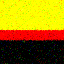

iterative denoising:  33%|███▎      | 11/33 [00:19<00:44,  2.02s/it]

Timestep t: 660, Prev Timestep: 630
Alpha Bar: 0.2540990114212036, Alpha Bar Prev: 0.2958238124847412, Alpha: 0.8589538931846619
Image dtype: torch.float16
Timesteps dtype: torch.int64
Prompt embeds dtype: torch.float16
Model Output Shape: torch.Size([1, 6, 64, 64])


iterative denoising:  36%|███▋      | 12/33 [00:20<00:39,  1.89s/it]

Model Output Min/Max: -1.546875 0.7685546875
Noise Est Min/Max: -0.74755859375 0.7685546875
Predicted Variance Min/Max: -1.546875 -0.8154296875
Noise Est Shape: torch.Size([1, 3, 64, 64])
Predicted Variance Shape: torch.Size([1, 3, 64, 64])
Pred Prev Image Min/Max: -1.0 1.0
Timestep t: 630, Prev Timestep: 600
Alpha Bar: 0.2958238124847412, Alpha Bar Prev: 0.3393329381942749, Alpha: 0.8717803955078125
Image dtype: torch.float16
Timesteps dtype: torch.int64
Prompt embeds dtype: torch.float16
Model Output Shape: torch.Size([1, 6, 64, 64])


iterative denoising:  39%|███▉      | 13/33 [00:22<00:35,  1.78s/it]

Model Output Min/Max: -1.537109375 0.78369140625
Noise Est Min/Max: -0.66748046875 0.78369140625
Predicted Variance Min/Max: -1.537109375 -0.8125
Noise Est Shape: torch.Size([1, 3, 64, 64])
Predicted Variance Shape: torch.Size([1, 3, 64, 64])
Pred Prev Image Min/Max: -1.0 1.0
Timestep t: 600, Prev Timestep: 570
Alpha Bar: 0.3393329381942749, Alpha Bar Prev: 0.3842463195323944, Alpha: 0.8831130266189575
Image dtype: torch.float16
Timesteps dtype: torch.int64
Prompt embeds dtype: torch.float16
Model Output Shape: torch.Size([1, 6, 64, 64])


iterative denoising:  42%|████▏     | 14/33 [00:24<00:32,  1.73s/it]

Model Output Min/Max: -1.5126953125 0.91796875
Noise Est Min/Max: -0.6220703125 0.91796875
Predicted Variance Min/Max: -1.5126953125 -0.8173828125
Noise Est Shape: torch.Size([1, 3, 64, 64])
Predicted Variance Shape: torch.Size([1, 3, 64, 64])
Pred Prev Image Min/Max: -1.0 1.0
Timestep t: 570, Prev Timestep: 540
Alpha Bar: 0.3842463195323944, Alpha Bar Prev: 0.4301716089248657, Alpha: 0.8932396173477173
Image dtype: torch.float16
Timesteps dtype: torch.int64
Prompt embeds dtype: torch.float16
Model Output Shape: torch.Size([1, 6, 64, 64])


iterative denoising:  45%|████▌     | 15/33 [00:25<00:31,  1.74s/it]

Model Output Min/Max: -1.501953125 0.89990234375
Noise Est Min/Max: -0.64892578125 0.89990234375
Predicted Variance Min/Max: -1.501953125 -0.7841796875
Noise Est Shape: torch.Size([1, 3, 64, 64])
Predicted Variance Shape: torch.Size([1, 3, 64, 64])
Pred Prev Image Min/Max: -1.0 1.0
Timestep t: 540, Prev Timestep: 510
Alpha Bar: 0.4301716089248657, Alpha Bar Prev: 0.4767075181007385, Alpha: 0.9023805856704712
Image dtype: torch.float16
Timesteps dtype: torch.int64
Prompt embeds dtype: torch.float16
Model Output Shape: torch.Size([1, 6, 64, 64])
Model Output Min/Max: -1.4765625 1.0048828125
Noise Est Min/Max: -0.7666015625 1.0048828125
Predicted Variance Min/Max: -1.4765625 -0.78564453125
Noise Est Shape: torch.Size([1, 3, 64, 64])
Predicted Variance Shape: torch.Size([1, 3, 64, 64])
Pred Prev Image Min/Max: -1.0 1.0


"Timestep tensor([540], device='cuda:0')"

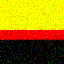

iterative denoising:  48%|████▊     | 16/33 [00:28<00:33,  1.96s/it]

Timestep t: 510, Prev Timestep: 480
Alpha Bar: 0.4767075181007385, Alpha Bar Prev: 0.523447573184967, Alpha: 0.9107072949409485
Image dtype: torch.float16
Timesteps dtype: torch.int64
Prompt embeds dtype: torch.float16
Model Output Shape: torch.Size([1, 6, 64, 64])


iterative denoising:  52%|█████▏    | 17/33 [00:30<00:32,  2.04s/it]

Model Output Min/Max: -1.45703125 1.072265625
Noise Est Min/Max: -0.853515625 1.072265625
Predicted Variance Min/Max: -1.45703125 -0.76611328125
Noise Est Shape: torch.Size([1, 3, 64, 64])
Predicted Variance Shape: torch.Size([1, 3, 64, 64])
Pred Prev Image Min/Max: -1.0 1.0
Timestep t: 480, Prev Timestep: 450
Alpha Bar: 0.523447573184967, Alpha Bar Prev: 0.5699834823608398, Alpha: 0.9183557033538818
Image dtype: torch.float16
Timesteps dtype: torch.int64
Prompt embeds dtype: torch.float16
Model Output Shape: torch.Size([1, 6, 64, 64])


iterative denoising:  55%|█████▍    | 18/33 [00:32<00:31,  2.09s/it]

Model Output Min/Max: -1.443359375 0.91943359375
Noise Est Min/Max: -0.9931640625 0.91943359375
Predicted Variance Min/Max: -1.443359375 -0.74951171875
Noise Est Shape: torch.Size([1, 3, 64, 64])
Predicted Variance Shape: torch.Size([1, 3, 64, 64])
Pred Prev Image Min/Max: -1.0 1.0
Timestep t: 450, Prev Timestep: 420
Alpha Bar: 0.5699834823608398, Alpha Bar Prev: 0.6159088611602783, Alpha: 0.9254347681999207
Image dtype: torch.float16
Timesteps dtype: torch.int64
Prompt embeds dtype: torch.float16
Model Output Shape: torch.Size([1, 6, 64, 64])


iterative denoising:  58%|█████▊    | 19/33 [00:34<00:28,  2.04s/it]

Model Output Min/Max: -1.43359375 1.0029296875
Noise Est Min/Max: -1.033203125 1.0029296875
Predicted Variance Min/Max: -1.43359375 -0.775390625
Noise Est Shape: torch.Size([1, 3, 64, 64])
Predicted Variance Shape: torch.Size([1, 3, 64, 64])
Pred Prev Image Min/Max: -1.0 1.0
Timestep t: 420, Prev Timestep: 390
Alpha Bar: 0.6159088611602783, Alpha Bar Prev: 0.6608222723007202, Alpha: 0.9320340752601624
Image dtype: torch.float16
Timesteps dtype: torch.int64
Prompt embeds dtype: torch.float16
Model Output Shape: torch.Size([1, 6, 64, 64])


iterative denoising:  61%|██████    | 20/33 [00:36<00:26,  2.07s/it]

Model Output Min/Max: -1.3896484375 1.1689453125
Noise Est Min/Max: -0.97314453125 1.1689453125
Predicted Variance Min/Max: -1.3896484375 -0.7548828125
Noise Est Shape: torch.Size([1, 3, 64, 64])
Predicted Variance Shape: torch.Size([1, 3, 64, 64])
Pred Prev Image Min/Max: -1.0 1.0
Timestep t: 390, Prev Timestep: 360
Alpha Bar: 0.6608222723007202, Alpha Bar Prev: 0.704331636428833, Alpha: 0.938226044178009
Image dtype: torch.float16
Timesteps dtype: torch.int64
Prompt embeds dtype: torch.float16
Model Output Shape: torch.Size([1, 6, 64, 64])
Model Output Min/Max: -1.34765625 1.03125
Noise Est Min/Max: -1.140625 1.03125
Predicted Variance Min/Max: -1.34765625 -0.67431640625
Noise Est Shape: torch.Size([1, 3, 64, 64])
Predicted Variance Shape: torch.Size([1, 3, 64, 64])
Pred Prev Image Min/Max: -1.0 1.0


"Timestep tensor([390], device='cuda:0')"

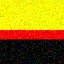

iterative denoising:  64%|██████▎   | 21/33 [00:38<00:23,  1.98s/it]

Timestep t: 360, Prev Timestep: 330
Alpha Bar: 0.704331636428833, Alpha Bar Prev: 0.7460564374923706, Alpha: 0.9440728425979614
Image dtype: torch.float16
Timesteps dtype: torch.int64
Prompt embeds dtype: torch.float16
Model Output Shape: torch.Size([1, 6, 64, 64])


iterative denoising:  67%|██████▋   | 22/33 [00:40<00:22,  2.03s/it]

Model Output Min/Max: -1.3125 1.4580078125
Noise Est Min/Max: -1.2685546875 1.4580078125
Predicted Variance Min/Max: -1.3125 -0.6455078125
Noise Est Shape: torch.Size([1, 3, 64, 64])
Predicted Variance Shape: torch.Size([1, 3, 64, 64])
Pred Prev Image Min/Max: -1.0 1.0
Timestep t: 330, Prev Timestep: 300
Alpha Bar: 0.7460564374923706, Alpha Bar Prev: 0.7856324315071106, Alpha: 0.9496253132820129
Image dtype: torch.float16
Timesteps dtype: torch.int64
Prompt embeds dtype: torch.float16
Model Output Shape: torch.Size([1, 6, 64, 64])


iterative denoising:  70%|██████▉   | 23/33 [00:42<00:20,  2.05s/it]

Model Output Min/Max: -1.28125 1.142578125
Noise Est Min/Max: -1.154296875 1.142578125
Predicted Variance Min/Max: -1.28125 -0.6279296875
Noise Est Shape: torch.Size([1, 3, 64, 64])
Predicted Variance Shape: torch.Size([1, 3, 64, 64])
Pred Prev Image Min/Max: -1.0 1.0
Timestep t: 300, Prev Timestep: 270
Alpha Bar: 0.7856324315071106, Alpha Bar Prev: 0.8227139711380005, Alpha: 0.9549278020858765
Image dtype: torch.float16
Timesteps dtype: torch.int64
Prompt embeds dtype: torch.float16
Model Output Shape: torch.Size([1, 6, 64, 64])


iterative denoising:  73%|███████▎  | 24/33 [00:45<00:19,  2.19s/it]

Model Output Min/Max: -1.2509765625 1.8232421875
Noise Est Min/Max: -1.1298828125 1.8232421875
Predicted Variance Min/Max: -1.2509765625 -0.5703125
Noise Est Shape: torch.Size([1, 3, 64, 64])
Predicted Variance Shape: torch.Size([1, 3, 64, 64])
Pred Prev Image Min/Max: -1.0 1.0
Timestep t: 270, Prev Timestep: 240
Alpha Bar: 0.8227139711380005, Alpha Bar Prev: 0.8569768071174622, Alpha: 0.9600189328193665
Image dtype: torch.float16
Timesteps dtype: torch.int64
Prompt embeds dtype: torch.float16
Model Output Shape: torch.Size([1, 6, 64, 64])


iterative denoising:  76%|███████▌  | 25/33 [00:47<00:18,  2.30s/it]

Model Output Min/Max: -1.7451171875 1.3056640625
Noise Est Min/Max: -1.7451171875 1.3056640625
Predicted Variance Min/Max: -1.232421875 -0.6083984375
Noise Est Shape: torch.Size([1, 3, 64, 64])
Predicted Variance Shape: torch.Size([1, 3, 64, 64])
Pred Prev Image Min/Max: -1.0 1.0
Timestep t: 240, Prev Timestep: 210
Alpha Bar: 0.8569768071174622, Alpha Bar Prev: 0.8881219625473022, Alpha: 0.9649314284324646
Image dtype: torch.float16
Timesteps dtype: torch.int64
Prompt embeds dtype: torch.float16
Model Output Shape: torch.Size([1, 6, 64, 64])
Model Output Min/Max: -1.3994140625 1.369140625
Noise Est Min/Max: -1.3994140625 1.369140625
Predicted Variance Min/Max: -1.2119140625 -0.72802734375
Noise Est Shape: torch.Size([1, 3, 64, 64])
Predicted Variance Shape: torch.Size([1, 3, 64, 64])
Pred Prev Image Min/Max: -1.0 1.0


"Timestep tensor([240], device='cuda:0')"

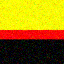

iterative denoising:  79%|███████▉  | 26/33 [00:49<00:15,  2.14s/it]

Timestep t: 210, Prev Timestep: 180
Alpha Bar: 0.8881219625473022, Alpha Bar Prev: 0.9158772230148315, Alpha: 0.9696954488754272
Image dtype: torch.float16
Timesteps dtype: torch.int64
Prompt embeds dtype: torch.float16
Model Output Shape: torch.Size([1, 6, 64, 64])


iterative denoising:  82%|████████▏ | 27/33 [00:51<00:13,  2.18s/it]

Model Output Min/Max: -1.3583984375 1.78515625
Noise Est Min/Max: -1.3583984375 1.78515625
Predicted Variance Min/Max: -1.193359375 -0.72265625
Noise Est Shape: torch.Size([1, 3, 64, 64])
Predicted Variance Shape: torch.Size([1, 3, 64, 64])
Pred Prev Image Min/Max: -1.0 1.0
Timestep t: 180, Prev Timestep: 150
Alpha Bar: 0.9158772230148315, Alpha Bar Prev: 0.9399999976158142, Alpha: 0.9743374586105347
Image dtype: torch.float16
Timesteps dtype: torch.int64
Prompt embeds dtype: torch.float16
Model Output Shape: torch.Size([1, 6, 64, 64])


iterative denoising:  85%|████████▍ | 28/33 [00:54<00:11,  2.31s/it]

Model Output Min/Max: -1.4609375 1.451171875
Noise Est Min/Max: -1.4609375 1.451171875
Predicted Variance Min/Max: -1.171875 -0.71435546875
Noise Est Shape: torch.Size([1, 3, 64, 64])
Predicted Variance Shape: torch.Size([1, 3, 64, 64])
Pred Prev Image Min/Max: -1.0 1.0
Timestep t: 150, Prev Timestep: 120
Alpha Bar: 0.9399999976158142, Alpha Bar Prev: 0.9602797627449036, Alpha: 0.9788814187049866
Image dtype: torch.float16
Timesteps dtype: torch.int64
Prompt embeds dtype: torch.float16
Model Output Shape: torch.Size([1, 6, 64, 64])


iterative denoising:  88%|████████▊ | 29/33 [00:56<00:09,  2.26s/it]

Model Output Min/Max: -1.5380859375 1.4892578125
Noise Est Min/Max: -1.5380859375 1.4892578125
Predicted Variance Min/Max: -1.1630859375 -0.65380859375
Noise Est Shape: torch.Size([1, 3, 64, 64])
Predicted Variance Shape: torch.Size([1, 3, 64, 64])
Pred Prev Image Min/Max: -1.0 1.0
Timestep t: 120, Prev Timestep: 90
Alpha Bar: 0.9602797627449036, Alpha Bar Prev: 0.9765393137931824, Alpha: 0.9833498001098633
Image dtype: torch.float16
Timesteps dtype: torch.int64
Prompt embeds dtype: torch.float16
Model Output Shape: torch.Size([1, 6, 64, 64])


iterative denoising:  91%|█████████ | 30/33 [00:58<00:06,  2.21s/it]

Model Output Min/Max: -1.5751953125 1.904296875
Noise Est Min/Max: -1.5751953125 1.904296875
Predicted Variance Min/Max: -1.18359375 -0.6103515625
Noise Est Shape: torch.Size([1, 3, 64, 64])
Predicted Variance Shape: torch.Size([1, 3, 64, 64])
Pred Prev Image Min/Max: -1.0 1.0
Timestep t: 90, Prev Timestep: 60
Alpha Bar: 0.9765393137931824, Alpha Bar Prev: 0.9886365532875061, Alpha: 0.9877637028694153
Image dtype: torch.float16
Timesteps dtype: torch.int64
Prompt embeds dtype: torch.float16
Model Output Shape: torch.Size([1, 6, 64, 64])
Model Output Min/Max: -1.8466796875 2.015625
Noise Est Min/Max: -1.8466796875 2.015625
Predicted Variance Min/Max: -1.1943359375 -0.61083984375
Noise Est Shape: torch.Size([1, 3, 64, 64])
Predicted Variance Shape: torch.Size([1, 3, 64, 64])
Pred Prev Image Min/Max: -1.0 1.0


"Timestep tensor([90], device='cuda:0')"

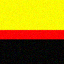

iterative denoising:  94%|█████████▍| 31/33 [01:00<00:04,  2.14s/it]

Timestep t: 60, Prev Timestep: 30
Alpha Bar: 0.9886365532875061, Alpha Bar Prev: 0.9964657425880432, Alpha: 0.9921430349349976
Image dtype: torch.float16
Timesteps dtype: torch.int64
Prompt embeds dtype: torch.float16
Model Output Shape: torch.Size([1, 6, 64, 64])


iterative denoising:  97%|█████████▋| 32/33 [01:02<00:02,  2.10s/it]

Model Output Min/Max: -1.7578125 1.7177734375
Noise Est Min/Max: -1.7578125 1.7177734375
Predicted Variance Min/Max: -1.244140625 -0.50341796875
Noise Est Shape: torch.Size([1, 3, 64, 64])
Predicted Variance Shape: torch.Size([1, 3, 64, 64])
Pred Prev Image Min/Max: -1.0 1.0
Timestep t: 30, Prev Timestep: 0
Alpha Bar: 0.9964657425880432, Alpha Bar Prev: 0.9999586939811707, Alpha: 0.996506929397583
Image dtype: torch.float16
Timesteps dtype: torch.int64
Prompt embeds dtype: torch.float16
Model Output Shape: torch.Size([1, 6, 64, 64])


iterative denoising: 100%|██████████| 33/33 [01:04<00:00,  1.96s/it]

Model Output Min/Max: -1.30078125 0.46923828125
Noise Est Min/Max: -0.50244140625 0.46923828125
Predicted Variance Min/Max: -1.30078125 -0.4072265625
Noise Est Shape: torch.Size([1, 3, 64, 64])
Predicted Variance Shape: torch.Size([1, 3, 64, 64])
Pred Prev Image Min/Max: -1.0 1.0


Noisy 990,Iterative

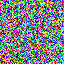
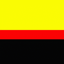

iterative denoising:   0%|          | 0/33 [00:00<?, ?it/s]

Timestep t: 990, Prev Timestep: 960
Alpha Bar: 0.00019671733025461435, Alpha Bar Prev: 0.0036896108649671078, Alpha: 0.05331655219197273
Image dtype: torch.float16
Timesteps dtype: torch.int64
Prompt embeds dtype: torch.float16
Model Output Shape: torch.Size([1, 6, 64, 64])
Model Output Min/Max: -4.03125 3.4921875
Noise Est Min/Max: -3.0 3.0
Predicted Variance Min/Max: -1.2734375 -0.68603515625
Noise Est Shape: torch.Size([1, 3, 64, 64])
Predicted Variance Shape: torch.Size([1, 3, 64, 64])
Pred Prev Image Min/Max: -1.0 1.0


"Timestep tensor([990], device='cuda:0')"

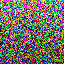

iterative denoising:   3%|▎         | 1/33 [00:01<00:52,  1.65s/it]

Timestep t: 960, Prev Timestep: 930
Alpha Bar: 0.0036896108649671078, Alpha Bar Prev: 0.01151887234300375, Alpha: 0.3203100860118866
Image dtype: torch.float16
Timesteps dtype: torch.int64
Prompt embeds dtype: torch.float16
Model Output Shape: torch.Size([1, 6, 64, 64])


iterative denoising:   6%|▌         | 2/33 [00:03<00:50,  1.63s/it]

Model Output Min/Max: -1.373046875 1.09375
Noise Est Min/Max: -1.02734375 1.09375
Predicted Variance Min/Max: -1.373046875 -0.74951171875
Noise Est Shape: torch.Size([1, 3, 64, 64])
Predicted Variance Shape: torch.Size([1, 3, 64, 64])
Pred Prev Image Min/Max: -1.0 1.0
Timestep t: 930, Prev Timestep: 900
Alpha Bar: 0.01151887234300375, Alpha Bar Prev: 0.023616107180714607, Alpha: 0.4877549111843109
Image dtype: torch.float16
Timesteps dtype: torch.int64
Prompt embeds dtype: torch.float16
Model Output Shape: torch.Size([1, 6, 64, 64])


iterative denoising:   9%|▉         | 3/33 [00:04<00:49,  1.65s/it]

Model Output Min/Max: -1.583984375 1.3447265625
Noise Est Min/Max: -0.89794921875 1.3447265625
Predicted Variance Min/Max: -1.583984375 -0.59765625
Noise Est Shape: torch.Size([1, 3, 64, 64])
Predicted Variance Shape: torch.Size([1, 3, 64, 64])
Pred Prev Image Min/Max: -1.0 1.0
Timestep t: 900, Prev Timestep: 870
Alpha Bar: 0.023616107180714607, Alpha Bar Prev: 0.03987564146518707, Alpha: 0.5922439694404602
Image dtype: torch.float16
Timesteps dtype: torch.int64
Prompt embeds dtype: torch.float16
Model Output Shape: torch.Size([1, 6, 64, 64])


iterative denoising:  12%|█▏        | 4/33 [00:07<00:55,  1.90s/it]

Model Output Min/Max: -1.5869140625 1.6337890625
Noise Est Min/Max: -0.41748046875 1.6337890625
Predicted Variance Min/Max: -1.5869140625 -0.8701171875
Noise Est Shape: torch.Size([1, 3, 64, 64])
Predicted Variance Shape: torch.Size([1, 3, 64, 64])
Pred Prev Image Min/Max: -1.0 -1.0
Timestep t: 870, Prev Timestep: 840
Alpha Bar: 0.03987564146518707, Alpha Bar Prev: 0.06015542894601822, Alpha: 0.6628768444061279
Image dtype: torch.float16
Timesteps dtype: torch.int64
Prompt embeds dtype: torch.float16
Model Output Shape: torch.Size([1, 6, 64, 64])


iterative denoising:  15%|█▌        | 5/33 [00:09<00:56,  2.01s/it]

Model Output Min/Max: -1.5703125 -0.2384033203125
Noise Est Min/Max: -0.37060546875 -0.2384033203125
Predicted Variance Min/Max: -1.5703125 -0.931640625
Noise Est Shape: torch.Size([1, 3, 64, 64])
Predicted Variance Shape: torch.Size([1, 3, 64, 64])
Pred Prev Image Min/Max: -1.0 -1.0
Timestep t: 840, Prev Timestep: 810
Alpha Bar: 0.06015542894601822, Alpha Bar Prev: 0.08427829295396805, Alpha: 0.7137713432312012
Image dtype: torch.float16
Timesteps dtype: torch.int64
Prompt embeds dtype: torch.float16
Model Output Shape: torch.Size([1, 6, 64, 64])
Model Output Min/Max: -1.56640625 -0.231689453125
Noise Est Min/Max: -0.359375 -0.231689453125
Predicted Variance Min/Max: -1.56640625 -0.9501953125
Noise Est Shape: torch.Size([1, 3, 64, 64])
Predicted Variance Shape: torch.Size([1, 3, 64, 64])
Pred Prev Image Min/Max: -1.0 -1.0


"Timestep tensor([840], device='cuda:0')"

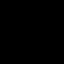

iterative denoising:  18%|█▊        | 6/33 [00:11<00:55,  2.07s/it]

Timestep t: 810, Prev Timestep: 780
Alpha Bar: 0.08427829295396805, Alpha Bar Prev: 0.11203352361917496, Alpha: 0.7522596120834351
Image dtype: torch.float16
Timesteps dtype: torch.int64
Prompt embeds dtype: torch.float16
Model Output Shape: torch.Size([1, 6, 64, 64])


iterative denoising:  21%|██        | 7/33 [00:14<00:57,  2.21s/it]

Model Output Min/Max: -1.5556640625 -0.22900390625
Noise Est Min/Max: -0.35302734375 -0.22900390625
Predicted Variance Min/Max: -1.5556640625 -0.962890625
Noise Est Shape: torch.Size([1, 3, 64, 64])
Predicted Variance Shape: torch.Size([1, 3, 64, 64])
Pred Prev Image Min/Max: -1.0 -1.0
Timestep t: 780, Prev Timestep: 750
Alpha Bar: 0.11203352361917496, Alpha Bar Prev: 0.14317865669727325, Alpha: 0.782473623752594
Image dtype: torch.float16
Timesteps dtype: torch.int64
Prompt embeds dtype: torch.float16
Model Output Shape: torch.Size([1, 6, 64, 64])


iterative denoising:  24%|██▍       | 8/33 [00:16<00:53,  2.14s/it]

Model Output Min/Max: -1.55078125 -0.2274169921875
Noise Est Min/Max: -0.3466796875 -0.2274169921875
Predicted Variance Min/Max: -1.55078125 -0.9755859375
Noise Est Shape: torch.Size([1, 3, 64, 64])
Predicted Variance Shape: torch.Size([1, 3, 64, 64])
Pred Prev Image Min/Max: -1.0 -1.0
Timestep t: 750, Prev Timestep: 720
Alpha Bar: 0.14317865669727325, Alpha Bar Prev: 0.17744159698486328, Alpha: 0.8069058060646057
Image dtype: torch.float16
Timesteps dtype: torch.int64
Prompt embeds dtype: torch.float16
Model Output Shape: torch.Size([1, 6, 64, 64])


iterative denoising:  27%|██▋       | 9/33 [00:18<00:50,  2.11s/it]

Model Output Min/Max: -1.544921875 -0.2274169921875
Noise Est Min/Max: -0.33984375 -0.2274169921875
Predicted Variance Min/Max: -1.544921875 -0.9873046875
Noise Est Shape: torch.Size([1, 3, 64, 64])
Predicted Variance Shape: torch.Size([1, 3, 64, 64])
Pred Prev Image Min/Max: -1.0 -0.8366876244544983
Timestep t: 720, Prev Timestep: 690
Alpha Bar: 0.17744159698486328, Alpha Bar Prev: 0.21452300250530243, Alpha: 0.8271448612213135
Image dtype: torch.float16
Timesteps dtype: torch.int64
Prompt embeds dtype: torch.float16
Model Output Shape: torch.Size([1, 6, 64, 64])


iterative denoising:  30%|███       | 10/33 [00:20<00:47,  2.07s/it]

Model Output Min/Max: -1.541015625 -0.153076171875
Noise Est Min/Max: -0.333984375 -0.153076171875
Predicted Variance Min/Max: -1.541015625 -0.99755859375
Noise Est Shape: torch.Size([1, 3, 64, 64])
Predicted Variance Shape: torch.Size([1, 3, 64, 64])
Pred Prev Image Min/Max: -1.0 -0.681640625
Timestep t: 690, Prev Timestep: 660
Alpha Bar: 0.21452300250530243, Alpha Bar Prev: 0.2540990114212036, Alpha: 0.8442496657371521
Image dtype: torch.float16
Timesteps dtype: torch.int64
Prompt embeds dtype: torch.float16
Model Output Shape: torch.Size([1, 6, 64, 64])
Model Output Min/Max: -1.5361328125 0.0411376953125
Noise Est Min/Max: -0.3291015625 0.0411376953125
Predicted Variance Min/Max: -1.5361328125 -1.0068359375
Noise Est Shape: torch.Size([1, 3, 64, 64])
Predicted Variance Shape: torch.Size([1, 3, 64, 64])
Pred Prev Image Min/Max: -1.0 -0.5556640625


"Timestep tensor([690], device='cuda:0')"

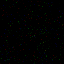

iterative denoising:  33%|███▎      | 11/33 [00:22<00:50,  2.28s/it]

Timestep t: 660, Prev Timestep: 630
Alpha Bar: 0.2540990114212036, Alpha Bar Prev: 0.2958238124847412, Alpha: 0.8589538931846619
Image dtype: torch.float16
Timesteps dtype: torch.int64
Prompt embeds dtype: torch.float16
Model Output Shape: torch.Size([1, 6, 64, 64])


iterative denoising:  36%|███▋      | 12/33 [00:25<00:46,  2.24s/it]

Model Output Min/Max: -1.5390625 0.1983642578125
Noise Est Min/Max: -0.32373046875 0.1983642578125
Predicted Variance Min/Max: -1.5390625 -1.015625
Noise Est Shape: torch.Size([1, 3, 64, 64])
Predicted Variance Shape: torch.Size([1, 3, 64, 64])
Pred Prev Image Min/Max: -1.0 -0.4345703125
Timestep t: 630, Prev Timestep: 600
Alpha Bar: 0.2958238124847412, Alpha Bar Prev: 0.3393329381942749, Alpha: 0.8717803955078125
Image dtype: torch.float16
Timesteps dtype: torch.int64
Prompt embeds dtype: torch.float16
Model Output Shape: torch.Size([1, 6, 64, 64])


iterative denoising:  39%|███▉      | 13/33 [00:26<00:42,  2.10s/it]

Model Output Min/Max: -1.5439453125 0.3525390625
Noise Est Min/Max: -0.318359375 0.3525390625
Predicted Variance Min/Max: -1.5439453125 -1.0341796875
Noise Est Shape: torch.Size([1, 3, 64, 64])
Predicted Variance Shape: torch.Size([1, 3, 64, 64])
Pred Prev Image Min/Max: -1.0 -0.3671875
Timestep t: 600, Prev Timestep: 570
Alpha Bar: 0.3393329381942749, Alpha Bar Prev: 0.3842463195323944, Alpha: 0.8831130266189575
Image dtype: torch.float16
Timesteps dtype: torch.int64
Prompt embeds dtype: torch.float16
Model Output Shape: torch.Size([1, 6, 64, 64])


iterative denoising:  42%|████▏     | 14/33 [00:28<00:38,  2.05s/it]

Model Output Min/Max: -1.541015625 0.466796875
Noise Est Min/Max: -0.3125 0.466796875
Predicted Variance Min/Max: -1.541015625 -1.029296875
Noise Est Shape: torch.Size([1, 3, 64, 64])
Predicted Variance Shape: torch.Size([1, 3, 64, 64])
Pred Prev Image Min/Max: -1.0 -0.29296875
Timestep t: 570, Prev Timestep: 540
Alpha Bar: 0.3842463195323944, Alpha Bar Prev: 0.4301716089248657, Alpha: 0.8932396173477173
Image dtype: torch.float16
Timesteps dtype: torch.int64
Prompt embeds dtype: torch.float16
Model Output Shape: torch.Size([1, 6, 64, 64])


iterative denoising:  45%|████▌     | 15/33 [00:30<00:35,  1.94s/it]

Model Output Min/Max: -1.529296875 0.58837890625
Noise Est Min/Max: -0.310546875 0.58837890625
Predicted Variance Min/Max: -1.529296875 -1.033203125
Noise Est Shape: torch.Size([1, 3, 64, 64])
Predicted Variance Shape: torch.Size([1, 3, 64, 64])
Pred Prev Image Min/Max: -1.0 -0.2412109375
Timestep t: 540, Prev Timestep: 510
Alpha Bar: 0.4301716089248657, Alpha Bar Prev: 0.4767075181007385, Alpha: 0.9023805856704712
Image dtype: torch.float16
Timesteps dtype: torch.int64
Prompt embeds dtype: torch.float16
Model Output Shape: torch.Size([1, 6, 64, 64])
Model Output Min/Max: -1.529296875 0.7001953125
Noise Est Min/Max: -0.3056640625 0.7001953125
Predicted Variance Min/Max: -1.529296875 -1.0302734375
Noise Est Shape: torch.Size([1, 3, 64, 64])
Predicted Variance Shape: torch.Size([1, 3, 64, 64])
Pred Prev Image Min/Max: -1.0 -0.181640625


"Timestep tensor([540], device='cuda:0')"

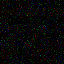

iterative denoising:  48%|████▊     | 16/33 [00:32<00:31,  1.88s/it]

Timestep t: 510, Prev Timestep: 480
Alpha Bar: 0.4767075181007385, Alpha Bar Prev: 0.523447573184967, Alpha: 0.9107072949409485
Image dtype: torch.float16
Timesteps dtype: torch.int64
Prompt embeds dtype: torch.float16
Model Output Shape: torch.Size([1, 6, 64, 64])


iterative denoising:  52%|█████▏    | 17/33 [00:34<00:30,  1.90s/it]

Model Output Min/Max: -1.505859375 0.82861328125
Noise Est Min/Max: -0.302490234375 0.82861328125
Predicted Variance Min/Max: -1.505859375 -1.03515625
Noise Est Shape: torch.Size([1, 3, 64, 64])
Predicted Variance Shape: torch.Size([1, 3, 64, 64])
Pred Prev Image Min/Max: -1.0 -0.17578125
Timestep t: 480, Prev Timestep: 450
Alpha Bar: 0.523447573184967, Alpha Bar Prev: 0.5699834823608398, Alpha: 0.9183557033538818
Image dtype: torch.float16
Timesteps dtype: torch.int64
Prompt embeds dtype: torch.float16
Model Output Shape: torch.Size([1, 6, 64, 64])


iterative denoising:  55%|█████▍    | 18/33 [00:35<00:27,  1.86s/it]

Model Output Min/Max: -1.486328125 0.92236328125
Noise Est Min/Max: -0.299560546875 0.92236328125
Predicted Variance Min/Max: -1.486328125 -1.021484375
Noise Est Shape: torch.Size([1, 3, 64, 64])
Predicted Variance Shape: torch.Size([1, 3, 64, 64])
Pred Prev Image Min/Max: -1.0 -0.1537693738937378
Timestep t: 450, Prev Timestep: 420
Alpha Bar: 0.5699834823608398, Alpha Bar Prev: 0.6159088611602783, Alpha: 0.9254347681999207
Image dtype: torch.float16
Timesteps dtype: torch.int64
Prompt embeds dtype: torch.float16
Model Output Shape: torch.Size([1, 6, 64, 64])


iterative denoising:  58%|█████▊    | 19/33 [00:37<00:25,  1.84s/it]

Model Output Min/Max: -1.46875 1.0146484375
Noise Est Min/Max: -0.29345703125 1.0146484375
Predicted Variance Min/Max: -1.46875 -1.0517578125
Noise Est Shape: torch.Size([1, 3, 64, 64])
Predicted Variance Shape: torch.Size([1, 3, 64, 64])
Pred Prev Image Min/Max: -1.0 -0.19233131408691406
Timestep t: 420, Prev Timestep: 390
Alpha Bar: 0.6159088611602783, Alpha Bar Prev: 0.6608222723007202, Alpha: 0.9320340752601624
Image dtype: torch.float16
Timesteps dtype: torch.int64
Prompt embeds dtype: torch.float16
Model Output Shape: torch.Size([1, 6, 64, 64])


iterative denoising:  61%|██████    | 20/33 [00:39<00:24,  1.85s/it]

Model Output Min/Max: -1.419921875 1.0166015625
Noise Est Min/Max: -0.28515625 1.0166015625
Predicted Variance Min/Max: -1.419921875 -1.025390625
Noise Est Shape: torch.Size([1, 3, 64, 64])
Predicted Variance Shape: torch.Size([1, 3, 64, 64])
Pred Prev Image Min/Max: -1.0 -0.12942326068878174
Timestep t: 390, Prev Timestep: 360
Alpha Bar: 0.6608222723007202, Alpha Bar Prev: 0.704331636428833, Alpha: 0.938226044178009
Image dtype: torch.float16
Timesteps dtype: torch.int64
Prompt embeds dtype: torch.float16
Model Output Shape: torch.Size([1, 6, 64, 64])
Model Output Min/Max: -1.3974609375 1.240234375
Noise Est Min/Max: -0.2666015625 1.240234375
Predicted Variance Min/Max: -1.3974609375 -1.025390625
Noise Est Shape: torch.Size([1, 3, 64, 64])
Predicted Variance Shape: torch.Size([1, 3, 64, 64])
Pred Prev Image Min/Max: -1.0 -0.13872790336608887


"Timestep tensor([390], device='cuda:0')"

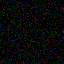

iterative denoising:  64%|██████▎   | 21/33 [00:41<00:22,  1.90s/it]

Timestep t: 360, Prev Timestep: 330
Alpha Bar: 0.704331636428833, Alpha Bar Prev: 0.7460564374923706, Alpha: 0.9440728425979614
Image dtype: torch.float16
Timesteps dtype: torch.int64
Prompt embeds dtype: torch.float16
Model Output Shape: torch.Size([1, 6, 64, 64])


iterative denoising:  67%|██████▋   | 22/33 [00:43<00:20,  1.84s/it]

Model Output Min/Max: -1.3759765625 1.34765625
Noise Est Min/Max: -0.256103515625 1.34765625
Predicted Variance Min/Max: -1.3759765625 -1.037109375
Noise Est Shape: torch.Size([1, 3, 64, 64])
Predicted Variance Shape: torch.Size([1, 3, 64, 64])
Pred Prev Image Min/Max: -1.0 -0.2555869221687317
Timestep t: 330, Prev Timestep: 300
Alpha Bar: 0.7460564374923706, Alpha Bar Prev: 0.7856324315071106, Alpha: 0.9496253132820129
Image dtype: torch.float16
Timesteps dtype: torch.int64
Prompt embeds dtype: torch.float16
Model Output Shape: torch.Size([1, 6, 64, 64])


iterative denoising:  70%|██████▉   | 23/33 [00:44<00:17,  1.78s/it]

Model Output Min/Max: -1.3505859375 1.25
Noise Est Min/Max: -0.232666015625 1.25
Predicted Variance Min/Max: -1.3505859375 -1.0595703125
Noise Est Shape: torch.Size([1, 3, 64, 64])
Predicted Variance Shape: torch.Size([1, 3, 64, 64])
Pred Prev Image Min/Max: -1.0 -0.315990149974823
Timestep t: 300, Prev Timestep: 270
Alpha Bar: 0.7856324315071106, Alpha Bar Prev: 0.8227139711380005, Alpha: 0.9549278020858765
Image dtype: torch.float16
Timesteps dtype: torch.int64
Prompt embeds dtype: torch.float16
Model Output Shape: torch.Size([1, 6, 64, 64])


iterative denoising:  73%|███████▎  | 24/33 [00:47<00:17,  1.91s/it]

Model Output Min/Max: -1.341796875 1.255859375
Noise Est Min/Max: -0.2215576171875 1.255859375
Predicted Variance Min/Max: -1.341796875 -1.0087890625
Noise Est Shape: torch.Size([1, 3, 64, 64])
Predicted Variance Shape: torch.Size([1, 3, 64, 64])
Pred Prev Image Min/Max: -1.0 -0.3983317017555237
Timestep t: 270, Prev Timestep: 240
Alpha Bar: 0.8227139711380005, Alpha Bar Prev: 0.8569768071174622, Alpha: 0.9600189328193665
Image dtype: torch.float16
Timesteps dtype: torch.int64
Prompt embeds dtype: torch.float16
Model Output Shape: torch.Size([1, 6, 64, 64])


iterative denoising:  76%|███████▌  | 25/33 [00:48<00:14,  1.87s/it]

Model Output Min/Max: -1.306640625 1.21875
Noise Est Min/Max: -0.220703125 1.21875
Predicted Variance Min/Max: -1.306640625 -0.97607421875
Noise Est Shape: torch.Size([1, 3, 64, 64])
Predicted Variance Shape: torch.Size([1, 3, 64, 64])
Pred Prev Image Min/Max: -1.0 -0.4007280468940735
Timestep t: 240, Prev Timestep: 210
Alpha Bar: 0.8569768071174622, Alpha Bar Prev: 0.8881219625473022, Alpha: 0.9649314284324646
Image dtype: torch.float16
Timesteps dtype: torch.int64
Prompt embeds dtype: torch.float16
Model Output Shape: torch.Size([1, 6, 64, 64])
Model Output Min/Max: -1.26171875 1.3857421875
Noise Est Min/Max: -0.211181640625 1.3857421875
Predicted Variance Min/Max: -1.26171875 -0.97998046875
Noise Est Shape: torch.Size([1, 3, 64, 64])
Predicted Variance Shape: torch.Size([1, 3, 64, 64])
Pred Prev Image Min/Max: -1.0 -0.4507029056549072


"Timestep tensor([240], device='cuda:0')"

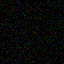

iterative denoising:  79%|███████▉  | 26/33 [00:50<00:12,  1.77s/it]

Timestep t: 210, Prev Timestep: 180
Alpha Bar: 0.8881219625473022, Alpha Bar Prev: 0.9158772230148315, Alpha: 0.9696954488754272
Image dtype: torch.float16
Timesteps dtype: torch.int64
Prompt embeds dtype: torch.float16
Model Output Shape: torch.Size([1, 6, 64, 64])


iterative denoising:  82%|████████▏ | 27/33 [00:52<00:10,  1.72s/it]

Model Output Min/Max: -1.220703125 1.4443359375
Noise Est Min/Max: -0.2371826171875 1.4443359375
Predicted Variance Min/Max: -1.220703125 -0.9482421875
Noise Est Shape: torch.Size([1, 3, 64, 64])
Predicted Variance Shape: torch.Size([1, 3, 64, 64])
Pred Prev Image Min/Max: -1.0 -0.4697827100753784
Timestep t: 180, Prev Timestep: 150
Alpha Bar: 0.9158772230148315, Alpha Bar Prev: 0.9399999976158142, Alpha: 0.9743374586105347
Image dtype: torch.float16
Timesteps dtype: torch.int64
Prompt embeds dtype: torch.float16
Model Output Shape: torch.Size([1, 6, 64, 64])


iterative denoising:  85%|████████▍ | 28/33 [00:54<00:09,  1.87s/it]

Model Output Min/Max: -1.1865234375 1.625
Noise Est Min/Max: -0.290771484375 1.625
Predicted Variance Min/Max: -1.1865234375 -0.90478515625
Noise Est Shape: torch.Size([1, 3, 64, 64])
Predicted Variance Shape: torch.Size([1, 3, 64, 64])
Pred Prev Image Min/Max: -1.0 -0.526008129119873
Timestep t: 150, Prev Timestep: 120
Alpha Bar: 0.9399999976158142, Alpha Bar Prev: 0.9602797627449036, Alpha: 0.9788814187049866
Image dtype: torch.float16
Timesteps dtype: torch.int64
Prompt embeds dtype: torch.float16
Model Output Shape: torch.Size([1, 6, 64, 64])


iterative denoising:  88%|████████▊ | 29/33 [00:56<00:07,  1.90s/it]

Model Output Min/Max: -1.150390625 1.7060546875
Noise Est Min/Max: -0.278564453125 1.7060546875
Predicted Variance Min/Max: -1.150390625 -0.9189453125
Noise Est Shape: torch.Size([1, 3, 64, 64])
Predicted Variance Shape: torch.Size([1, 3, 64, 64])
Pred Prev Image Min/Max: -1.0 -0.5869590640068054
Timestep t: 120, Prev Timestep: 90
Alpha Bar: 0.9602797627449036, Alpha Bar Prev: 0.9765393137931824, Alpha: 0.9833498001098633
Image dtype: torch.float16
Timesteps dtype: torch.int64
Prompt embeds dtype: torch.float16
Model Output Shape: torch.Size([1, 6, 64, 64])


iterative denoising:  91%|█████████ | 30/33 [00:58<00:05,  1.93s/it]

Model Output Min/Max: -1.1328125 1.796875
Noise Est Min/Max: -0.33154296875 1.796875
Predicted Variance Min/Max: -1.1328125 -0.94140625
Noise Est Shape: torch.Size([1, 3, 64, 64])
Predicted Variance Shape: torch.Size([1, 3, 64, 64])
Pred Prev Image Min/Max: -1.0 -0.6944453716278076
Timestep t: 90, Prev Timestep: 60
Alpha Bar: 0.9765393137931824, Alpha Bar Prev: 0.9886365532875061, Alpha: 0.9877637028694153
Image dtype: torch.float16
Timesteps dtype: torch.int64
Prompt embeds dtype: torch.float16
Model Output Shape: torch.Size([1, 6, 64, 64])
Model Output Min/Max: -1.126953125 1.6943359375
Noise Est Min/Max: -0.3544921875 1.6943359375
Predicted Variance Min/Max: -1.126953125 -0.9326171875
Noise Est Shape: torch.Size([1, 3, 64, 64])
Predicted Variance Shape: torch.Size([1, 3, 64, 64])
Pred Prev Image Min/Max: -1.0 -0.7761067152023315


"Timestep tensor([90], device='cuda:0')"

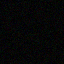

iterative denoising:  94%|█████████▍| 31/33 [00:59<00:03,  1.87s/it]

Timestep t: 60, Prev Timestep: 30
Alpha Bar: 0.9886365532875061, Alpha Bar Prev: 0.9964657425880432, Alpha: 0.9921430349349976
Image dtype: torch.float16
Timesteps dtype: torch.int64
Prompt embeds dtype: torch.float16
Model Output Shape: torch.Size([1, 6, 64, 64])


iterative denoising:  97%|█████████▋| 32/33 [01:01<00:01,  1.81s/it]

Model Output Min/Max: -1.1123046875 1.7099609375
Noise Est Min/Max: -0.447265625 1.7099609375
Predicted Variance Min/Max: -1.1123046875 -0.916015625
Noise Est Shape: torch.Size([1, 3, 64, 64])
Predicted Variance Shape: torch.Size([1, 3, 64, 64])
Pred Prev Image Min/Max: -0.9848187565803528 -0.931763768196106
Timestep t: 30, Prev Timestep: 0
Alpha Bar: 0.9964657425880432, Alpha Bar Prev: 0.9999586939811707, Alpha: 0.996506929397583
Image dtype: torch.float16
Timesteps dtype: torch.int64
Prompt embeds dtype: torch.float16
Model Output Shape: torch.Size([1, 6, 64, 64])


iterative denoising: 100%|██████████| 33/33 [01:03<00:00,  1.92s/it]

Model Output Min/Max: -1.1171875 0.52490234375
Noise Est Min/Max: -0.4267578125 0.52490234375
Predicted Variance Min/Max: -1.1171875 -0.921875
Noise Est Shape: torch.Size([1, 3, 64, 64])
Predicted Variance Shape: torch.Size([1, 3, 64, 64])
Pred Prev Image Min/Max: -0.96630859375 -0.96142578125


Noisy 990,Iterative

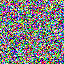
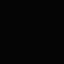

iterative denoising:   0%|          | 0/33 [00:00<?, ?it/s]

Timestep t: 990, Prev Timestep: 960
Alpha Bar: 0.00019671733025461435, Alpha Bar Prev: 0.0036896108649671078, Alpha: 0.05331655219197273
Image dtype: torch.float16
Timesteps dtype: torch.int64
Prompt embeds dtype: torch.float16
Model Output Shape: torch.Size([1, 6, 64, 64])
Model Output Min/Max: -3.798828125 3.6484375
Noise Est Min/Max: -3.0 3.0
Predicted Variance Min/Max: -1.220703125 -0.68701171875
Noise Est Shape: torch.Size([1, 3, 64, 64])
Predicted Variance Shape: torch.Size([1, 3, 64, 64])
Pred Prev Image Min/Max: -1.0 1.0


"Timestep tensor([990], device='cuda:0')"

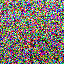

iterative denoising:   3%|▎         | 1/33 [00:02<01:04,  2.03s/it]

Timestep t: 960, Prev Timestep: 930
Alpha Bar: 0.0036896108649671078, Alpha Bar Prev: 0.01151887234300375, Alpha: 0.3203100860118866
Image dtype: torch.float16
Timesteps dtype: torch.int64
Prompt embeds dtype: torch.float16
Model Output Shape: torch.Size([1, 6, 64, 64])


iterative denoising:   6%|▌         | 2/33 [00:03<00:57,  1.87s/it]

Model Output Min/Max: -1.287109375 1.078125
Noise Est Min/Max: -1.0322265625 1.078125
Predicted Variance Min/Max: -1.287109375 -0.7568359375
Noise Est Shape: torch.Size([1, 3, 64, 64])
Predicted Variance Shape: torch.Size([1, 3, 64, 64])
Pred Prev Image Min/Max: -1.0 1.0
Timestep t: 930, Prev Timestep: 900
Alpha Bar: 0.01151887234300375, Alpha Bar Prev: 0.023616107180714607, Alpha: 0.4877549111843109
Image dtype: torch.float16
Timesteps dtype: torch.int64
Prompt embeds dtype: torch.float16
Model Output Shape: torch.Size([1, 6, 64, 64])


iterative denoising:   9%|▉         | 3/33 [00:05<00:55,  1.85s/it]

Model Output Min/Max: -1.626953125 1.259765625
Noise Est Min/Max: -0.95458984375 1.259765625
Predicted Variance Min/Max: -1.626953125 -0.76904296875
Noise Est Shape: torch.Size([1, 3, 64, 64])
Predicted Variance Shape: torch.Size([1, 3, 64, 64])
Pred Prev Image Min/Max: -1.0 1.0
Timestep t: 900, Prev Timestep: 870
Alpha Bar: 0.023616107180714607, Alpha Bar Prev: 0.03987564146518707, Alpha: 0.5922439694404602
Image dtype: torch.float16
Timesteps dtype: torch.int64
Prompt embeds dtype: torch.float16
Model Output Shape: torch.Size([1, 6, 64, 64])


iterative denoising:  12%|█▏        | 4/33 [00:07<00:51,  1.77s/it]

Model Output Min/Max: -1.60546875 1.220703125
Noise Est Min/Max: -0.943359375 1.220703125
Predicted Variance Min/Max: -1.60546875 -0.85888671875
Noise Est Shape: torch.Size([1, 3, 64, 64])
Predicted Variance Shape: torch.Size([1, 3, 64, 64])
Pred Prev Image Min/Max: -1.0 1.0
Timestep t: 870, Prev Timestep: 840
Alpha Bar: 0.03987564146518707, Alpha Bar Prev: 0.06015542894601822, Alpha: 0.6628768444061279
Image dtype: torch.float16
Timesteps dtype: torch.int64
Prompt embeds dtype: torch.float16
Model Output Shape: torch.Size([1, 6, 64, 64])


iterative denoising:  15%|█▌        | 5/33 [00:08<00:47,  1.69s/it]

Model Output Min/Max: -1.591796875 1.3115234375
Noise Est Min/Max: -0.958984375 1.3115234375
Predicted Variance Min/Max: -1.591796875 -0.8671875
Noise Est Shape: torch.Size([1, 3, 64, 64])
Predicted Variance Shape: torch.Size([1, 3, 64, 64])
Pred Prev Image Min/Max: -1.0 1.0
Timestep t: 840, Prev Timestep: 810
Alpha Bar: 0.06015542894601822, Alpha Bar Prev: 0.08427829295396805, Alpha: 0.7137713432312012
Image dtype: torch.float16
Timesteps dtype: torch.int64
Prompt embeds dtype: torch.float16
Model Output Shape: torch.Size([1, 6, 64, 64])
Model Output Min/Max: -1.583984375 1.2412109375
Noise Est Min/Max: -0.90185546875 1.2412109375
Predicted Variance Min/Max: -1.583984375 -0.90185546875
Noise Est Shape: torch.Size([1, 3, 64, 64])
Predicted Variance Shape: torch.Size([1, 3, 64, 64])
Pred Prev Image Min/Max: -1.0 1.0


"Timestep tensor([840], device='cuda:0')"

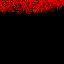

iterative denoising:  18%|█▊        | 6/33 [00:11<00:53,  1.97s/it]

Timestep t: 810, Prev Timestep: 780
Alpha Bar: 0.08427829295396805, Alpha Bar Prev: 0.11203352361917496, Alpha: 0.7522596120834351
Image dtype: torch.float16
Timesteps dtype: torch.int64
Prompt embeds dtype: torch.float16
Model Output Shape: torch.Size([1, 6, 64, 64])


iterative denoising:  21%|██        | 7/33 [00:13<00:50,  1.95s/it]

Model Output Min/Max: -1.57421875 1.2099609375
Noise Est Min/Max: -0.94091796875 1.2099609375
Predicted Variance Min/Max: -1.57421875 -0.8876953125
Noise Est Shape: torch.Size([1, 3, 64, 64])
Predicted Variance Shape: torch.Size([1, 3, 64, 64])
Pred Prev Image Min/Max: -1.0 1.0
Timestep t: 780, Prev Timestep: 750
Alpha Bar: 0.11203352361917496, Alpha Bar Prev: 0.14317865669727325, Alpha: 0.782473623752594
Image dtype: torch.float16
Timesteps dtype: torch.int64
Prompt embeds dtype: torch.float16
Model Output Shape: torch.Size([1, 6, 64, 64])


iterative denoising:  24%|██▍       | 8/33 [00:14<00:45,  1.84s/it]

Model Output Min/Max: -1.564453125 1.1123046875
Noise Est Min/Max: -0.7666015625 1.1123046875
Predicted Variance Min/Max: -1.564453125 -0.884765625
Noise Est Shape: torch.Size([1, 3, 64, 64])
Predicted Variance Shape: torch.Size([1, 3, 64, 64])
Pred Prev Image Min/Max: -1.0 1.0
Timestep t: 750, Prev Timestep: 720
Alpha Bar: 0.14317865669727325, Alpha Bar Prev: 0.17744159698486328, Alpha: 0.8069058060646057
Image dtype: torch.float16
Timesteps dtype: torch.int64
Prompt embeds dtype: torch.float16
Model Output Shape: torch.Size([1, 6, 64, 64])


iterative denoising:  27%|██▋       | 9/33 [00:16<00:42,  1.77s/it]

Model Output Min/Max: -1.556640625 1.2978515625
Noise Est Min/Max: -0.78857421875 1.2978515625
Predicted Variance Min/Max: -1.556640625 -0.8798828125
Noise Est Shape: torch.Size([1, 3, 64, 64])
Predicted Variance Shape: torch.Size([1, 3, 64, 64])
Pred Prev Image Min/Max: -1.0 1.0
Timestep t: 720, Prev Timestep: 690
Alpha Bar: 0.17744159698486328, Alpha Bar Prev: 0.21452300250530243, Alpha: 0.8271448612213135
Image dtype: torch.float16
Timesteps dtype: torch.int64
Prompt embeds dtype: torch.float16
Model Output Shape: torch.Size([1, 6, 64, 64])


iterative denoising:  30%|███       | 10/33 [00:18<00:41,  1.80s/it]

Model Output Min/Max: -1.548828125 1.2216796875
Noise Est Min/Max: -0.8046875 1.2216796875
Predicted Variance Min/Max: -1.548828125 -0.88037109375
Noise Est Shape: torch.Size([1, 3, 64, 64])
Predicted Variance Shape: torch.Size([1, 3, 64, 64])
Pred Prev Image Min/Max: -1.0 1.0
Timestep t: 690, Prev Timestep: 660
Alpha Bar: 0.21452300250530243, Alpha Bar Prev: 0.2540990114212036, Alpha: 0.8442496657371521
Image dtype: torch.float16
Timesteps dtype: torch.int64
Prompt embeds dtype: torch.float16
Model Output Shape: torch.Size([1, 6, 64, 64])
Model Output Min/Max: -1.54296875 1.30859375
Noise Est Min/Max: -0.595703125 1.30859375
Predicted Variance Min/Max: -1.54296875 -0.86474609375
Noise Est Shape: torch.Size([1, 3, 64, 64])
Predicted Variance Shape: torch.Size([1, 3, 64, 64])
Pred Prev Image Min/Max: -1.0 1.0


"Timestep tensor([690], device='cuda:0')"

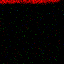

iterative denoising:  33%|███▎      | 11/33 [00:20<00:40,  1.85s/it]

Timestep t: 660, Prev Timestep: 630
Alpha Bar: 0.2540990114212036, Alpha Bar Prev: 0.2958238124847412, Alpha: 0.8589538931846619
Image dtype: torch.float16
Timesteps dtype: torch.int64
Prompt embeds dtype: torch.float16


iterative denoising:  36%|███▋      | 12/33 [00:22<00:42,  2.04s/it]

Model Output Shape: torch.Size([1, 6, 64, 64])
Model Output Min/Max: -1.5458984375 1.2734375
Noise Est Min/Max: -0.6865234375 1.2734375
Predicted Variance Min/Max: -1.5458984375 -0.8955078125
Noise Est Shape: torch.Size([1, 3, 64, 64])
Predicted Variance Shape: torch.Size([1, 3, 64, 64])
Pred Prev Image Min/Max: -1.0 0.9114909768104553
Timestep t: 630, Prev Timestep: 600
Alpha Bar: 0.2958238124847412, Alpha Bar Prev: 0.3393329381942749, Alpha: 0.8717803955078125
Image dtype: torch.float16
Timesteps dtype: torch.int64
Prompt embeds dtype: torch.float16
Model Output Shape: torch.Size([1, 6, 64, 64])


iterative denoising:  39%|███▉      | 13/33 [00:26<00:48,  2.41s/it]

Model Output Min/Max: -1.544921875 1.796875
Noise Est Min/Max: -0.327880859375 1.796875
Predicted Variance Min/Max: -1.544921875 -1.01171875
Noise Est Shape: torch.Size([1, 3, 64, 64])
Predicted Variance Shape: torch.Size([1, 3, 64, 64])
Pred Prev Image Min/Max: -1.0 -0.349609375
Timestep t: 600, Prev Timestep: 570
Alpha Bar: 0.3393329381942749, Alpha Bar Prev: 0.3842463195323944, Alpha: 0.8831130266189575
Image dtype: torch.float16
Timesteps dtype: torch.int64
Prompt embeds dtype: torch.float16


iterative denoising:  42%|████▏     | 14/33 [00:28<00:48,  2.53s/it]

Model Output Shape: torch.Size([1, 6, 64, 64])
Model Output Min/Max: -1.5400390625 0.51611328125
Noise Est Min/Max: -0.3173828125 0.51611328125
Predicted Variance Min/Max: -1.5400390625 -1.0263671875
Noise Est Shape: torch.Size([1, 3, 64, 64])
Predicted Variance Shape: torch.Size([1, 3, 64, 64])
Pred Prev Image Min/Max: -1.0 -0.2880859375
Timestep t: 570, Prev Timestep: 540
Alpha Bar: 0.3842463195323944, Alpha Bar Prev: 0.4301716089248657, Alpha: 0.8932396173477173
Image dtype: torch.float16
Timesteps dtype: torch.int64
Prompt embeds dtype: torch.float16
Model Output Shape: torch.Size([1, 6, 64, 64])


iterative denoising:  45%|████▌     | 15/33 [00:31<00:45,  2.51s/it]

Model Output Min/Max: -1.533203125 0.59326171875
Noise Est Min/Max: -0.309814453125 0.59326171875
Predicted Variance Min/Max: -1.533203125 -1.03125
Noise Est Shape: torch.Size([1, 3, 64, 64])
Predicted Variance Shape: torch.Size([1, 3, 64, 64])
Pred Prev Image Min/Max: -1.0 -0.2822265625
Timestep t: 540, Prev Timestep: 510
Alpha Bar: 0.4301716089248657, Alpha Bar Prev: 0.4767075181007385, Alpha: 0.9023805856704712
Image dtype: torch.float16
Timesteps dtype: torch.int64
Prompt embeds dtype: torch.float16
Model Output Shape: torch.Size([1, 6, 64, 64])
Model Output Min/Max: -1.5322265625 0.68310546875
Noise Est Min/Max: -0.306884765625 0.68310546875
Predicted Variance Min/Max: -1.5322265625 -1.037109375
Noise Est Shape: torch.Size([1, 3, 64, 64])
Predicted Variance Shape: torch.Size([1, 3, 64, 64])
Pred Prev Image Min/Max: -1.0 -0.1806640625


"Timestep tensor([540], device='cuda:0')"

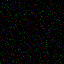

iterative denoising:  48%|████▊     | 16/33 [00:34<00:44,  2.59s/it]

Timestep t: 510, Prev Timestep: 480
Alpha Bar: 0.4767075181007385, Alpha Bar Prev: 0.523447573184967, Alpha: 0.9107072949409485
Image dtype: torch.float16
Timesteps dtype: torch.int64
Prompt embeds dtype: torch.float16
Model Output Shape: torch.Size([1, 6, 64, 64])


iterative denoising:  52%|█████▏    | 17/33 [00:37<00:43,  2.71s/it]

Model Output Min/Max: -1.509765625 0.82568359375
Noise Est Min/Max: -0.305419921875 0.82568359375
Predicted Variance Min/Max: -1.509765625 -1.03515625
Noise Est Shape: torch.Size([1, 3, 64, 64])
Predicted Variance Shape: torch.Size([1, 3, 64, 64])
Pred Prev Image Min/Max: -1.0 -0.1396484375
Timestep t: 480, Prev Timestep: 450
Alpha Bar: 0.523447573184967, Alpha Bar Prev: 0.5699834823608398, Alpha: 0.9183557033538818
Image dtype: torch.float16
Timesteps dtype: torch.int64
Prompt embeds dtype: torch.float16
Model Output Shape: torch.Size([1, 6, 64, 64])


iterative denoising:  55%|█████▍    | 18/33 [00:40<00:42,  2.81s/it]

Model Output Min/Max: -1.486328125 0.94677734375
Noise Est Min/Max: -0.29736328125 0.94677734375
Predicted Variance Min/Max: -1.486328125 -1.0439453125
Noise Est Shape: torch.Size([1, 3, 64, 64])
Predicted Variance Shape: torch.Size([1, 3, 64, 64])
Pred Prev Image Min/Max: -1.0 -0.12702620029449463
Timestep t: 450, Prev Timestep: 420
Alpha Bar: 0.5699834823608398, Alpha Bar Prev: 0.6159088611602783, Alpha: 0.9254347681999207
Image dtype: torch.float16
Timesteps dtype: torch.int64
Prompt embeds dtype: torch.float16
Model Output Shape: torch.Size([1, 6, 64, 64])


iterative denoising:  58%|█████▊    | 19/33 [00:41<00:34,  2.49s/it]

Model Output Min/Max: -1.46875 1.05078125
Noise Est Min/Max: -0.291015625 1.05078125
Predicted Variance Min/Max: -1.46875 -1.0234375
Noise Est Shape: torch.Size([1, 3, 64, 64])
Predicted Variance Shape: torch.Size([1, 3, 64, 64])
Pred Prev Image Min/Max: -1.0 -0.16095411777496338
Timestep t: 420, Prev Timestep: 390
Alpha Bar: 0.6159088611602783, Alpha Bar Prev: 0.6608222723007202, Alpha: 0.9320340752601624
Image dtype: torch.float16
Timesteps dtype: torch.int64
Prompt embeds dtype: torch.float16
Model Output Shape: torch.Size([1, 6, 64, 64])


iterative denoising:  61%|██████    | 20/33 [00:43<00:29,  2.23s/it]

Model Output Min/Max: -1.416015625 1.0703125
Noise Est Min/Max: -0.283203125 1.0703125
Predicted Variance Min/Max: -1.416015625 -1.0185546875
Noise Est Shape: torch.Size([1, 3, 64, 64])
Predicted Variance Shape: torch.Size([1, 3, 64, 64])
Pred Prev Image Min/Max: -1.0 -0.26424241065979004
Timestep t: 390, Prev Timestep: 360
Alpha Bar: 0.6608222723007202, Alpha Bar Prev: 0.704331636428833, Alpha: 0.938226044178009
Image dtype: torch.float16
Timesteps dtype: torch.int64
Prompt embeds dtype: torch.float16
Model Output Shape: torch.Size([1, 6, 64, 64])
Model Output Min/Max: -1.396484375 1.013671875
Noise Est Min/Max: -0.271484375 1.013671875
Predicted Variance Min/Max: -1.396484375 -1.0244140625
Noise Est Shape: torch.Size([1, 3, 64, 64])
Predicted Variance Shape: torch.Size([1, 3, 64, 64])
Pred Prev Image Min/Max: -1.0 -0.1844702959060669


"Timestep tensor([390], device='cuda:0')"

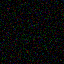

iterative denoising:  64%|██████▎   | 21/33 [00:45<00:24,  2.03s/it]

Timestep t: 360, Prev Timestep: 330
Alpha Bar: 0.704331636428833, Alpha Bar Prev: 0.7460564374923706, Alpha: 0.9440728425979614
Image dtype: torch.float16
Timesteps dtype: torch.int64
Prompt embeds dtype: torch.float16
Model Output Shape: torch.Size([1, 6, 64, 64])


iterative denoising:  67%|██████▋   | 22/33 [00:46<00:20,  1.88s/it]

Model Output Min/Max: -1.380859375 1.26171875
Noise Est Min/Max: -0.2509765625 1.26171875
Predicted Variance Min/Max: -1.380859375 -1.0419921875
Noise Est Shape: torch.Size([1, 3, 64, 64])
Predicted Variance Shape: torch.Size([1, 3, 64, 64])
Pred Prev Image Min/Max: -1.0 -0.2381117343902588
Timestep t: 330, Prev Timestep: 300
Alpha Bar: 0.7460564374923706, Alpha Bar Prev: 0.7856324315071106, Alpha: 0.9496253132820129
Image dtype: torch.float16
Timesteps dtype: torch.int64
Prompt embeds dtype: torch.float16
Model Output Shape: torch.Size([1, 6, 64, 64])


iterative denoising:  70%|██████▉   | 23/33 [00:48<00:17,  1.78s/it]

Model Output Min/Max: -1.3564453125 1.3017578125
Noise Est Min/Max: -0.2347412109375 1.3017578125
Predicted Variance Min/Max: -1.3564453125 -1.0556640625
Noise Est Shape: torch.Size([1, 3, 64, 64])
Predicted Variance Shape: torch.Size([1, 3, 64, 64])
Pred Prev Image Min/Max: -1.0 -0.2609104514122009
Timestep t: 300, Prev Timestep: 270
Alpha Bar: 0.7856324315071106, Alpha Bar Prev: 0.8227139711380005, Alpha: 0.9549278020858765
Image dtype: torch.float16
Timesteps dtype: torch.int64
Prompt embeds dtype: torch.float16
Model Output Shape: torch.Size([1, 6, 64, 64])


iterative denoising:  73%|███████▎  | 24/33 [00:49<00:15,  1.70s/it]

Model Output Min/Max: -1.357421875 1.3837890625
Noise Est Min/Max: -0.2242431640625 1.3837890625
Predicted Variance Min/Max: -1.357421875 -0.998046875
Noise Est Shape: torch.Size([1, 3, 64, 64])
Predicted Variance Shape: torch.Size([1, 3, 64, 64])
Pred Prev Image Min/Max: -1.0 -0.26088279485702515
Timestep t: 270, Prev Timestep: 240
Alpha Bar: 0.8227139711380005, Alpha Bar Prev: 0.8569768071174622, Alpha: 0.9600189328193665
Image dtype: torch.float16
Timesteps dtype: torch.int64
Prompt embeds dtype: torch.float16
Model Output Shape: torch.Size([1, 6, 64, 64])


iterative denoising:  76%|███████▌  | 25/33 [00:51<00:13,  1.63s/it]

Model Output Min/Max: -1.3046875 1.546875
Noise Est Min/Max: -0.212646484375 1.546875
Predicted Variance Min/Max: -1.3046875 -0.9970703125
Noise Est Shape: torch.Size([1, 3, 64, 64])
Predicted Variance Shape: torch.Size([1, 3, 64, 64])
Pred Prev Image Min/Max: -1.0 -0.3591194152832031
Timestep t: 240, Prev Timestep: 210
Alpha Bar: 0.8569768071174622, Alpha Bar Prev: 0.8881219625473022, Alpha: 0.9649314284324646
Image dtype: torch.float16
Timesteps dtype: torch.int64
Prompt embeds dtype: torch.float16
Model Output Shape: torch.Size([1, 6, 64, 64])
Model Output Min/Max: -1.263671875 1.5341796875
Noise Est Min/Max: -0.21044921875 1.5341796875
Predicted Variance Min/Max: -1.263671875 -0.97314453125
Noise Est Shape: torch.Size([1, 3, 64, 64])
Predicted Variance Shape: torch.Size([1, 3, 64, 64])
Pred Prev Image Min/Max: -1.0 -0.49902963638305664


"Timestep tensor([240], device='cuda:0')"

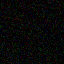

iterative denoising:  79%|███████▉  | 26/33 [00:52<00:11,  1.63s/it]

Timestep t: 210, Prev Timestep: 180
Alpha Bar: 0.8881219625473022, Alpha Bar Prev: 0.9158772230148315, Alpha: 0.9696954488754272
Image dtype: torch.float16
Timesteps dtype: torch.int64
Prompt embeds dtype: torch.float16


iterative denoising:  82%|████████▏ | 27/33 [00:54<00:09,  1.63s/it]

Model Output Shape: torch.Size([1, 6, 64, 64])
Model Output Min/Max: -1.224609375 1.3310546875
Noise Est Min/Max: -0.2313232421875 1.3310546875
Predicted Variance Min/Max: -1.224609375 -0.9599609375
Noise Est Shape: torch.Size([1, 3, 64, 64])
Predicted Variance Shape: torch.Size([1, 3, 64, 64])
Pred Prev Image Min/Max: -1.0 -0.463326632976532
Timestep t: 180, Prev Timestep: 150
Alpha Bar: 0.9158772230148315, Alpha Bar Prev: 0.9399999976158142, Alpha: 0.9743374586105347
Image dtype: torch.float16
Timesteps dtype: torch.int64
Prompt embeds dtype: torch.float16
Model Output Shape: torch.Size([1, 6, 64, 64])


iterative denoising:  85%|████████▍ | 28/33 [00:55<00:08,  1.63s/it]

Model Output Min/Max: -1.2138671875 1.669921875
Noise Est Min/Max: -0.259765625 1.669921875
Predicted Variance Min/Max: -1.2138671875 -0.9208984375
Noise Est Shape: torch.Size([1, 3, 64, 64])
Predicted Variance Shape: torch.Size([1, 3, 64, 64])
Pred Prev Image Min/Max: -1.0 -0.525392472743988
Timestep t: 150, Prev Timestep: 120
Alpha Bar: 0.9399999976158142, Alpha Bar Prev: 0.9602797627449036, Alpha: 0.9788814187049866
Image dtype: torch.float16
Timesteps dtype: torch.int64
Prompt embeds dtype: torch.float16
Model Output Shape: torch.Size([1, 6, 64, 64])


iterative denoising:  88%|████████▊ | 29/33 [00:57<00:06,  1.61s/it]

Model Output Min/Max: -1.15625 1.685546875
Noise Est Min/Max: -0.282958984375 1.685546875
Predicted Variance Min/Max: -1.15625 -0.9287109375
Noise Est Shape: torch.Size([1, 3, 64, 64])
Predicted Variance Shape: torch.Size([1, 3, 64, 64])
Pred Prev Image Min/Max: -1.0 -0.6217248439788818
Timestep t: 120, Prev Timestep: 90
Alpha Bar: 0.9602797627449036, Alpha Bar Prev: 0.9765393137931824, Alpha: 0.9833498001098633
Image dtype: torch.float16
Timesteps dtype: torch.int64
Prompt embeds dtype: torch.float16
Model Output Shape: torch.Size([1, 6, 64, 64])


iterative denoising:  91%|█████████ | 30/33 [00:59<00:04,  1.58s/it]

Model Output Min/Max: -1.146484375 1.6494140625
Noise Est Min/Max: -0.32470703125 1.6494140625
Predicted Variance Min/Max: -1.146484375 -0.93359375
Noise Est Shape: torch.Size([1, 3, 64, 64])
Predicted Variance Shape: torch.Size([1, 3, 64, 64])
Pred Prev Image Min/Max: -1.0 -0.657275378704071
Timestep t: 90, Prev Timestep: 60
Alpha Bar: 0.9765393137931824, Alpha Bar Prev: 0.9886365532875061, Alpha: 0.9877637028694153
Image dtype: torch.float16
Timesteps dtype: torch.int64
Prompt embeds dtype: torch.float16
Model Output Shape: torch.Size([1, 6, 64, 64])
Model Output Min/Max: -1.1123046875 1.9609375
Noise Est Min/Max: -0.333740234375 1.9609375
Predicted Variance Min/Max: -1.1123046875 -0.9443359375
Noise Est Shape: torch.Size([1, 3, 64, 64])
Predicted Variance Shape: torch.Size([1, 3, 64, 64])
Pred Prev Image Min/Max: -1.0 -0.7518425583839417


"Timestep tensor([90], device='cuda:0')"

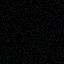

iterative denoising:  94%|█████████▍| 31/33 [01:00<00:03,  1.58s/it]

Timestep t: 60, Prev Timestep: 30
Alpha Bar: 0.9886365532875061, Alpha Bar Prev: 0.9964657425880432, Alpha: 0.9921430349349976
Image dtype: torch.float16
Timesteps dtype: torch.int64
Prompt embeds dtype: torch.float16
Model Output Shape: torch.Size([1, 6, 64, 64])


iterative denoising:  97%|█████████▋| 32/33 [01:02<00:01,  1.65s/it]

Model Output Min/Max: -1.1064453125 1.974609375
Noise Est Min/Max: -0.43505859375 1.974609375
Predicted Variance Min/Max: -1.1064453125 -0.90283203125
Noise Est Shape: torch.Size([1, 3, 64, 64])
Predicted Variance Shape: torch.Size([1, 3, 64, 64])
Pred Prev Image Min/Max: -0.9868032932281494 -0.9386353492736816
Timestep t: 30, Prev Timestep: 0
Alpha Bar: 0.9964657425880432, Alpha Bar Prev: 0.9999586939811707, Alpha: 0.996506929397583
Image dtype: torch.float16
Timesteps dtype: torch.int64
Prompt embeds dtype: torch.float16
Model Output Shape: torch.Size([1, 6, 64, 64])


iterative denoising: 100%|██████████| 33/33 [01:04<00:00,  1.94s/it]

Model Output Min/Max: -1.1171875 0.40966796875
Noise Est Min/Max: -0.42919921875 0.40966796875
Predicted Variance Min/Max: -1.1171875 -0.9248046875
Noise Est Shape: torch.Size([1, 3, 64, 64])
Predicted Variance Shape: torch.Size([1, 3, 64, 64])
Pred Prev Image Min/Max: -0.966796875 -0.96240234375


Noisy 990,Iterative

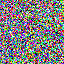
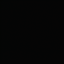

In [20]:
# Define the prompt embeddings
prompt_embeds = prompt_embeds_dict["a high quality photo"].to(device)

# Load and preprocess image
image_path = "zot.jpg"
image = Image.open(image_path).convert("RGB")
transform = transforms.Compose([
    transforms.Resize((64, 64)),  
    transforms.ToTensor(),  
    transforms.Normalize(0.5, 0.5)  
])
test_im = transform(image).unsqueeze(0).to(device).half()

# Start denoising from pure noise
i_start = 0
t = strided_timesteps[i_start]

for i in range(5):  
    im_noisy = torch.randn_like(test_im).to(device).half()  

    # Denoise the image
    gen = iterative_denoise(im_noisy, i_start=i_start, prompt_embeds=prompt_embeds, timesteps=strided_timesteps)

    # Display the images
    disp = {
        f"Noisy {t}": im_noisy[0].cpu().permute(1, 2, 0).numpy() / 2. + 0.5,
        f"Iterative": gen[0].cpu().permute(1, 2, 0).numpy() / 2. + 0.5
    }
    media.show_images(disp, width=256, height=256)

# 3. Classifier Free Guidance [10 pts]

You may have noticed that some of the generated images in the prior section are not great. In order to greatly improve image quality (at the expense of image diversity), we can use a technique called [Classifier-Free Guidance](https://arxiv.org/abs/2207.12598).

In CFG, we compute both a noise estimate conditioned on a text prompt, and an unconditional noise estimate. We denote these $\epsilon_c$ and $\epsilon_u$. Then, we let our new noise estimate be

$$\epsilon = \epsilon_u + \gamma (\epsilon_c - \epsilon_u) $$

where $\gamma$ controls the strength of CFG. Notice that for $\gamma=0$, we get an unconditional noise estimate, and for $\gamma=1$ we get the conditional noise estimate. The magic happens when $\gamma > 1$. In this case, we get much higher quality images. Why this happens is still up to vigorous debate. For more information on CFG, you can check out [this blog post](https://sander.ai/2022/05/26/guidance.html).

Please implement the `iterative_denoise_cfg` function, identical to the `iterative_denoise` function but using classifier-free guidance. To get an unconditional noise estimate, we can just pass an empty prompt embedding to the diffusion model (the model was trained to predict an unconditional noise estimate when given an empty text prompt).

### Disclaimer
Before, we used `"a high quality photo"` as a "null" condition. Now, we will use the actual `""` null prompt for unconditional guidance for CFG. In the later part, you should always use `""` null prompt for unconditional guidance and use `"a high quality photo"` for deault conditional guidance.

### Deliverables

- Implement the `iterative_denoise_cfg` function
- Show 5 images of `"a high quality photo"` with a CFG scale of $\gamma=7$

### Hints

- You will need to run the UNet twice, once for the conditional prompt embedding, and once for the unconditional
- The UNet will predict both a conditional and an unconditional variance. Just use the conditional variance with the `add_variance` function.
- The resulting images should be more "photographic" than those in the prior section


In [ ]:
def add_variance_task3(predicted_variance, t, image, timesteps):
    """
    Args:
        predicted_variance: (1, 3, 64, 64) tensor, last three channels of the UNet output
        t: scale tensor indicating timestep
        image: (1, 3, 64, 64) tensor, noisy image
        timesteps: a tensor of timesteps, similar to `strided_timesteps`

    Returns:
        (1, 3, 64, 64) tensor, image with the correct amount of variance added
    """
    # Ensure t is on the correct device and in long for indexing
    t = t.to(image.device).long()

    # Find the index of current timestep `t` in the full `timesteps` tensor
    index = (timesteps == t).nonzero(as_tuple=True)[0]
    if index.numel() == 0:  # Handle cases where t is not in timesteps
        index = torch.tensor(0, device=image.device)
    else:
        index = index[0]  # Take the first match

    # Retrieve the appropriate variance term
    variance = stage_1.scheduler._get_variance(
        timesteps[index].unsqueeze(0).to(image.device).long(),  # Ensure correct shape, device, and dtype
        predicted_variance=predicted_variance
    )

    variance_noise = torch.randn_like(image).half()  # Ensure noise is in float16

    # Scale down the variance addition
    variance = torch.exp(0.5 * variance) * variance_noise * 0.75

    # Clip the variance to prevent extreme values
    variance = torch.clamp(variance, -0.75, 0.75)

    return image + variance

In [ ]:
def iterative_denoise_cfg(image, i_start, prompt_embeds, uncond_prompt_embeds, timesteps, vis=True):
    with torch.no_grad():
        # Ensure image is in float16
        image = image.half()

        # Move timesteps to the same device as the image
        timesteps = torch.tensor(timesteps, device=image.device)

        # Move the scheduler's timesteps to the same device
        stage_1.scheduler.timesteps = stage_1.scheduler.timesteps.to(image.device)

        for i in tqdm(range(i_start, len(timesteps) - 1), "denoising"):
            if i >= len(timesteps) - 1:  # Ensure index is in range
                break

            # Get timesteps and move to device
            t = timesteps[i].long()  # Convert to long for indexing
            prev_t = timesteps[i + 1].long()  # Convert to long for indexing

            # Parameters
            gamma = 7
            alpha_bar = stage_1.scheduler.alphas_cumprod[t].to(image.device)  # Ensure alpha_bar is on the correct device
            alpha_bar_prev = stage_1.scheduler.alphas_cumprod[prev_t].to(image.device)  # Ensure alpha_bar_prev is on the correct device
            alpha = alpha_bar / alpha_bar_prev

            # Ensure prompt_embeds and uncond_prompt_embeds are in float16
            prompt_embeds = prompt_embeds.half()
            uncond_prompt_embeds = uncond_prompt_embeds.half()

            # Ensure t is in float16 for the model
            t_float16 = t.float().half()

            # Get noise estimate
            model_output = stage_1.unet(
                image.half(),
                t_float16,  # Ensure t is in float16
                encoder_hidden_states=prompt_embeds.to(image.device),  # Ensure prompt_embeds is in float16
                return_dict=False
            )[0]

            # Get uncond noise estimate
            uncond_model_output = stage_1.unet(
                image.half(),
                t_float16,  # Ensure t is in float16
                encoder_hidden_states=uncond_prompt_embeds.to(image.device),  # Ensure uncond_prompt_embeds is in float16
                return_dict=False
            )[0]

            # Split estimate into noise and variance estimate
            cond_noise_est, predicted_variance = torch.split(model_output, image.shape[1], dim=1)
            uncond_noise_est, _ = torch.split(uncond_model_output, image.shape[1], dim=1)
            noise_est = uncond_noise_est + gamma * (cond_noise_est - uncond_noise_est)  # Combination of conditional and unconditional

            # Predict x_0 from the noise_est and x_t
            x_t = image
            x_0 = (x_t - torch.sqrt(1 - alpha_bar) * noise_est) / torch.sqrt(alpha_bar)

            # Predict the previous image
            pred_prev_image = torch.sqrt(alpha_bar_prev) * x_0 + torch.sqrt(1 - alpha_bar_prev) * noise_est

            # Add noise using the new add_variance_task3 function
            pred_prev_image = add_variance_task3(predicted_variance, prev_t, pred_prev_image, timesteps)

            # Update the image for the next iteration
            image = pred_prev_image

    clean = image.cpu().detach()
    return clean

In [ ]:
# The condition prompt embedding
prompt_embeds = prompt_embeds_dict['a high quality photo'].half()  # Ensure float16
# The unconditional prompt embedding
uncond_prompt_embeds = prompt_embeds_dict[''].half()  # Ensure float16


# Add noise
i_start = 0
t = strided_timesteps[i_start]

for i in range(5):
    image_tensor = torchvision.transforms.ToTensor()(image).unsqueeze(0).to(device)  # Convert image to tensor
    im_noisy = torch.randn_like(image_tensor).half()  # Generate Gaussian noise in float16

    # Denoise
    gen = iterative_denoise_cfg(im_noisy.to(device),
                          i_start=i_start,
                          prompt_embeds=prompt_embeds.to(device),  # Ensure prompt_embeds is in float16
                          uncond_prompt_embeds=uncond_prompt_embeds.to(device),  # Ensure uncond_prompt_embeds is in float16
                          timesteps=strided_timesteps)

    ## also upsample result if desired

    # disp={}
    # disp[f"Noisy {t}"] = im_noisy[0].permute(1,2,0)/2.+0.5
    # disp[f"Iterative CFG"] = gen[0].permute(1,2,0)/2.+0.5
    # #disp[f"Upsampled"] = gen_256[0].permute(1,2,0)/2.+0.5

    # media.show_images(disp,width=256,height=256)

    # Display the images
    disp = {
        f"Noisy {t}": im_noisy[0].cpu().permute(1, 2, 0).numpy() / 2. + 0.5,
        f"Iterative": gen[0].cpu().permute(1, 2, 0).numpy() / 2. + 0.5
    }
    media.show_images(disp, width=256, height=256)

# 4. Image-to-image Translation

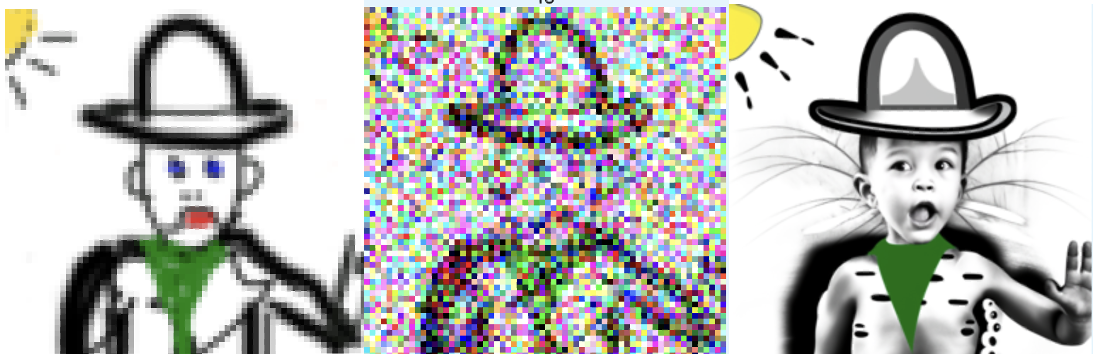

Now we will experiment with taking a real image, add noise to it, and then denoise. This effectively allows us to make modiications to existing images. The more noise we add, the larger the edit will be. This works because in order to denoise an image, the diffusion model must to some extent "hallucinate" new things -- the model has to be "creative." Another way to think about it is that the denoising process "forces" a noisy image back onto the manifold of natural images but we won't necessarily end up where we started.

To start, we're going to take the original test image, noise it a little, and force it back onto the image manifold without any conditioning. Effectively, we're going to get an image that is similar to the test image (with a low-enough noise level). This follows the [SDEdit](https://sde-image-editing.github.io/) algorithm.

Please run the forward process to get a noisy test image, and then run your `iterative_denoise_cfg` function using a starting index of [1, 3, 5, 7, 10, 20] steps and show the results, labeled with the starting index. You should see a series of "edits" to the original image, gradually matching the original image closer and closer.

### Deliverables

- Edits of the test image, using the given prompt at noise levels [1, 3, 5, 7, 10, 20] with text prompt `"a high quality photo"`
- Edits of 2 of your own test images, using the same procedure.

### Hints

- You should see a range of images that start randomly and gradually look more like the original image
- You may find the provided utility functions useful for grabbing a local image or an image off the web and converting it appropriate for input to the model

# 4.1 Implementation [10pts]

In [ ]:
def image2image(image,ivals = [1,3,5,7,10,20],vis=True):
    # Please use this prompt, as an "unconditional" text prompt
    prompt_embeds = prompt_embeds_dict["a high quality photo"]
    uncond_prompt_embeds = prompt_embeds_dict['']

    img_in={}
    img_out={}
    for i_start in ivals:
        t = strided_timesteps[i_start]
    
        noisy = iterative_denoise_cfg(image.half().to(device), prompt_embeds, uncond_prompt_embeds, t)
    
        gen = iterative_denoise_cfg(noisy.half().to(device), prompt_embeds, uncond_prompt_embeds, t)
    
        img_in[i_start] = noisy[0].permute(1,2,0)/2.+0.5
        img_out[i_start] = gen[0].permute(1,2,0)/2.+0.5

    if vis:
        media.show_images(img_in,width=256,height=256,columns=6)
        media.show_images(img_out,width=256,height=256,columns=6)
        
    return img_out

In [ ]:
#
# utility code for converting an image into an appropriately scaled tensor
#
def process_pil_im(img,vis=True):
    '''
    Transform a PIL image into a tensor of size [1,3,64,64]
    '''
    
    # Convert to RGB
    img = img.convert('RGB')
    
    # Define the transform to resize, convert to tensor, and normalize to [-1, 1]
    transform = transforms.Compose([
        transforms.Resize(64),               # Resize shortest side to 64
        transforms.CenterCrop(64),             # Center crop
        transforms.ToTensor(),               # Convert image to PyTorch tensor with range [0, 1]
        transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))  # Normalize to range [-1, 1]
    ])
    
    # Apply the transformations and add batch dim
    img = transform(img)[None]
    
    # Show image
    if vis:
        print("Processed image")
        media.show_image(img[0].permute(1,2,0) / 2 + 0.5,height=256,width=256)
    
    return img

In [ ]:
################
# load an image from a given URL
### (please use your own URL below"
###############
url = "https://parkerlab.bio.uci.edu/pictures/photography%20pictures/2020_10_20_UCI_buildings/_5R_9295_tweak.jpg"
response = requests.get(url)
web_im = Image.open(BytesIO(response.content))
# The function below crops out the center of the image if it is not square.
# you may want to manually crop before that step, e.g. web_im = web_im.crop((3000,500,7016,4872))
web_im = process_pil_im(web_im)

In [ ]:
##############
# Load a local image.  If you are using google colab you will need to put the file in google drive 
#  or some other hosting location and access it from there
#
##############
# Load a local image.  If you are using google colab you will need to put the file in google drive 
#  or some other hosting location and access it from there
#
import requests
from PIL import Image
from io import BytesIO

# Replace with your file's direct download link
url = "https://upload.wikimedia.org/wikipedia/commons/thumb/4/48/Outdoors-man-portrait_%28cropped%29.jpg/800px-Outdoors-man-portrait_%28cropped%29.jpg"
response = requests.get(url)
my_im = Image.open(BytesIO(response.content))
#my_im = Image.open('face1.png')
my_im = process_pil_im(my_im)
image2image(my_im,ivals=[1,3,5,7,10,20]);



In [ ]:
# test with test_im and two other images of your own choosing
image2image(test_im);
image2image(web_im);
.
.
etc
.
.


## 4.2 Sketch-to-Image [5pts]

This procedure is particularly fun if we start with a nonrealistic image (e.g. painting, a sketch, some scribbles) and project it onto the natural image manifold. Please experiment by starting with hand-drawn or other non-realistic images and see where they are mapped back onto the natural image manifold.

For this part you can experiment with images from the web but at least one input should be an image that you drew yourself (e.g. using some paint program or even an image editor on your phone). For drawing inspiration, you can check out the examples on [this project page](https://sde-image-editing.github.io/).

### Deliverables

- 1 image from the web of your choice, edited using the above method for noise levels [1, 3, 5, 7, 10, 20] (and whatever additional noise levels you want)
- 1 hand drawn image, edited using the above method for noise levels [1, 3, 5, 7, 10, 20] (and whatever additional noise levels you want)

### Hints
- Use the preprocessing code above to convert web images to the format expected by DeepFloyd.
  

# 5. Inpainting [15 pts]

We can use the same procedure to implement inpainting (following the [RePaint](https://arxiv.org/abs/2201.09865) paper). That is, given an image $x_{orig}$, and a binary mask $\bf m$, we can create a new image that has the same content where $\bf m$ is 0, but new content wherever $\bf m$ is 1.

To do this, we can run the diffusion denoising loop. But at every step, after obtaining $x_t$, we "force" $x_t$ to have the same pixels as $x_{orig}$ where $\bf m$ is 0, i.e.:

$ x_t \leftarrow \textbf{m} x_t + (1 - \textbf{m}) \text{forward}(x_{orig}, t) \tag{5}$

Essentially, we leave everything inside the edit mask alone, but we replace everything outside the edit mask with our original image -- with the correct amount of noise added for timestep $t$.

Please implement this below, and edit the picture to inpaint the top of the Campanile.

### Deliverables

- A properly implemented `inpaint` function
- The test image inpainted (feel free to use your own mask)
- 2 of your own images edited (come up with your own mask)
  - look at the results from [this paper](http://graphics.cs.cmu.edu/projects/scene-completion/) for inspiration

### Hints

- Reuse the `forwardnoise` function you implemented earlier
- Because we are using the diffusion model for tasks it was not trained for, you may have to run the sampling process a few times before you get a nice result.
- To start you can copy and paste from your `iterative_denoise_cfg` function and then modify as needed. To get inpainting to work should only require (roughly) 1-2 additional lines and a few small changes.

In [ ]:
def inpaint(original_image, mask, prompt_embeds, uncond_prompt_embeds, timesteps,istart=0, vis=True):

    original_image = original_image.to(device).half()
    #image = torch.randn_like(original_image).to(device).half()
    image = forwardnoise(original_image,timesteps[istart]).to(device).half()

    mask = mask.to(device).half()
    
    # use your previous `iterative_denoise_cfg` function and make the appropriate changes
    with torch.no_grad():
        for i in tqdm(range(istart, len(timesteps) - 1),"denoising"):
            t = timesteps[i]
            prev_t = timesteps[i+1]
            
            ....
 
 
            #mask the result and replace the background with a noisy version of the original_image
            image = mask*pred_prev_image + (1-mask)*.....

            #show intermediate results every 5 iterations
            if (vis) & (i%5==0):
                x_0 = x_0.cpu().detach()[0]
                x_t = image.cpu().detach()[0]
                media.show_images({x_t.permute(1,2,0)/2.+0.5,x_0.permute(1,2,0)/2.+0.5},width=128,height=128)

    return image.cpu().detach()


Now test your inpainting function

In [ ]:
prompt_embeds = prompt_embeds_dict["a high quality photo"]
uncond_prompt_embeds = prompt_embeds_dict['']

# Make a mask
mask = torch.zeros_like(test_im)
mask[:, :, 2:20, 16:42] = 1.0
mask = TF.gaussian_blur(mask,9,2)
mask = mask.to(device)

#inpaint
filled_im = inpaint(test_im,mask,prompt_embeds,uncond_prompt_embeds,strided_timesteps,istart=5,vis=True)

# Visualize mask
media.show_images({
    'Image': im[0].permute(1,2,0) / 2. + 0.5,
    'Mask': mask.cpu()[0].permute(1,2,0),
    'To Replace': (im * mask.cpu())[0].permute(1,2,0) / 2. + 0.5,
    'Result': filled_im[0].permute(1,2,0) / 2. + 0.5,
    'Filled': (filled_im * mask.cpu())[0].permute(1,2,0) / 2. + 0.5,
},height=256,width=256)



In [ ]:
def add_variance_task3(predicted_variance, t, image, timesteps):
    """
    Args:
        predicted_variance: (1, 3, 64, 64) tensor, last three channels of the UNet output
        t: scale tensor indicating timestep
        image: (1, 3, 64, 64) tensor, noisy image
        timesteps: a tensor of timesteps, similar to `strided_timesteps`

    Returns:
        (1, 3, 64, 64) tensor, image with the correct amount of variance added
    """
    # Ensure t is on the correct device and in long for indexing
    t = t.to(image.device).long()

    # Ensure timesteps is on the correct device
    timesteps = timesteps.to(image.device)

    # Find the index of current timestep `t` in the full `timesteps` tensor
    index = (timesteps == t).nonzero(as_tuple=True)[0]
    if index.numel() == 0:  # Handle cases where t is not in timesteps
        index = torch.tensor(0, device=image.device)
    else:
        index = index[0]  # Take the first match

    # Retrieve the appropriate variance term
    variance = stage_1.scheduler._get_variance(
        timesteps[index].unsqueeze(0).to(image.device).long(),  # Ensure correct shape, device, and dtype
        predicted_variance=predicted_variance
    )

    variance_noise = torch.randn_like(image).half()  # Ensure noise is in float16

    # Scale down the variance addition
    variance = torch.exp(0.5 * variance) * variance_noise * 0.75

    # Clip the variance to prevent extreme values
    variance = torch.clamp(variance, -0.75, 0.75)

    return image + variance


def inpaint(original_image, mask, prompt_embeds, uncond_prompt_embeds, timesteps, istart=0, vis=True):
    original_image = original_image.to(device).half()
    image = forwardnoise(original_image, timesteps[istart]).to(device).half()
    mask = mask.to(device).half()

    # Ensure timesteps is a PyTorch tensor and on the correct device
    if not isinstance(timesteps, torch.Tensor):
        timesteps = torch.tensor(timesteps, device=device)
    else:
        timesteps = timesteps.to(device)

    # Ensure stage_1.scheduler.timesteps is on the correct device
    stage_1.scheduler.timesteps = stage_1.scheduler.timesteps.to(device)

    with torch.no_grad():
        for i in tqdm(range(istart, len(timesteps) - 1), "denoising"):
            if i >= len(timesteps) - 1:  # Ensure index is in range
                break

            # Get timesteps and ensure they are on the correct device
            t = timesteps[i].to(device)  # Move to the correct device
            prev_t = timesteps[i + 1].to(device)  # Move to the correct device

            # Parameters
            gamma = 7
            alpha_bar = stage_1.scheduler.alphas_cumprod[t].to(device)  # Ensure alpha_bar is on the correct device
            alpha_bar_prev = stage_1.scheduler.alphas_cumprod[prev_t].to(device)  # Ensure alpha_bar_prev is on the correct device
            alpha = alpha_bar / alpha_bar_prev

            # Ensure prompt_embeds and uncond_prompt_embeds are in float16
            prompt_embeds = prompt_embeds.half()
            uncond_prompt_embeds = uncond_prompt_embeds.half()

            # Ensure t is in float16 for the model
            t_float16 = t.float().half()

            # Get noise estimate
            model_output = stage_1.unet(
                image.half(),
                t_float16,  # Ensure t is in float16
                encoder_hidden_states=prompt_embeds.to(device),  # Ensure prompt_embeds is on the correct device
                return_dict=False
            )[0]

            # Get uncond noise estimate
            uncond_model_output = stage_1.unet(
                image.half(),
                t_float16,  # Ensure t is in float16
                encoder_hidden_states=uncond_prompt_embeds.to(device),  # Ensure uncond_prompt_embeds is on the correct device
                return_dict=False
            )[0]

            # Split estimate into noise and variance estimate
            cond_noise_est, predicted_variance = torch.split(model_output, image.shape[1], dim=1)
            uncond_noise_est, _ = torch.split(uncond_model_output, image.shape[1], dim=1)
            noise_est = uncond_noise_est + gamma * (cond_noise_est - uncond_noise_est)  # Combination of conditional and unconditional

            # Predict x_0 from the noise_est and x_t
            x_t = image
            x_0 = (x_t - torch.sqrt(1 - alpha_bar) * noise_est) / torch.sqrt(alpha_bar)

            # Predict the previous image
            pred_prev_image = torch.sqrt(alpha_bar_prev) * x_0 + torch.sqrt(1 - alpha_bar_prev) * noise_est

            # Add noise using the new add_variance_task3 function
            pred_prev_image = add_variance_task3(predicted_variance, prev_t, pred_prev_image, timesteps)

            # Mask the result and replace the background with a noisy version of the original_image
            noisy_original = forwardnoise(original_image, prev_t).to(device).half()
            image = mask * pred_prev_image + (1 - mask) * noisy_original

            # Show intermediate results every 5 iterations
            if vis and i % 5 == 0:
                x_0 = x_0.cpu().detach()[0]
                x_t = image.cpu().detach()[0]
                media.show_images({
                    'x_t': x_t.permute(1, 2, 0) / 2. + 0.5,
                    'x_0': x_0.permute(1, 2, 0) / 2. + 0.5
                }, width=128, height=128)

    return image.cpu().detach()

# Example usage
prompt_embeds = prompt_embeds_dict["a high quality photo"].half()
uncond_prompt_embeds = prompt_embeds_dict[''].half()

# Make a mask
mask = torch.zeros_like(test_im)
mask[:, :, 2:20, 16:42] = 1.0
mask = TF.gaussian_blur(mask, 9, 2)
mask = mask.to(device)

# Ensure timesteps is a PyTorch tensor and on the correct device
if not isinstance(strided_timesteps, torch.Tensor):
    strided_timesteps = torch.tensor(strided_timesteps, device=device)
else:
    strided_timesteps = strided_timesteps.to(device)

# Ensure stage_1.scheduler.timesteps is on the correct device
stage_1.scheduler.timesteps = stage_1.scheduler.timesteps.to(device)

# Inpaint
filled_im = inpaint(test_im, mask, prompt_embeds, uncond_prompt_embeds, strided_timesteps, istart=5, vis=True)

# Visualize mask
media.show_images({
    'Image': test_im[0].permute(1, 2, 0) / 2. + 0.5,
    'Mask': mask.cpu()[0].permute(1, 2, 0),
    'To Replace': (test_im * mask.cpu())[0].permute(1, 2, 0) / 2. + 0.5,
    'Result': filled_im[0].permute(1, 2, 0) / 2. + 0.5,
    'Filled': (filled_im * mask.cpu())[0].permute(1, 2, 0) / 2. + 0.5,
}, height=256, width=256)

# 6. Text-Conditioned Inpainting [10 pts]

Now, we will do the same thing as the previous section, but guide the projection with a text prompt. This is no longer pure "projection to the natural image manifold" but also adds control using language. This is simply a matter of changing the prompt from `"a high quality photo"` to any of the precomputed prompts we provide you (if you want to use your own prompts, see appendix).

### Deliverables

- Edits of the test image, using the given prompt at noise levels [1, 3, 5, 7, 10, 20]
- Edits of 2 of your own test images, using the same procedure.

### Hints

- The images should gradually look more like original image, but also look like the text prompt.

In [ ]:

prompt_embeds = prompt_embeds_dict["a rocket ship"]
uncond_prompt_embeds = prompt_embeds_dict['']

# Make mask

#inpaint

# Visualize 
media.show_images({
    'Image': im[0].permute(1,2,0) / 2. + 0.5,
    'Mask': mask.cpu()[0].permute(1,2,0),
    'To Replace': (im * mask.cpu())[0].permute(1,2,0) / 2. + 0.5,
    'Result': filled_im[0].permute(1,2,0) / 2. + 0.5,
    'Filled': (filled_im * mask.cpu())[0].permute(1,2,0) / 2. + 0.5,
},height=256,width=256)

#show upsampled result if desired
#final = upsample(filled_im,prompt_embeds)
#media.show_image(final[0].permute(1,2,0)/2+0.5)
